# Libraries and Import

## Install necessary libraries




In [ ]:
!pip install ccxt
!pip install pandas_datareader
!pip install deap 

     |████████████████████████████████| 2.1MB 5.3MB/s 
     |████████████████████████████████| 3.2MB 17.0MB/s 
     |████████████████████████████████| 163kB 42.0MB/s 
     |████████████████████████████████| 1.3MB 40.5MB/s 
     |████████████████████████████████| 143kB 54.7MB/s 
     |████████████████████████████████| 235kB 49.4MB/s 
  Created wheel for yarl: filename=yarl-1.1.0-cp37-cp37m-linux_x86_64.whl size=241449 sha256=16fe19212126117161b6bb7c903175609b203f8b946898b3a2e776056b191409
  Stored in directory: /root/.cache/pip/wheels/96/26/b9/7972042a1a69556ba7f38b8a301dc3a9ddac1b8f61f02fbfd8
Successfully built yarl
     |████████████████████████████████| 163kB 5.5MB/s 


## Import necessary libraries



In [ ]:
import time
from datetime import datetime
import ccxt
import re
import pytz
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import numpy as np
from google.colab import drive 
from itertools import combinations 
from __future__ import division
from datetime import datetime
from deap import base, creator, tools, algorithms
import matplotlib.dates as mdates

# Arbitrage Strategy

Arbitrage is the **simultaneous purchase and sale** of the same asset in different markets in order to profit from tiny differences in the asset's listed price. It exploits **short-lived** variations in the price of identical or similar financial instruments in different markets or in different forms. There are three types of arbitrage tradings stated in this [article](https://academy.binance.com/en/articles/what-is-arbitrage-trading).

**Exchange arbitrage** - A trader buys the same cryptoasset in one exchange and sells it in another

**Funding rate arbitrage** - A trader buys a cryptocurrency and hedges it’s price movement with a futures contract in the same cryptocurrency that has a funding rate lower than the cost of purchasing the cryptocurrency

**Triangular arbitrage**  - A trader notices a price discrepancy between three different cryptocurrencies and exchanges them for one another in a kind of loop

In this assignment, we will be exploring and implementing exchange arbitrage and triangular arbitrage.



## Data for ZIL/USDT, ZIL/ETH and ETH/USDT

We collected collected ZIL/USDT, ZIL/ETH and ETH/USDT data using CCXT from various markets at one minute intervals from  25th Feb 2021 10:20 pm to 26th Feb 2021 8:30pm.

We inspected and performed the necessary cleaning of data to ensure bad data is removed from the dataset. In this case, we removed rows where there were missing data.

Information collected include bid (buy) price, bid (buy) volume, ask (sell) price,  ask (sell) volume, taker fees and datetime. We will go into detail later why we also choose to collect bid and ask volumes.

##  Exchange Arbitrage 
These are the following two methods we explored
1.   Simultaneous buy and sell at mid price of bid and sell price
2.   Simultaneous sell at highest bid and buy at lowest ask




In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Function read_google_csv to read csv file in google drive

In [ ]:
def read_google_csv(url):
  path ='https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
  return pd.read_csv(path) 

Read the csv file in google drive and store the crypto information (ZIL/USDT, ETH/USDT, Zil/ETH) in dataframe 

In [ ]:
# Information gathered from different exchanges about their ask fee, ask volume, bid fee, bid volume, taker fee, time requested
zilAskCsvFile = read_google_csv("https://drive.google.com/file/d/13_dgNvlajNdZWzk6A-WyFAaj-Sbht-t8/view?usp=sharing")
zilAskVolumeCsvFile = read_google_csv("https://drive.google.com/file/d/1M8NJ7SovXd24LdjRYlOpF94uT9-hSlLb/view?usp=sharing")
zilBidCsvFile = read_google_csv("https://drive.google.com/file/d/1MBox9BThnR15G6SvTYiyZt5LrqiTmrbK/view?usp=sharing")
zilBidVolumeCsvFile = read_google_csv("https://drive.google.com/file/d/1k-kncr5rqanjno5SHnW7ol8YDfRLfXMm/view?usp=sharing")
zilTakerCsvFile = read_google_csv("https://drive.google.com/file/d/1A0Ey8nzHIi0rd76t1oaNk7TOrxw_T2U6/view?usp=sharing")
zilTimeCsvFile = read_google_csv("https://drive.google.com/file/d/1LpSGmteOzUWTFqbQqaxrmfttzUEmcXt7/view?usp=sharing")

ethAskCsvFile = read_google_csv("https://drive.google.com/file/d/1YnljtwEUrQNuk1OVrshQKI5WX_Ht3Wcp/view?usp=sharing")
ethAskVolumeCsvFile = read_google_csv("https://drive.google.com/file/d/1g0jdHxxSwhgErWfbfyO4pGp2T4fU0TOa/view?usp=sharing")
ethBidCsvFile = read_google_csv("https://drive.google.com/file/d/1i37SgDPQldIeE746sNvrE5SMXlFOd-Ar/view?usp=sharing")
ethBidVolumeCsvFile = read_google_csv("https://drive.google.com/file/d/1_FDQu-bAfLzDuw0TLFvgOzQxK9F5OCOM/view?usp=sharing")
ethTakerCsvFile = read_google_csv("https://drive.google.com/file/d/1meocC22wvCEHHntIWO6Mpp66VrkaxsZf/view?usp=sharing")
ethTimeCsvFile = read_google_csv("https://drive.google.com/file/d/1DP4QPwSyAVRCMNwdzi5QY2Gnn6ir0enc/view?usp=sharing")


zilethAskCsvFile = read_google_csv("https://drive.google.com/file/d/175ANNJN1hsAd9-dyCzERJwg17Q-ny9Mi/view?usp=sharing")
zilethAskVolumeCsvFile = read_google_csv("https://drive.google.com/file/d/1I0ucUNTetty5XgSk4YURPII8zmX8N6gy/view?usp=sharing")
zilethBidCsvFile = read_google_csv("https://drive.google.com/file/d/1gG0X33K01EbtvHELt96AP-O8JmBLQ5Yc/view?usp=sharing")
zilethBidVolumeCsvFile = read_google_csv("https://drive.google.com/file/d/1wWHAZCyQAhRuVt7aqVInUMZyVxbfeciG/view?usp=sharing")
zilethTakerCsvFile = read_google_csv("https://drive.google.com/file/d/1D_03J93hgWgd3pYY8-YNiLc8AGiGx3HA/view?usp=sharing")
zilethTimeCsvFile = read_google_csv("https://drive.google.com/file/d/1QJpN9YtYRC0yjfdxh-0sBEE4ft0G-CbT/view?usp=sharing")

# Fill any missing values in the dataframes with NaN as a precaution although we mentioned have already eliminated rows that have missing values
dfZilAsk = zilAskCsvFile.fillna(method='ffill')
dfZilBid = zilBidCsvFile.fillna(method='ffill')
dfZilAskVolume = zilAskVolumeCsvFile.fillna(method='ffill')
dfZilBidVolume = zilBidVolumeCsvFile.fillna(method='ffill')
dfZilTaker = zilTakerCsvFile.fillna(method='ffill')
dfZilTime = zilTimeCsvFile.fillna(method='ffill')

dfEthAsk = ethAskCsvFile.fillna(method='ffill')
dfEthBid = ethBidCsvFile.fillna(method='ffill')
dfEthAskVolume = ethAskVolumeCsvFile.fillna(method='ffill')
dfEthBidVolume = ethBidVolumeCsvFile.fillna(method='ffill')
dfEthTime = ethTimeCsvFile.fillna(method='ffill')
dfEthTaker = ethTakerCsvFile.fillna(method='ffill')


dfZilethAsk = zilethAskCsvFile.fillna(method='ffill')
dfZilethBid = zilethBidCsvFile.fillna(method='ffill')
dfZilethAskVolume = zilethAskVolumeCsvFile.fillna(method='ffill')
dfZilethBidVolume = zilethBidVolumeCsvFile.fillna(method='ffill')
dfZilethTime = zilethTimeCsvFile.fillna(method='ffill')
dfZilethTaker = zilethTakerCsvFile.fillna(method='ffill')

Quick examination of ask fee data for ETH/USDT and ZIL/USDT shows no irregularities as describe results were similar

In [ ]:
dfEthAsk.describe()

,kuna,exmo,bitmart,liquid,bw,ftx,oceanex,bittrex,hbtc,bequant,bybit,huobipro,kraken,poloniex,cdax,bitcoincom,binanceus,bitkk,bitfinex2,binance,novadax,bitfinex,cex,crex24,bitget,zb,coinegg,bibox,kucoin,bigone,hitbtc,bitmax,bitz,indodax,coinex,okex,bitforex,gateio,phemex
count,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.00000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.00000,1042.000000
mean,1540.790816,1526.111403,1525.582831,1530.308916,1526.139501,1524.977831,1525.476536,1524.892960,1524.703388,1522.676451,1525.118090,1524.474002,1525.059683,1524.959530,1524.513311,1522.609004,1525.290614,1525.09929,1525.018042,1524.577457,1528.317793,1525.061900,1526.214933,1530.931382,1525.245374,1525.103157,1530.969107,1524.358253,1524.481996,1524.848714,1522.584136,1525.143666,1525.551747,1542.718054,1525.135336,1524.327649,1524.715547,1524.49715,1525.153580
std,60.171002,60.090354,60.112298,61.695158,59.963907,60.197712,59.878320,60.139181,60.094898,61.080145,59.828638,60.029510,60.122194,60.196133,59.967313,61.151547,60.140162,60.12123,60.099055,60.036322,60.927956,60.077273,60.181829,60.323124,60.732451,60.055155,60.236735,59.832774,60.046900,60.058453,61.124108,60.044000,60.110964,67.940936,60.024366,60.197435,60.101576,60.14295,60.149012
min,1417.200000,1404.990200,1401.900000,1409.010000,1405.330000,1404.000000,1407.090000,1402.186889,1405.230000,1401.639000,1406.550000,1403.470000,1403.700000,1405.698552,1405.160000,1403.740000,1405.450000,1406.75000,1404.500000,1404.920000,1407.140000,1404.500000,1403.330000,1408.100000,1405.280000,1404.770000,1410.720000,1404.290000,1402.320000,1402.890000,1403.175000,1402.430000,1403.650000,1419.849462,1406.500000,1404.670000,1405.300000,1403.18000,1406.540000
25%,1489.910000,1478.868525,1478.332500,1481.522500,1479.280000,1477.400000,1478.187500,1478.002831,1477.277500,1474.517250,1478.012500,1477.222500,1477.995000,1477.309413,1477.662500,1474.374750,1478.120000,1477.90250,1478.300000,1477.425000,1479.845000,1478.125000,1478.377500,1483.150000,1477.415000,1477.855000,1483.000000,1477.170000,1477.235000,1477.472500,1474.520250,1478.232500,1478.222500,1485.551020,1478.222500,1476.577500,1477.480000,1476.94750,1477.317500
50%,1519.220000,1502.859050,1502.450000,1505.730000,1503.120000,1501.750000,1502.165000,1501.462706,1501.720000,1497.906000,1501.650000,1502.170000,1502.310000,1501.887351,1501.740000,1497.702000,1502.825000,1502.43000,1501.800000,1502.155000,1505.750000,1501.400000,1503.440000,1508.450000,1503.065000,1502.375000,1508.890000,1502.090000,1502.010000,1502.385000,1498.284500,1502.205000,1502.035000,1512.244897,1502.400000,1501.275000,1501.930000,1501.57500,1501.995000
75%,1601.300000,1583.920450,1582.715000,1585.775000,1583.182500,1582.575000,1582.612500,1581.719031,1582.375000,1581.670000,1582.262500,1581.742500,1582.070000,1582.257170,1581.282500,1581.277250,1582.430000,1582.11250,1582.275000,1581.597500,1587.117500,1582.050000,1583.435000,1587.425000,1582.517500,1582.302500,1589.327500,1582.097500,1581.277500,1582.282500,1581.506250,1582.012500,1582.725000,1603.918366,1582.507500,1581.890000,1581.610000,1582.28500,1582.392500
max,1644.950000,1643.525200,1643.320000,1653.160000,1644.110000,1643.100000,1642.490000,1643.214171,1642.360000,1642.285000,1644.550000,1642.310000,1643.280000,1642.720471,1643.630000,1642.030000,1644.380000,1642.50000,1642.700000,1643.790000,1647.320000,1642.700000,1643.920000,1653.000000,1703.000000,1642.400000,1645.900000,1642.030000,1642.350000,1643.490000,1642.134000,1642.890000,1643.580000,1650.000000,1644.590000,1642.310000,1642.130000,1642.21000,1642.720000


In [ ]:
dfZilAsk.describe()

,gateio,hitbtc,cdax,coinex,huobipro,binance,okex,cex,bitmax
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,0.113403,0.112949,0.113117,0.113658,0.113104,0.113111,0.113177,0.115040,0.113468
std,0.005020,0.004744,0.005044,0.004910,0.005048,0.005040,0.005030,0.005075,0.005072
min,0.102200,0.102068,0.101923,0.102180,0.102026,0.101840,0.102080,0.103485,0.102468
25%,0.109450,0.109086,0.109096,0.109891,0.109020,0.109135,0.109115,0.111235,0.109398
50%,0.112430,0.112100,0.112051,0.112844,0.112003,0.112050,0.112080,0.113774,0.112368
75%,0.117347,0.116694,0.117127,0.117910,0.117072,0.117133,0.117198,0.119315,0.117483
max,0.124680,0.123745,0.124380,0.123985,0.124381,0.124310,0.124350,0.124088,0.124834


Store the names of the exchanges for crypto  (ZIL/USDT and ETH/USDT) 

In [ ]:
zilExchanges = zilAskCsvFile.columns
ethExchanges = ethAskCsvFile.columns

In [ ]:
zilExchanges

Index(['gateio', 'hitbtc', 'cdax', 'coinex', 'huobipro', 'binance', 'okex',
       'cex', 'bitmax'],
      dtype='object')

In [ ]:
ethExchanges

Index(['kuna', 'exmo', 'bitmart', 'liquid', 'bw', 'ftx', 'oceanex', 'bittrex',
       'hbtc', 'bequant', 'bybit', 'huobipro', 'kraken', 'poloniex', 'cdax',
       'bitcoincom', 'binanceus', 'bitkk', 'bitfinex2', 'binance', 'novadax',
       'bitfinex', 'cex', 'crex24', 'bitget', 'zb', 'coinegg', 'bibox',
       'kucoin', 'bigone', 'hitbtc', 'bitmax', 'bitz', 'indodax', 'coinex',
       'okex', 'bitforex', 'gateio', 'phemex'],
      dtype='object')

####  Method 1: Buy and sell at mid price of bid and sell price

Write a function combi_pair to return combinational pairs of exchanges

In [ ]:
def combi_pair(tmp_list, n): 
    return list(combinations(tmp_list, n)) 

Check the combinational pairs of exchanges in zilPairsExchanges and ethPairsExchanges

In [ ]:
zilPairsExchanges=combi_pair(zilExchanges,2)
print(zilPairsExchanges)

[('gateio', 'hitbtc'), ('gateio', 'cdax'), ('gateio', 'coinex'), ('gateio', 'huobipro'), ('gateio', 'binance'), ('gateio', 'okex'), ('gateio', 'cex'), ('gateio', 'bitmax'), ('hitbtc', 'cdax'), ('hitbtc', 'coinex'), ('hitbtc', 'huobipro'), ('hitbtc', 'binance'), ('hitbtc', 'okex'), ('hitbtc', 'cex'), ('hitbtc', 'bitmax'), ('cdax', 'coinex'), ('cdax', 'huobipro'), ('cdax', 'binance'), ('cdax', 'okex'), ('cdax', 'cex'), ('cdax', 'bitmax'), ('coinex', 'huobipro'), ('coinex', 'binance'), ('coinex', 'okex'), ('coinex', 'cex'), ('coinex', 'bitmax'), ('huobipro', 'binance'), ('huobipro', 'okex'), ('huobipro', 'cex'), ('huobipro', 'bitmax'), ('binance', 'okex'), ('binance', 'cex'), ('binance', 'bitmax'), ('okex', 'cex'), ('okex', 'bitmax'), ('cex', 'bitmax')]


In [ ]:
ethPairsExchanges=combi_pair(ethExchanges,2)
print(ethPairsExchanges)

[('kuna', 'exmo'), ('kuna', 'bitmart'), ('kuna', 'liquid'), ('kuna', 'bw'), ('kuna', 'ftx'), ('kuna', 'oceanex'), ('kuna', 'bittrex'), ('kuna', 'hbtc'), ('kuna', 'bequant'), ('kuna', 'bybit'), ('kuna', 'huobipro'), ('kuna', 'kraken'), ('kuna', 'poloniex'), ('kuna', 'cdax'), ('kuna', 'bitcoincom'), ('kuna', 'binanceus'), ('kuna', 'bitkk'), ('kuna', 'bitfinex2'), ('kuna', 'binance'), ('kuna', 'novadax'), ('kuna', 'bitfinex'), ('kuna', 'cex'), ('kuna', 'crex24'), ('kuna', 'bitget'), ('kuna', 'zb'), ('kuna', 'coinegg'), ('kuna', 'bibox'), ('kuna', 'kucoin'), ('kuna', 'bigone'), ('kuna', 'hitbtc'), ('kuna', 'bitmax'), ('kuna', 'bitz'), ('kuna', 'indodax'), ('kuna', 'coinex'), ('kuna', 'okex'), ('kuna', 'bitforex'), ('kuna', 'gateio'), ('kuna', 'phemex'), ('exmo', 'bitmart'), ('exmo', 'liquid'), ('exmo', 'bw'), ('exmo', 'ftx'), ('exmo', 'oceanex'), ('exmo', 'bittrex'), ('exmo', 'hbtc'), ('exmo', 'bequant'), ('exmo', 'bybit'), ('exmo', 'huobipro'), ('exmo', 'kraken'), ('exmo', 'poloniex'), ('

Function check_taker_fee to check that taker fee is not 0, assign 0.001 as default if it is 0

In [ ]:
def check_taker_fee(taker_fee):
    if taker_fee == 0:
        taker_fee = 0.001
    return taker_fee

Function method_one to look for the opportunities to perform an exchange arbitrage using buy and sell at mid price of bid and sell price.

Inputs: list of exchanges, combinational pairs,  symbol and dataframes containing data of taker, ask and bid 

Outputs: a pair of exchanges with best profit%, dictionary containing profit% for each pair of exchanges

In [ ]:
def method_one(listExchanges, pairsExchanges, dfTaker, symbol, dfAsk, dfBid) :
    # Declare maxProfit to store the highest total profit for a pair
    maxProfit = 0.0
    # Declare bestPair to store the information about the highest total profit for a pair
    bestPair = ''

    #  Declare storedProfit as dictionary for storing the different exchanges' profits
    storedProfit = dict()
    #  Set the keys of storedProfit using the names of the exchanges
    for exchange in listExchanges :
        storedProfit[exchange] = {}
    # Iterate through the combinational pairs of exchanges
    for pair in pairsExchanges :
        # Declare initialCapital to store initial amount of 100000 USDT
        initialCapital = 100000
        # Declare profit variable to store the profit during each iteration
        profit=0
        # Declare totalProfit variable to store the sum profit at the end of each pair's iteration
        totalProfit=0
        # Declare totalProfitRatio variable to take the ratio of the totalProfit to initialCapital at the end of each pair's iteration
        totalProfitRatio=0
        # Declare exchangeOne variable to store the 1st exchange in combinational pair of exchanges
        exchangeOne = pair[0]
        # Declare exchangeTwo variable to store the 2nd exchange in combinational pair of exchanges
        exchangeTwo = pair[1]
        # Declare opportunityYes variable to store the number of opportunity that a profit can be made during that iteration
        opportunityYes = 0
        # Declare opportunityNo variable to store the number of opportunity to to do nothing during that iteration
        opportunityNo = 0
        # Get the number of rows in asking fees for the 1st exchange 
        length = len(dfAsk[exchangeOne])

        # Iterate through the rows in ask, bid, taker fees 
        for i in range(0, length, 1):
            # Declare askOne variable to store the ask fee of 1st exchange during the iteration
            askOne = dfAsk[exchangeOne][i]
            # Declare askTwo variable to store the ask fee of 2nd exchange during the iteration
            askTwo = dfAsk[exchangeTwo][i]
            # Declare bidOne variable to store the bid fee of 1st exchange during the iteration
            bidOne = dfBid[exchangeOne][i]
            # Declare bidTwo variable to store the bid fee of 2nd exchange during the iteration
            bidTwo = dfBid[exchangeTwo][i]
            # Declare takerOne variable to store the taker fee of 1st exchange during the iteration
            takerOne = check_taker_fee(dfTaker[exchangeOne][i])
            # Declare takerTwo variable to store the taker fee of 2nd exchange during the iteration
            takerTwo = check_taker_fee(dfTaker[exchangeTwo][i])

            # Declare midPriceOne variable to store the average of ask and bid fee for 1st exchange during the iteration
            midPriceOne = (askOne + bidOne) / 2
            # Declare midPriceTwo variable to store the average of ask and bid fee for 2nd exchange during the iteration
            midPriceTwo = (askTwo + bidTwo) / 2

            #  Declare diff variable to store difference between midPriceOne and midPriceTwo during the iteration
            diff = midPriceOne - midPriceTwo

            # Declare transactionComission variable to store the trading fees incurred from both exchanges during the iteration
            transactionComission = (float(takerOne) * float(midPriceOne)) + float((takerTwo) * float(midPriceTwo))

            # Can make a profit if the value of diff is positive and the absolute value of diff is more than the trading fees
            if diff > 0 and abs(diff) > transactionComission :
                profit = ((1 + takerOne) * midPriceOne) - ((1 + takerTwo) * midPriceTwo) 
                signal = "Symbol:" + str(symbol) + " Sell at " + str(exchangeOne) + ' for '+ str(midPriceOne) +  ", Buy at " + str(exchangeTwo) + ' at ' + str(midPriceTwo) + '. Profit of ' + str(profit)
                opportunityYes = opportunityYes + 1
            # Can make a profit if the value of diff is negative and the absolute value of diff is more than the trading fees
            elif diff < 0 and abs(diff) > transactionComission :
                profit = ((1 + takerTwo) * midPriceTwo)  - ((1 + takerOne) * midPriceOne) 
                signal = "Symbol:" + str(symbol) + " Sell at " + str(exchangeTwo) + ' for '+ str(midPriceTwo) +  ", Buy at " + str(exchangeOne) + ' at ' + str(midPriceOne) + '. Profit of ' + str(profit)
                opportunityYes = opportunityYes + 1
            # Do nothing if the value of diff is 0 or the absolute value of diff is less than the trading fees
            else:
                signal =" No opportunity"
                profit = 0
                opportunityNo = opportunityNo + 1

            # Summing the profit during each iteration
            totalProfit = totalProfit + profit
        # Store ratio of total profit to the capital after the end of iterating through a pair
        totalProfitRatio = totalProfit / initialCapital
        # If ratio for this iteration is more than the highest ratio recorded
        if totalProfitRatio > maxProfit:
            # Update the best pair and highest ratio with the new information
            maxProfit = totalProfitRatio
            percentagetotalProfit = (totalProfitRatio) * 100
            bestPair = str('For cryptocurrency ') + str (symbol)+ str(' ') + str(exchangeOne) + str(' and ') + str(exchangeTwo) + str(' is the best pair with a profit of ') + str(percentagetotalProfit) + str('%')
        # Declare totalOpportunity variable to store total number opportunities after the end of iterating through a pair
        totalOpportunity = opportunityYes + opportunityNo
        # Declare opportunityYesPercent variable to store the percentage of opportunity that a profit after the end of iterating through a pair
        opportunityYesPercent = opportunityYes * 100 / totalOpportunity
        # Declare opportunityNoPercent variable to store the percentage of opportunity to to do nothing  after the end of iterating through a pair
        opportunityNoPercent = opportunityNo * 100 / totalOpportunity
        # Declare summary variable to store the information for number of opportunities to make a profit and opportunities to do nothing
        summary = str('For cryptocurrency ') + str (symbol) + str(' ') + str(exchangeOne) + str(' and ') + str(exchangeTwo) + str('. There is a total of ') + str(opportunityYes) + str('(') + str("%.2f" % opportunityYesPercent) + str('%)') + str(' opportunity and a total of ') + str(opportunityNo) + str('(') + str("%.2f" % opportunityNoPercent) + str('%)') + str(' no opportunity ')
        # Store the exchanges and their ratio of total profit to the capital
        storedProfit[exchangeOne].update({'exchange':exchangeOne})
        storedProfit[exchangeTwo].update({'exchange':exchangeTwo})
        storedProfit[exchangeOne].update({exchangeTwo:totalProfitRatio})
        storedProfit[exchangeTwo].update({exchangeOne:totalProfitRatio})

        print(summary)
    # Return the best pair for the cryptocurrency and the stored profits of the other pairs
    return bestPair, storedProfit

Set zilResults as arbitrage results to view % of time with arbitrage opportunities and % of time without opportunities.

In [ ]:
zilResults = method_one(zilExchanges, zilPairsExchanges, dfZilTaker, 'ZILUSDT', dfZilAsk, dfZilBid)

For cryptocurrency ZILUSDT gateio and hitbtc. There is a total of 215(18.44%) opportunity and a total of 951(81.56%) no opportunity 
For cryptocurrency ZILUSDT gateio and cdax. There is a total of 88(7.55%) opportunity and a total of 1078(92.45%) no opportunity 
For cryptocurrency ZILUSDT gateio and coinex. There is a total of 250(21.44%) opportunity and a total of 916(78.56%) no opportunity 
For cryptocurrency ZILUSDT gateio and huobipro. There is a total of 42(3.60%) opportunity and a total of 1124(96.40%) no opportunity 
For cryptocurrency ZILUSDT gateio and binance. There is a total of 184(15.78%) opportunity and a total of 982(84.22%) no opportunity 
For cryptocurrency ZILUSDT gateio and okex. There is a total of 64(5.49%) opportunity and a total of 1102(94.51%) no opportunity 
For cryptocurrency ZILUSDT gateio and cex. There is a total of 856(73.41%) opportunity and a total of 310(26.59%) no opportunity 
For cryptocurrency ZILUSDT gateio and bitmax. There is a total of 80(6.86%) 

Set ethResults as arbitrage results to view % of time with arbitrage opportunities and % of time without opportunities.



In [ ]:
ethResults = method_one(ethExchanges, ethPairsExchanges, dfEthTaker, 'ETHUSDT', dfEthAsk, dfEthBid)

For cryptocurrency ETHUSDT kuna and exmo. There is a total of 454(43.57%) opportunity and a total of 588(56.43%) no opportunity 
For cryptocurrency ETHUSDT kuna and bitmart. There is a total of 347(33.30%) opportunity and a total of 695(66.70%) no opportunity 
For cryptocurrency ETHUSDT kuna and liquid. There is a total of 508(48.75%) opportunity and a total of 534(51.25%) no opportunity 
For cryptocurrency ETHUSDT kuna and bw. There is a total of 368(35.32%) opportunity and a total of 674(64.68%) no opportunity 
For cryptocurrency ETHUSDT kuna and ftx. There is a total of 500(47.98%) opportunity and a total of 542(52.02%) no opportunity 
For cryptocurrency ETHUSDT kuna and oceanex. There is a total of 450(43.19%) opportunity and a total of 592(56.81%) no opportunity 
For cryptocurrency ETHUSDT kuna and bittrex. There is a total of 298(28.60%) opportunity and a total of 744(71.40%) no opportunity 
For cryptocurrency ETHUSDT kuna and hbtc. There is a total of 465(44.63%) opportunity and

Display the best exchange pair and the profit% for ZIL/USDT and ETH/USDT

In [ ]:
zilbestPair = zilResults[0]
print(zilbestPair)
zilStoredProfit = zilResults[1]

For cryptocurrency ZILUSDT hitbtc and cex is the best pair with a profit of 0.0013015315646250003%


In [ ]:
ethbestPair = ethResults[0]
print(ethbestPair)
ethStoredProfit = ethResults[1]

For cryptocurrency ETHUSDT kuna and coinegg is the best pair with a profit of 10.959933222500059%


Function build_matrix to ouput a table that shows the profit% for every pair of exchanges

In [ ]:
def build_matrix(listExchanges,stored_profit) :
  exList = ['exchange']
  for tmp in listExchanges:
    exList.append(tmp)
  dfMatrix = pd.DataFrame(columns=exList)
  for ex in listExchanges:
    dfMatrix=dfMatrix.append(stored_profit[ex], ignore_index=True)
  return dfMatrix


Assign the table with profit% for every pair or exchange to ZIL_df_matrix

In [ ]:
zilDfMatrix = build_matrix(zilExchanges, zilStoredProfit)

In [ ]:
ethDfMatrix = build_matrix(ethExchanges, ethStoredProfit)

Show the profit% of every pair of exchange using heatmap for graphical visualization of arbitrage opportunity

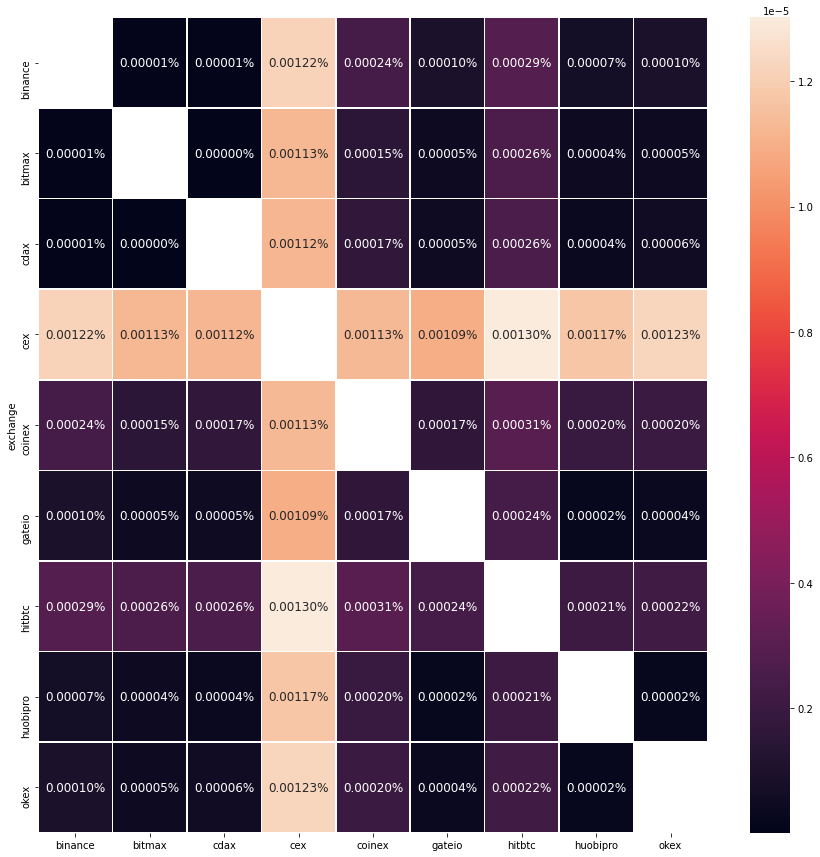

In [ ]:
# Show for ZIL/USDT
fig, ax = plt.subplots(figsize=(15,15))   
piv = pd.pivot_table(zilDfMatrix, index=["exchange"])
sns.heatmap(piv, annot=True, fmt=".5%", annot_kws={"fontsize":12}, linewidths=.5)

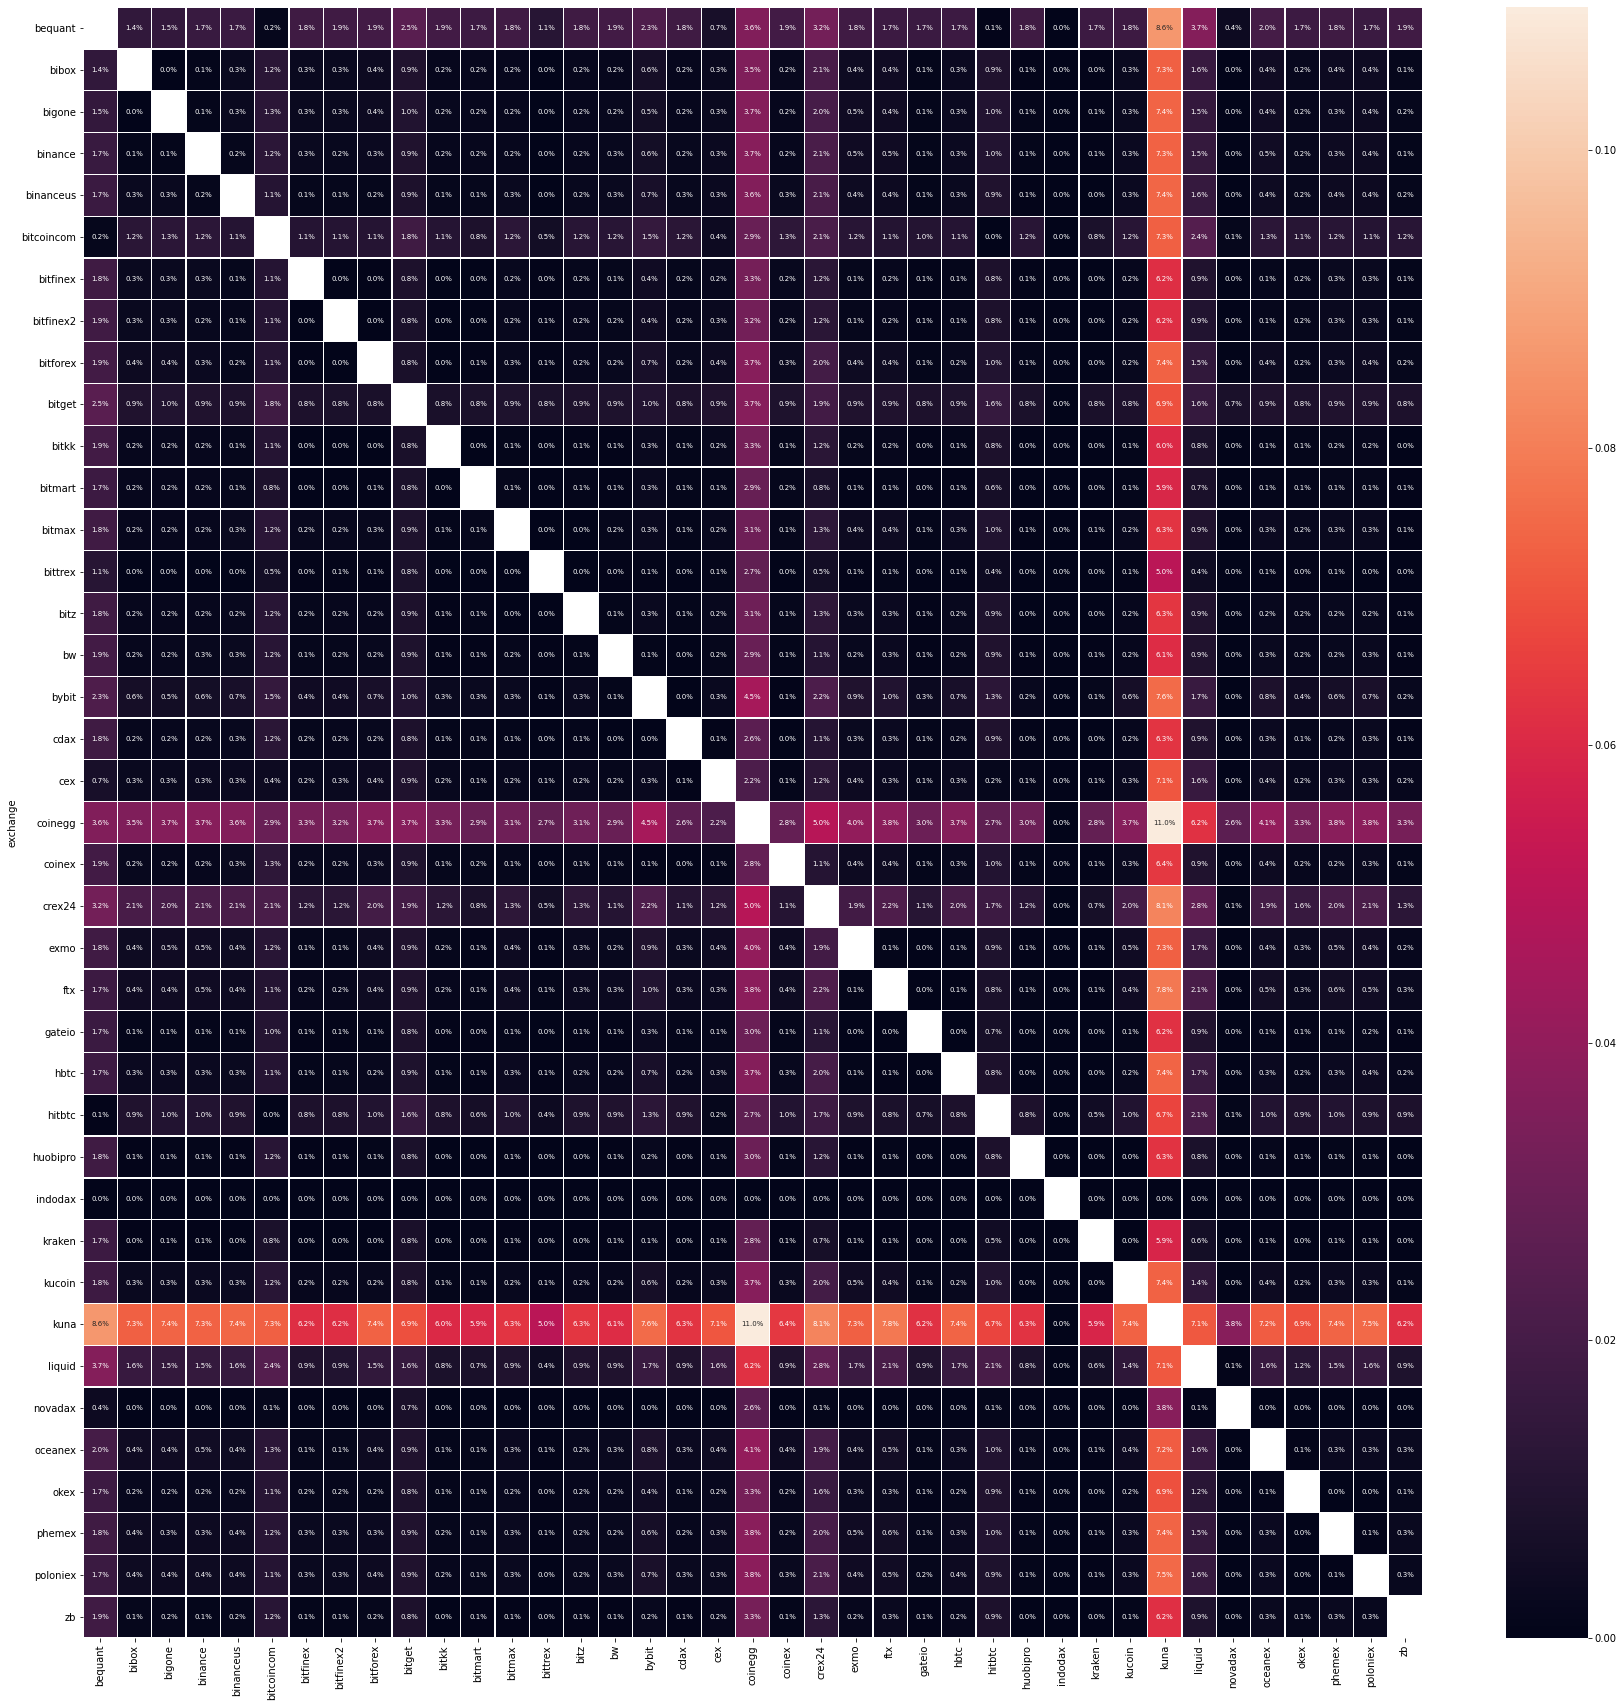

In [ ]:
# Show for ETH/USDT
fig, ax = plt.subplots(figsize=(30,30))  
piv = pd.pivot_table(ethDfMatrix, index=["exchange"])
sns.heatmap(piv, annot=True, fmt=".1%", annot_kws={"fontsize":7}, linewidths=.3)

####  Method 2: Sell at highest bid price and buy at lowest ask price

Function convert_lists_df  converts lists to dataframe for display of results

In [ ]:
def convert_lists_df(listExchange, listExchangeCount):
    # Sort listExchange and listExchangeCount in descending order with respect to listExchangeCount
    listExchangeCount, listExchange = zip(*sorted(zip(listExchangeCount, listExchange), reverse=True))
    # Declare buyExchange list variable - Currrently empty
    buyExchange = []
    # Declare sellExchange list variable - Currrently empty
    sellExchange = []
    # Iterate through the dataset for listExchange to store the 1st element which is the buy exchange into buyExchange and 2nd element which is sell exchange into sellExchange
    for item in listExchange:
        buyExchange.append(item[0])
        sellExchange.append(item[1])
    # Create dataframe to store the buy exchange, sell exchange and their number of opportunities to make a profit
    df = pd.DataFrame(list(zip(buyExchange, sellExchange, listExchangeCount)), columns =['Exchange to buy', 'Exchange to sell', 'Number of opportunities'])
    # Return dataframe to caller
    return df

Function convert_string_datetime converts time in string to datetime format

In [ ]:
def convert_string_datetime(strTime):
    # Pad the month in the datetime string with 0
    strTime="0"+strTime
    # Return the datetime string in datetime format to caller
    return datetime.strptime(strTime, '%m/%d/%Y %H:%M')

Function method_two looks for opportunities to perform an exchange arbitrage using selling at the highest bid price and buying at the lowest bid price

Inputs: list of exchanges, symbol, threshold and dataframe for taker, time, ask and bid

Outputs: summary which is a list variable to be used for summarizing profit percentages and listProfitPercent which is also a list variable to be used for plotting of profit percentage graph

In [ ]:
def method_two(listExchanges, symbol, dfAsk, dfBid, dfTime, dfTaker, threshold):
    # Declare dfAskRows variable to store the number of rows for dataframe dfAsk
    dfAskRows = dfAsk.shape[0]
    # Declare listProfitPercent list variable to store all profit percentages throughout the iteration
    listProfitPercent = []
    # Declare listPairsExchanges list variable to store the pairs of exchanges where their profit percentages that equals or exceed the threshold
    listPairsExchanges = []
    # Declare listPairsExchangesCount list variable to store the number of times each pairs of exchanges' profit percentages equals or exceed the threshold
    listPairsExchangesCount = []
    # Declare profitPercentOneTwo list variable to store profit percentages that equals or exceed 1% and is less than 2%
    profitPercentOneTwo = []
    # Declare profitPercentTwoThree list variable to store profit percentages that equals or exceed 2% and is less than 3%
    profitPercentTwoThree = []
    # Declare profitPercentThreeMore list variable to store profit percentages that equals or exceed 3%
    profitPercentThreeMore = []
    # Declare profitPercentOneTwoCount list variable to store  the number of times each pairs of exchanges' profit percentages that equals or exceed 1% and is less than 2%
    profitPercentOneTwoCount = []
    # Declare profitPercentTwoThreeCount list variable to store  the number of times each pairs of exchanges' profit percentages that equals or exceed 2% and is less than 3%
    profitPercentTwoThreeCount = []
    # Declare profitPercentTwoThreeCount list variable to store  the number of times each pairs of exchanges' profit percentages that equals or exceed 3%
    profitPercentThreeMoreCount = []
    # Declare summary list variable to store variables containing profit percentage information at the end of the iteration
    summary = []

    # Iterate through the rows in ask, bid, taker fees, time 
    for index in range(dfAskRows):
        # Declare timeRequest variable to store the specific recorded time in datetime format
        timeRequest = convert_string_datetime(dfTime.iloc[index][0])
        # Declare highestBid variable to store maximum bid price during each iteration
        highestBid = max(dfBid.iloc[index])
        # Declare highestBidExchange variable to store the exchange for its respective maximum bid price during each iteration
        highestBidExchange = listExchanges[np.argmax(dfBid.iloc[index])]
        # Declare highestBidTaker variable to store the taker fee of the exchange for its respective maximum bid price during each iteration
        highestBidTaker = check_taker_fee(dfTaker.iloc[index][highestBidExchange])

        # Declare lowestAsk variable to store minimum ask price during each iteration
        lowestAsk = min(dfAsk.iloc[index])
        # Declare lowestAskExchange variable to store the exchange for its respective minimum ask price during each iteration
        lowestAskExchange = listExchanges[np.argmin(dfAsk.iloc[index])]
        # Declare lowestAskTaker to store the taker fee of the exchange for its respective minimum ask price during each iteration
        lowestAskTaker = check_taker_fee(dfTaker.iloc[index][lowestAskExchange])

        # If the lowest ask price plus its taker fee is lesser than the highest bid price plus its taker fee
        if lowestAsk * (1 + lowestAskTaker) < highestBid * (1 + highestBidTaker):
            # Declare exchangeBuy variable to store the exchange for its respective minimum ask price during that iteration
            exchangeBuy = lowestAskExchange
            # Declare exchangeSell variable to store the exchange for its respective maximum bid price during that iteration
            exchangeSell = highestBidExchange
            # Declare profit variable to store the difference of lowest ask price plus its taker fee and the highest bid price plus its taker fee
            profit = highestBid * (1 + highestBidTaker) - lowestAsk * (1 + lowestAskTaker) 
            # Declare profitPercent variable to store the percentage of profit to the lowest ask price
            profitPercent = profit / lowestAsk * 100
            # If profitPercent is equal or higher than threshold
            if profitPercent >= threshold:
                # Display which exchange to buy and which exchange to sell on the date and time for that iteration along with their prices
                print("On "+ timeRequest.strftime("%d-%b-%Y %I:%M%p") +', buy ' + symbol + ' at ' + exchangeBuy + ' for '+ str(lowestAsk) + ' and sell ' + symbol + ' from ' + exchangeSell + ' at ' + str(highestBid)) 
                # Display the profit percentage for that iteration
                print('You get a profit % of approximately ' + str(profitPercent) + '%')
                # Declare pairExchanges list variable to store the exchange to buy and which exchange to sell that allow the profit percentage to exceed the threshold
                pairExchanges = [exchangeBuy, exchangeSell]
                # If pairExchanges does not exist in listPairsExchanges
                if pairExchanges not in listPairsExchanges:
                    # Add pairExchanges to listPairsExchanges 
                    listPairsExchanges.append(pairExchanges)
                    # Add a value of 1 as a new element to listPairsExchangesCount, this value of 1 will have the same index in listPairsExchangesCount as the index for pairExchanges in listPairsExchanges
                    listPairsExchangesCount.append(1)
                # If pairExchanges exists in listPairsExchanges 
                else:
                    # Search and store the index of pairExchanges in listPairsExchanges
                    listPairsExchangesIndex = listPairsExchanges.index(pairExchanges)
                    # Search for the value with the same index in listPairsExchangesCount and increment the value by 1
                    listPairsExchangesCount[listPairsExchangesIndex] += 1

                # If profitPercent equal or more than 1% and less than 2%
                if  profitPercent >= 1 and profitPercent < 2:
                    # If pairExchanges does not exist in profitPercentOneTwo
                    if pairExchanges not in profitPercentOneTwo:
                        # Add pairExchanges to profitPercentOneTwo 
                        profitPercentOneTwo.append(pairExchanges)
                        # Add a value of 1 as a new element to profitPercentOneTwoCount, this value of 1 will have the same index in profitPercentOneTwoCount as the index for pairExchanges in profitPercentOneTwo
                        profitPercentOneTwoCount.append(1)
                    # If pairExchanges exists in profitPercentOneTwo 
                    else:
                        # Search and store the index of pairExchanges in profitPercentOneTwo
                        profitPercentOneTwoIndex = profitPercentOneTwo.index(pairExchanges)
                        # Search for the value with the same index in profitPercentOneTwoCount and increment the value by 1
                        profitPercentOneTwoCount[profitPercentOneTwoIndex] += 1

                # If profitPercent equal or more than 2% and less than 3%
                elif  profitPercent >= 2 and profitPercent < 3:
                    # If pairExchanges does not exist in profitPercentTwoThree
                    if pairExchanges not in profitPercentTwoThree:
                        # Add pairExchanges to profitPercentTwoThree 
                        profitPercentTwoThree.append(pairExchanges)
                        # Add a value of 1 as a new element to profitPercentTwoThreeCount, this value of 1 will have the same index in profitPercentTwoThreeCount as the index for pairExchanges in profitPercentTwoThree
                        profitPercentTwoThreeCount.append(1)
                    # If pairExchanges exists in profitPercentTwoThree 
                    else:
                        # Search and store the index of pairExchanges in profitPercentTwoThree
                        profitPercentTwoThreeIndex = profitPercentTwoThree.index(pairExchanges)
                        # Search for the value with the same index in profitPercentTwoThreeCount and increment the value by 1
                        profitPercentTwoThreeCount[profitPercentTwoThreeIndex] += 1

                # If profitPercent equal or more than 3%
                elif  profitPercent >= 3:
                    # If pairExchanges does not exist in profitPercentThreeMore
                    if pairExchanges not in profitPercentThreeMore:
                        # Add pairExchanges to profitPercentThreeMore 
                        profitPercentThreeMore.append(pairExchanges)
                        # Add a value of 1 as a new element to profitPercentThreeMoreCount, this value of 1 will have the same index in profitPercentThreeMoreCount as the index for pairExchanges in profitPercentThreeMore
                        profitPercentThreeMoreCount.append(1)
                    # If pairExchanges exists in profitPercentThreeMore     
                    else:
                        # Search and store the index of pairExchanges in profitPercentThreeMore
                        profitPercentThreeMoreIndex = profitPercentThreeMore.index(pairExchanges)
                        # Search for the value with the same index in profitPercentThreeMoreCount and increment the value by 1
                        profitPercentThreeMoreCount[profitPercentThreeMoreIndex] += 1
        # Set profitPercent to 0 if the lowest ask price plus its taker fee is equal or higher than the highest bid price plus its taker fee
        else:
            profitPercent = 0
        # Store profitPercent in listProfitPercent after each iteration
        listProfitPercent.append(profitPercent)

    # Store variables containing profit percentage information in list variable summary at the end of the iteration
    summary = [[listPairsExchanges, listPairsExchangesCount], [profitPercentThreeMore, profitPercentThreeMoreCount], 
    [profitPercentTwoThree, profitPercentTwoThreeCount], [profitPercentOneTwo, profitPercentOneTwoCount]]
    # Return summary and listProfitPercent to caller
    return summary, listProfitPercent

Plot the profit percentage graph over time

In [ ]:
def plot_profit_percent(dfTime, y, symbol):
    #  declare x list variable to store the x coordinates for the graph
    x = []
    # Declare dfTimeRows variable to store the number of rows for dataframe dfTime
    dfTimeRows = dfTime.shape[0]
    # Iterate through the rows of the dataframe for time
    for index in range(dfTimeRows):
        # store each of the time in dataframe in datetime format
        x.append(convert_string_datetime(dfTime.iloc[index][0]))

    fig, ax = plt.subplots(figsize=(15,8))
    # Rotate and right align the x labels of the graph
    fig.autofmt_xdate()
    # Display grids on the graph
    plt.grid()
    # Specify and set the format for the x labels to appear on the graph
    xfmt = mdates.DateFormatter('%d-%b-%y %I:%M%p')
    ax.xaxis.set_major_formatter(xfmt)
    # plot the points  
    plt.plot(x, y) 
    # naming the x axis 
    plt.xlabel('Date and Time') 
    # naming the y axis 
    plt.ylabel('Profit (%)') 
    # giving a title to the graph 
    plt.title('Profit Percentage For '+ symbol) 

Get arbitrage results for ZIL/USDT

In [ ]:
symbol = 'ZIL/USDT'
zilTwoResultsSummary, zilTwoResultsGraph  = method_two(zilExchanges, symbol, dfZilAsk, dfZilBid, dfZilTime, dfZilTaker, 1)

On 25-Feb-2021 10:56PM, buy ZIL/USDT at coinex for 0.121 and sell ZIL/USDT from cex at 0.12219000000000001
You get a profit % of approximately 1.035929752066119%
On 25-Feb-2021 11:17PM, buy ZIL/USDT at coinex for 0.121 and sell ZIL/USDT from cdax at 0.12247899999999999
You get a profit % of approximately 1.2247586776859434%
On 25-Feb-2021 11:19PM, buy ZIL/USDT at coinex for 0.121 and sell ZIL/USDT from huobipro at 0.122225
You get a profit % of approximately 1.0144214876032984%
On 26-Feb-2021 12:17AM, buy ZIL/USDT at coinex for 0.12300000000000001 and sell ZIL/USDT from cdax at 0.124231
You get a profit % of approximately 1.0028146341463338%
On 26-Feb-2021 12:43AM, buy ZIL/USDT at hitbtc for 0.12172390000000001 and sell ZIL/USDT from binance at 0.12375
You get a profit % of approximately 1.516169174664947%
On 26-Feb-2021 12:45AM, buy ZIL/USDT at hitbtc for 0.12206929999999999 and sell ZIL/USDT from huobipro at 0.123546
You get a profit % of approximately 1.1621421192716082%
On 26-Feb-2

Show summary of the number of opportunities that exceed the threshold of making profit of 1% or more  in descending order for ZIL/USDT

In [ ]:
print("Number of opportunities that exceeded the threshold of making profit of 1% or more  with " + symbol)
dfSummary = convert_lists_df(zilTwoResultsSummary[0][0], zilTwoResultsSummary[0][1])
# Display the top 10
dfSummary.head(10)

Number of opportunities that exceeded the threshold of making profit of 1% or more  with ZIL/USDT


,Exchange to buy,Exchange to sell,Number of opportunities
0,hitbtc,binance,32
1,hitbtc,huobipro,13
2,hitbtc,cex,13
3,hitbtc,cdax,9
4,coinex,cex,8
5,binance,cex,6
6,hitbtc,coinex,5
7,coinex,cdax,3
8,okex,cex,2
9,huobipro,cex,2


More information about the profit percentage range for ZIL/USDT

In [ ]:
# If there are pair of exchanges that get a profit percentage of 3% or more
if len(zilTwoResultsSummary[1][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentThreeMore = convert_lists_df(zilTwoResultsSummary[1][0], zilTwoResultsSummary[1][1])
    print("Opportunities to get profit of 3% or more with " + symbol)
    print(dfpercentThreeMore.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit of 3% or more with " + symbol)
print("\n")

# If there are pair of exchanges that get a profit percentage of 2% or more and less than 3%
if len(zilTwoResultsSummary[2][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentTwoThree = convert_lists_df(zilTwoResultsSummary[2][0], zilTwoResultsSummary[2][1])
    print("Opportunities to get profit between 2% and 3% with " + symbol)
    print(dfpercentTwoThree.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit between 2% and 3% with " + symbol)
print("\n")

# If there are pair of exchanges that get a profit percentage of 1% or more and less than 2%
if len(zilTwoResultsSummary[3][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentOneTwo = convert_lists_df(zilTwoResultsSummary[3][0], zilTwoResultsSummary[3][1])
    print("Opportunities to get profit between 1% and 2% with " + symbol)
    print(dfpercentOneTwo.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit between 1% and 2% with " + symbol)

Opportunities to get profit of 3% or more with ETH/USDT
  Exchange to buy Exchange to sell  Number of opportunities
0          hitbtc          binance                        2


Opportunities to get profit between 2% and 3% with ETH/USDT
  Exchange to buy Exchange to sell  Number of opportunities
0          hitbtc          binance                        4
1          hitbtc              cex                        3
2          hitbtc             cdax                        1


Opportunities to get profit between 1% and 2% with ETH/USDT
  Exchange to buy Exchange to sell  Number of opportunities
0          hitbtc          binance                       26
1          hitbtc         huobipro                       13
2          hitbtc              cex                       10
3          hitbtc             cdax                        8
4          coinex              cex                        8


Plot the profit percentage graph for ZIL/USDT

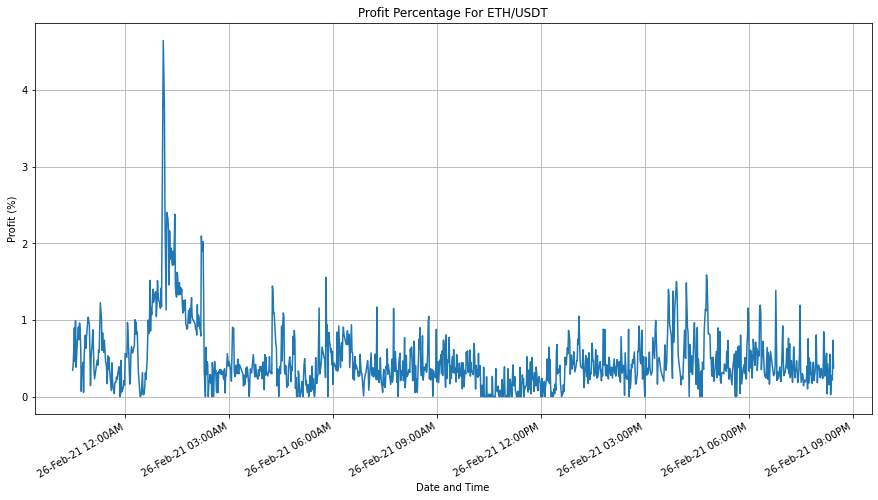

In [ ]:
plot_profit_percent(dfZilTime, zilTwoResultsGraph, symbol)

Get arbitrage results for ETH/USDT

In [ ]:
symbol = 'ETH/USDT'
ethTwoResultsSummary, ethTwoResultsGraph  = method_two(ethExchanges, symbol, dfEthAsk, dfEthBid, dfEthTime, dfEthTaker, 1)

On 25-Feb-2021 10:27PM, buy ETH/USDT at bitget for 1628.63 and sell ETH/USDT from indodax at 1640.816326
You get a profit % of approximately 30.77273314380796%
On 25-Feb-2021 10:28PM, buy ETH/USDT at huobipro for 1628.84 and sell ETH/USDT from indodax at 1640.816326
You get a profit % of approximately 30.755847339210728%
On 25-Feb-2021 10:31PM, buy ETH/USDT at oceanex for 1630.32 and sell ETH/USDT from indodax at 1640.816326
You get a profit % of approximately 30.736965982138486%
On 25-Feb-2021 10:32PM, buy ETH/USDT at gateio for 1633.42 and sell ETH/USDT from indodax at 1640.816326
You get a profit % of approximately 30.38865593662376%
On 25-Feb-2021 10:35PM, buy ETH/USDT at bibox for 1635.98 and sell ETH/USDT from indodax at 1640.816326
You get a profit % of approximately 30.284309331409926%
On 25-Feb-2021 10:36PM, buy ETH/USDT at bitmart for 1637.0 and sell ETH/USDT from indodax at 1640.816326
You get a profit % of approximately 30.053068039095905%
On 25-Feb-2021 10:37PM, buy ETH/US

Show summary of the number of opportunities that exceed the threshold of making profit of 1% or more  in descending order for ETH/USDT

In [ ]:
print("Number of opportunities that exceeded the threshold of making profit of 1% or more  with " + symbol)
dfSummary = convert_lists_df(ethTwoResultsSummary[0][0], ethTwoResultsSummary[0][1])
# Display the top 10
dfSummary.head(10)

Number of opportunities that exceeded the threshold of making profit of 1% or more  with ETH/USDT


,Exchange to buy,Exchange to sell,Number of opportunities
0,bequant,indodax,106
1,bitcoincom,indodax,101
2,hitbtc,indodax,88
3,bibox,indodax,61
4,okex,indodax,39
5,cdax,indodax,28
6,kucoin,indodax,21
7,binance,indodax,21
8,coinex,indodax,20
9,oceanex,indodax,16


More information about the profit percentage range for ETH/USDT

In [ ]:
# If there are pair of exchanges that get a profit percentage of 3% or more
if len(ethTwoResultsSummary[1][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentThreeMore = convert_lists_df(ethTwoResultsSummary[1][0], ethTwoResultsSummary[1][1])
    print("Opportunities to get profit of 3% or more with " + symbol)
    print(dfpercentThreeMore.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit of 3% or more with " + symbol)
print("\n")

# If there are pair of exchanges that get a profit percentage of 2% or more and less than 3%
if len(ethTwoResultsSummary[2][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentTwoThree = convert_lists_df(ethTwoResultsSummary[2][0], ethTwoResultsSummary[2][1])
    print("Opportunities to get profit between 2% and 3% with " + symbol)
    print(dfpercentTwoThree.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit between 2% and 3% with " + symbol)
print("\n")

# If there are pair of exchanges that get a profit percentage of 1% or more and less than 2%
if len(ethTwoResultsSummary[3][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentOneTwo = convert_lists_df(ethTwoResultsSummary[3][0], ethTwoResultsSummary[3][1])
    print("Opportunities to get profit between 1% and 2% with " + symbol)
    print(dfpercentOneTwo.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit between 1% and 2% with " + symbol)

Opportunities to get profit of 3% or more with ETH/USDT
  Exchange to buy Exchange to sell  Number of opportunities
0         bequant          indodax                      106
1      bitcoincom          indodax                      101
2          hitbtc          indodax                       88
3           bibox          indodax                       61
4            okex          indodax                       39


No opportunities to get profit between 2% and 3% with ETH/USDT


Opportunities to get profit between 1% and 2% with ETH/USDT
  Exchange to buy Exchange to sell  Number of opportunities
0      bitcoincom           bitmax                        1


Plot the profit percentage graph for ETH/USDT

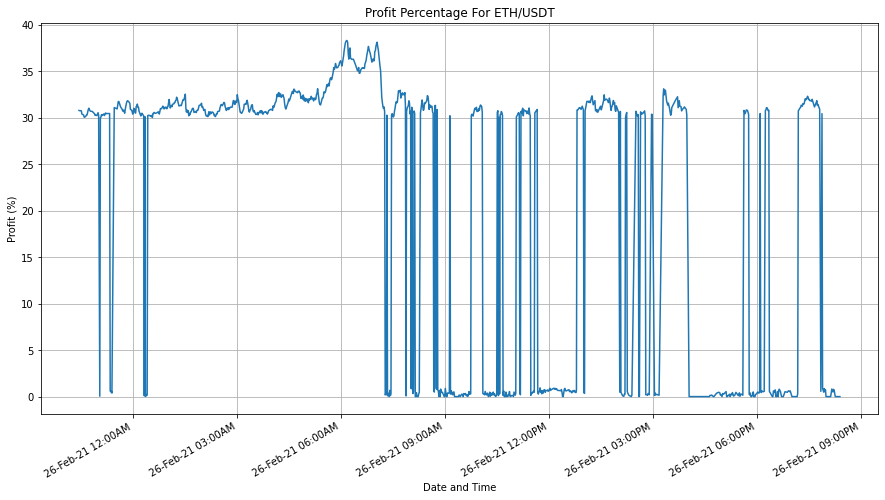

In [ ]:
plot_profit_percent(dfEthTime, ethTwoResultsGraph, symbol)

It can be observed that the profit percentage for ETH/USDT is much higher (~30%) generally than ZIL/USDT. There is also a prolonged period in ETH/USDT profit percentage graph where one can make a high profit which make us question the result since cryptocurrency market is prone to change wildly from one second to the next.

As we are using data from actual exchanges, there is an [article](https://www.trality.com/blog/crypto-arbitrage-strategy) that mentioned that there are exchanges that will put extremely low prices for their cryptocurrency and disappear after you made payment to buy from them. One way to check is through the volume as the volume of the cryptocurrency should be changing a few times a day if people are really selling or buying from the exchange. Hence, lets take a closer look at the ask volume for bequant since its is one of the exchanges with the highest number of opportunities crossing the threshold.


In [ ]:
dfEthAskVolume["bequant"]

0       None
1       None
2       None
3       None
4       None
        ... 
1037    None
1038    None
1039    None
1040    None
1041    None
Name: bequant, Length: 1042, dtype: object

We can see now that there is no volume for bequant exchange to sell to us in the event we purchased it. To resolve this issue, we will be selecting only exchanges with valid values for the ask and bid volume. Here is a sample of the ask volume we have been using which can you see that there is a lot of exchanges with None values.

In [ ]:
dfEthAskVolume

,kuna,exmo,bitmart,liquid,bw,ftx,oceanex,bittrex,hbtc,bequant,bybit,huobipro,kraken,poloniex,cdax,bitcoincom,binanceus,bitkk,bitfinex2,binance,novadax,bitfinex,cex,crex24,bitget,zb,coinegg,bibox,kucoin,bigone,hitbtc,bitmax,bitz,indodax,coinex,okex,bitforex,gateio,phemex
0,None,None,0.19261,None,None,None,None,None,None,None,None,1.7102,None,None,9.006600,None,1.14870,None,None,27.61106,None,None,None,None,15.5321,None,None,None,None,2.31131,None,1.800,1.2860,None,None,0.360000,None,None,None
1,None,None,13.60275,None,None,None,None,None,None,None,None,1.5000,None,None,13.297700,None,2.57433,None,None,27.36000,None,None,None,None,0.4000,None,None,None,None,2.31131,None,0.080,1.2234,None,None,1.111800,None,None,None
2,None,None,12.80382,None,None,None,None,None,None,None,None,0.1302,None,None,1.120224,None,3.97625,None,None,5.00000,None,None,None,None,0.6191,None,None,None,None,2.31131,None,1.912,2.8454,None,None,2.640000,None,None,None
3,None,None,3.30356,None,None,None,None,None,None,None,None,0.0848,None,None,1.074100,None,0.50000,None,None,7.03460,None,None,None,None,0.4621,None,None,None,None,2.31131,None,0.087,6.3736,None,None,13.414083,None,None,None
4,None,None,6.62293,None,None,None,None,None,None,None,None,1.6867,None,None,6.730600,None,1.30000,None,None,9.53350,None,None,None,None,0.6409,None,None,None,None,0.01099,None,4.243,4.6972,None,None,0.300000,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,None,None,0.19868,None,None,None,None,None,None,None,None,2.4750,None,None,0.725600,None,0.02769,None,None,0.02000,None,None,None,None,0.4046,None,None,None,None,2.31131,None,1.240,0.2904,None,None,0.300000,None,None,None
1038,None,None,0.15438,None,None,None,None,None,None,None,None,3.7464,None,None,5.150600,None,3.16257,None,None,6.08446,None,None,None,None,3.5735,None,None,None,None,2.31131,None,1.891,4.9600,None,None,13.925000,None,None,None
1039,None,None,0.23369,None,None,None,None,None,None,None,None,0.5000,None,None,15.800000,None,0.01918,None,None,15.00000,None,None,None,None,4.8007,None,None,None,None,2.31131,None,2.480,2.7349,None,None,0.937198,None,None,None
1040,None,None,0.17431,None,None,None,None,None,None,None,None,0.4963,None,None,1.061100,None,2.58883,None,None,2.76706,None,None,None,None,1.9411,None,None,None,None,2.31131,None,0.990,0.6460,None,None,2.844517,None,None,None


Now we will proceed to use this code below to select only those exchanges with valid values for ask and volume, then store their data in new dataframes.

In [ ]:
# Declare newEthExchanges list variable to store exchanges with valid values for ask and bid volume for ETH/USDT
newEthExchanges = []
# Get the names exchanges with valid values for ask volume as the exchanges with valid values for bid volume is the same as ask volume
for col in dfEthAskVolume.describe().columns:
    # Store the exchange name in newEthExchanges
    newEthExchanges.append(col)
# Declare newDfEthAsk dataframe to store the new exchanges' data in dfEthAsk
newDfEthAsk = dfEthAsk[newEthExchanges].copy()
# Declare newDfEthBid dataframe to store the new exchanges' data in dfEthBid
newDfEthBid  = dfEthBid[newEthExchanges].copy()
# Declare newDfEthBid dataframe to store the new exchanges' data in dfEthBid
newDfEthTime  = dfEthTime[newEthExchanges].copy()
# Declare newDfEthTaker dataframe to store the new exchanges' data in dfEthTaker
newDfEthTaker = dfEthTaker[newEthExchanges].copy()
# Declare newDfEthAskVolume dataframe to store the new exchanges' data in dfEthAskVolume
newDfEthAskVolume  = dfEthAskVolume[newEthExchanges].copy()
# Declare newDfEthBidVolume dataframe to store the new exchanges' data in dfEthBidVolume
newDfEthBidVolume = dfEthBidVolume[newEthExchanges].copy()


# Declare newZilExchanges list variable to store exchanges with valid values for ask and bid volume for ZIL/USDT
newZilExchanges = []
# Get the names exchanges with valid values for ask volume as the exchanges with valid values for bid volume is the same as ask volume
for col in dfZilAskVolume.describe().columns:
    # Store the exchange name in newZilExchanges
    newZilExchanges.append(col)
# Declare newDfZilAsk dataframe to store the new exchanges' data in dfZilAsk
newDfZilAsk = dfZilAsk[newZilExchanges].copy() 
# Declare newDfZilBid dataframe to store the new exchanges' data in dfZilBid
newDfZilBid = dfZilBid[newZilExchanges].copy() 
# Declare newDfZilAskVolume dataframe to store the new exchanges' data in dfZilAskVolume
newDfZilAskVolume = dfZilAskVolume[newZilExchanges].copy()
# Declare newDfZilBidVolume dataframe to store the new exchanges' data in dfZilBidVolume
newDfZilBidVolume = dfZilBidVolume[newZilExchanges].copy() 
# Declare newDfZilTaker dataframe to store the new exchanges' data in dfZilTaker
newDfZilTaker = dfZilTaker[newZilExchanges].copy()
# Declare newDfZilTime dataframe to store the new exchanges' data in dfZilTime
newDfZilTime  = dfZilTime[newZilExchanges].copy() 

Inspection of the new dataframe of ask volume for ETH/USDT

In [ ]:
newDfEthAskVolume

,bitmart,huobipro,cdax,binanceus,binance,bitget,bigone,bitmax,bitz,okex
0,0.19261,1.7102,9.006600,1.14870,27.61106,15.5321,2.31131,1.800,1.2860,0.360000
1,13.60275,1.5000,13.297700,2.57433,27.36000,0.4000,2.31131,0.080,1.2234,1.111800
2,12.80382,0.1302,1.120224,3.97625,5.00000,0.6191,2.31131,1.912,2.8454,2.640000
3,3.30356,0.0848,1.074100,0.50000,7.03460,0.4621,2.31131,0.087,6.3736,13.414083
4,6.62293,1.6867,6.730600,1.30000,9.53350,0.6409,0.01099,4.243,4.6972,0.300000
...,...,...,...,...,...,...,...,...,...,...
1037,0.19868,2.4750,0.725600,0.02769,0.02000,0.4046,2.31131,1.240,0.2904,0.300000
1038,0.15438,3.7464,5.150600,3.16257,6.08446,3.5735,2.31131,1.891,4.9600,13.925000
1039,0.23369,0.5000,15.800000,0.01918,15.00000,4.8007,2.31131,2.480,2.7349,0.937198
1040,0.17431,0.4963,1.061100,2.58883,2.76706,1.9411,2.31131,0.990,0.6460,2.844517


It can be observed now that the new dataframes are exchanges that have valid values for ask and bid volume. Lets run the test again now for ETH/USDT and AZIL/USDT.

Arbitrage results for AZIL/USDT new dataframes

In [ ]:
symbol = 'ZIL/USDT'
zilTwoResultsSummary, zilTwoResultsGraph  = method_two(newZilExchanges, symbol, newDfZilAsk, newDfZilBid, newDfZilTime, newDfZilTaker, 0.5)

On 26-Feb-2021 12:05AM, buy ZIL/USDT at binance for 0.12275 and sell ZIL/USDT from huobipro at 0.12365699999999999
You get a profit % of approximately 0.8403780040733188%
On 26-Feb-2021 02:01AM, buy ZIL/USDT at binance for 0.1181 and sell ZIL/USDT from huobipro at 0.118647
You get a profit % of approximately 0.5640931414056077%
On 26-Feb-2021 04:31AM, buy ZIL/USDT at binance for 0.11652 and sell ZIL/USDT from huobipro at 0.117097
You get a profit % of approximately 0.5961843460350447%
On 26-Feb-2021 06:12AM, buy ZIL/USDT at binance for 0.11012999999999999 and sell ZIL/USDT from huobipro at 0.110597
You get a profit % of approximately 0.5248923998910533%
On 26-Feb-2021 06:18AM, buy ZIL/USDT at okex for 0.11167 and sell ZIL/USDT from cdax at 0.112381
You get a profit % of approximately 0.6879708068415693%
On 26-Feb-2021 07:45AM, buy ZIL/USDT at huobipro for 0.10979000000000001 and sell ZIL/USDT from cdax at 0.11043499999999999
You get a profit % of approximately 0.5886601694143181%
On 26

In [ ]:
# Show summary of the number of opportunities that exceed the threshold of making profit of 0.5% or more  in descending order for ZIL/USDT
print("Number of opportunities that exceeded the threshold of making profit of 0.5% or more with " + symbol)
dfSummary = convert_lists_df(zilTwoResultsSummary[0][0], zilTwoResultsSummary[0][1])
# Display first 5
dfSummary.head()

Number of opportunities that exceeded the threshold of making profit of 0.5% or more with ZIL/USDT


,Exchange to buy,Exchange to sell,Number of opportunities
0,huobipro,cdax,6
1,binance,huobipro,5
2,okex,cdax,2
3,okex,binance,1
4,cdax,huobipro,1


In [ ]:
# More information about the profit percentage range for ZIL/USDT
# If there are pair of exchanges that get a profit percentage of 3% or more
if len(zilTwoResultsSummary[1][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentThreeMore = convert_lists_df(zilTwoResultsSummary[1][0], zilTwoResultsSummary[1][1])
    print("Opportunities to get profit of 3% or more with " + symbol)
    print(dfpercentThreeMore.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit of 3% or more with " + symbol)
print("\n")

# If there are pair of exchanges that get a profit percentage of 2% or more and less than 3%
if len(zilTwoResultsSummary[2][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentTwoThree = convert_lists_df(zilTwoResultsSummary[2][0], zilTwoResultsSummary[2][1])
    print("Opportunities to get profit between 2% and 3% with " + symbol)
    print(dfpercentTwoThree.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit between 2% and 3% with " + symbol)
print("\n")

# If there are pair of exchanges that get a profit percentage of 1% or more and less than 2%
if len(zilTwoResultsSummary[3][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentOneTwo = convert_lists_df(zilTwoResultsSummary[3][0], zilTwoResultsSummary[3][1])
    print("Opportunities to get profit between 1% and 2% with " + symbol)
    print(dfpercentOneTwo.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit between 1% and 2% with " + symbol)

No opportunities to get profit of 3% or more with ETH/USDT


No opportunities to get profit between 2% and 3% with ETH/USDT


Opportunities to get profit between 1% and 2% with ETH/USDT
  Exchange to buy Exchange to sell  Number of opportunities
0         binance             cdax                        1


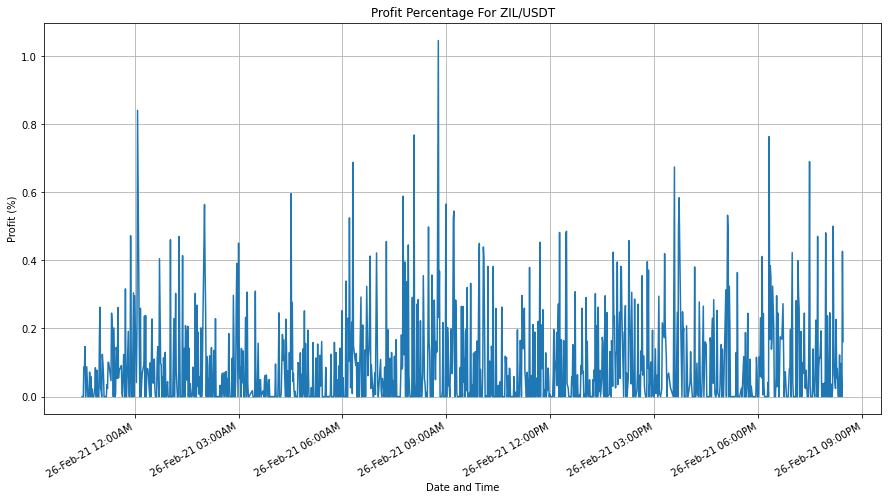

In [ ]:
plot_profit_percent(dfZilTime, zilTwoResultsGraph, symbol)

Arbitrage results for ETH/USDT new dataframes

In [ ]:
symbol = 'ETH/USDT'
ethTwoResultsSummary, ethTwoResultsGraph  = method_two(newEthExchanges, symbol, newDfEthAsk, newDfEthBid, newDfEthTime, newDfEthTaker, 0.5)

On 26-Feb-2021 06:12AM, buy ETH/USDT at binanceus for 1503.88 and sell ETH/USDT from bitmax at 1510.52
You get a profit % of approximately 0.5424076389073731%
On 26-Feb-2021 06:16AM, buy ETH/USDT at cdax for 1509.06 and sell ETH/USDT from bitmax at 1519.05
You get a profit % of approximately 0.6633255138960705%
On 26-Feb-2021 07:16AM, buy ETH/USDT at bitmart for 1511.88 and sell ETH/USDT from cdax at 1520.52
You get a profit % of approximately 0.5226168743551154%
On 26-Feb-2021 07:45AM, buy ETH/USDT at okex for 1476.46 and sell ETH/USDT from cdax at 1483.35
You get a profit % of approximately 0.517590046462471%
On 26-Feb-2021 07:49AM, buy ETH/USDT at cdax for 1462.7 and sell ETH/USDT from bitget at 1470.87
You get a profit % of approximately 0.5596732070827747%
On 26-Feb-2021 07:55AM, buy ETH/USDT at binanceus for 1473.31 and sell ETH/USDT from binance at 1481.97
You get a profit % of approximately 0.5883799064691101%
On 26-Feb-2021 07:59AM, buy ETH/USDT at bitget for 1467.99 and sell 

In [ ]:
# Show summary of the number of opportunities that exceed the threshold of making profit of 0.5% or more  in descending order for ETH/USDT
print("Number of opportunities that exceeded the threshold of making profit of 0.5% or more with " + symbol)
dfSummary = convert_lists_df(ethTwoResultsSummary[0][0], ethTwoResultsSummary[0][1])
# Display first 5
dfSummary.head()

Number of opportunities that exceeded the threshold of making profit of 0.5% or more with ETH/USDT


,Exchange to buy,Exchange to sell,Number of opportunities
0,okex,cdax,3
1,bitget,cdax,3
2,okex,huobipro,2
3,cdax,bitmax,2
4,okex,bitz,1


In [ ]:
# More information about the profit percentage range for ETH/USDT
# If there are pair of exchanges that get a profit percentage of 3% or more
if len(ethTwoResultsSummary[1][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentThreeMore = convert_lists_df(ethTwoResultsSummary[1][0], ethTwoResultsSummary[1][1])
    print("Opportunities to get profit of 3% or more with " + symbol)
    print(dfpercentThreeMore.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit of 3% or more with " + symbol)
print("\n")

# If there are pair of exchanges that get a profit percentage of 2% or more and less than 3%
if len(ethTwoResultsSummary[2][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentTwoThree = convert_lists_df(ethTwoResultsSummary[2][0], ethTwoResultsSummary[2][1])
    print("Opportunities to get profit between 2% and 3% with " + symbol)
    print(dfpercentTwoThree.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit between 2% and 3% with " + symbol)
print("\n")

# If there are pair of exchanges that get a profit percentage of 1% or more and less than 2%
if len(ethTwoResultsSummary[3][0]) > 0:
    # Display the name of the exchanges and number of times their profit percentage fulfills the condition
    dfpercentOneTwo = convert_lists_df(ethTwoResultsSummary[3][0], ethTwoResultsSummary[3][1])
    print("Opportunities to get profit between 1% and 2% with " + symbol)
    print(dfpercentOneTwo.head())
else:
    # Display no exchanges' profit percentage fulfills the condition
    print("No opportunities to get profit between 1% and 2% with " + symbol)

No opportunities to get profit of 3% or more with ETH/USDT


No opportunities to get profit between 2% and 3% with ETH/USDT


No opportunities to get profit between 1% and 2% with ETH/USDT


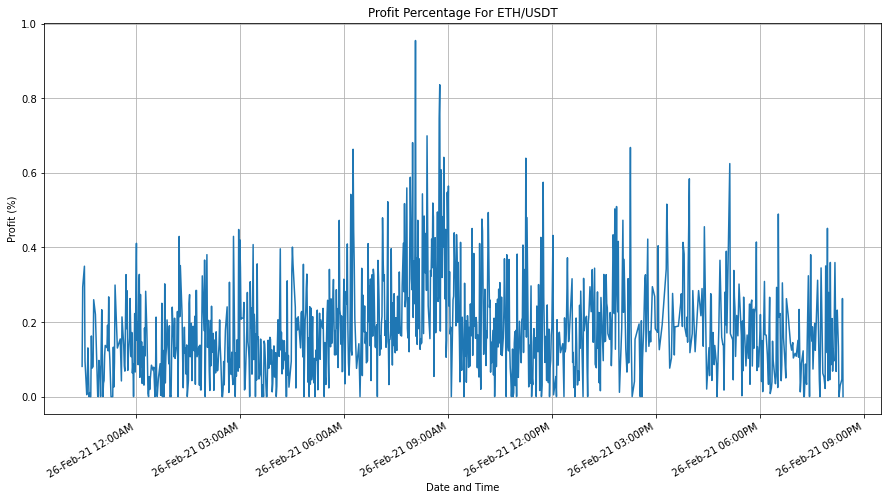

In [ ]:
plot_profit_percent(dfEthTime, ethTwoResultsGraph, symbol)

It can be observed from the plotted profit percentage graphs for ETH/USDT and AZIL/USDT using the new dataframes their profit percentage is from 0% to approximately 1% and their waveform is erratic. Hence, it further supports that the cryptocurrency market is prone to change wildly from one second to the next which is not ideal for exchange arbitrage at all .

Now that we understand the data better, lets modify the function method_two to simulate trading during that period we collected the data.

Function enchance_method_two looks for the opportunities to perform an arbitrage exchange while considering the bid and ask volume. It is important to consider the bid and ask volume to ensure that there is enough volume to effectively execute the trade on the respective exchange.

Inputs: list of exchanges, symbol, threshold and dataframe for taker, time, ask, bid, bid volume and ask volume

Outputs: summary which is a list variable to be used for summarizing profit percentages, listProfitPercent which is a list variable to be used for plotting of profit percentage graph, listProfit which is a list variable to show the amount of USDT made and capital which is the final capital after profits were added to the initial capital


In [ ]:
def enhance_method_two(listExchanges, symbol, dfAsk, dfBid, dfTime, dfTaker, dfAskVolume, dfBidVolume, threshold):
    # Declare dfAskRows variable to store the number of rows for dataframe dfAsk
    dfAskRows = dfAsk.shape[0]
    # Declare listProfitPercent list variable to store all profit percentages throughout the iteration
    listProfitPercent = []
    # Declare listPairsExchanges list variable to store the pairs of exchanges where their profit percentages that equals or exceed the threshold
    listPairsExchanges = []
    # Declare listPairsExchangesCount list variable to store the number of times each pairs of exchanges' profit percentages equals or exceed the threshold
    listPairsExchangesCount = []
    # Declare profitPercentOneTwo list variable to store profit percentages that equals or exceed 1% and is less than 2%
    profitPercentOneTwo = []
    # Declare profitPercentTwoThree list variable to store profit percentages that equals or exceed 2% and is less than 3%
    profitPercentTwoThree = []
    # Declare profitPercentThreeMore list variable to store profit percentages that equals or exceed 3%
    profitPercentThreeMore = []
    # Declare profitPercentOneTwoCount list variable to store  the number of times each pairs of exchanges' profit percentages that equals or exceed 1% and is less than 2%
    profitPercentOneTwoCount = []
    # Declare profitPercentTwoThreeCount list variable to store  the number of times each pairs of exchanges' profit percentages that equals or exceed 2% and is less than 3%
    profitPercentTwoThreeCount = []
    # Declare profitPercentTwoThreeCount list variable to store  the number of times each pairs of exchanges' profit percentages that equals or exceed 3%
    profitPercentThreeMoreCount = []
    # Declare summary list variable to store variables containing profit percentage information at the end of the iteration
    summary = []
    # Declare capital list variable to store 100,000 USDT as the intial capital amount
    capital = 100000
    # Declare listProfit list variable to store all profit throughout the iteration
    listProfit = []

    # Iterate through the rows in ask, bid, taker fees, time 
    for index in range(dfAskRows):
        # Declare timeRequest variable to store the specific recorded time in datetime format
        timeRequest = convert_string_datetime(dfTime.iloc[index][0])
        # Declare highestBid variable to store maximum bid price during each iteration
        highestBid = max(dfBid.iloc[index])
        # Declare highestBidExchange variable to store the exchange for its respective maximum bid price during each iteration
        highestBidExchange = listExchanges[np.argmax(dfBid.iloc[index])]
        # Declare highestBidTaker variable to store the taker fee of the exchange for its respective maximum bid price during each iteration
        highestBidTaker = check_taker_fee(dfTaker.iloc[index][highestBidExchange])
        # Declare highestBidVolume variable to store the bid volume of the exchange for its respective maximum bid price during each iteration
        highestBidVolume = dfBidVolume.iloc[index][highestBidExchange]

        # Declare lowestAsk variable to store minimum ask price during each iteration
        lowestAsk = min(dfAsk.iloc[index])
        # Declare lowestAskExchange variable to store the exchange for its respective minimum ask price during each iteration
        lowestAskExchange = listExchanges[np.argmin(dfAsk.iloc[index])]
        # Declare lowestAskTaker to store the taker fee of the exchange for its respective minimum ask price during each iteration
        lowestAskTaker = check_taker_fee(dfTaker.iloc[index][lowestAskExchange])
        # Declare lowestAskVolume to store the ask volume of the exchange for its respective minimum ask price during each iteration
        lowestAskVolume = dfAskVolume.iloc[index][lowestAskExchange]

        # If highestBidVolume and lowestAskVolume are numbers
        if highestBidVolume is not None and lowestAskVolume is not None:
            # Declare minVolume variable to store minimum of highestBidVolume and lowestAskVolume if both are numbers during each iteration
            minVolume = min(highestBidVolume, lowestAskVolume)
            # If the lowest ask price plus its taker fee multiplied by the volume is lesser than the highest bid price plus its taker fee multiplied by the volume
            if lowestAsk * (1 + lowestAskTaker) * minVolume < highestBid * (1 + highestBidTaker) * minVolume:
                # Declare exchangeBuy variable to store the exchange for its respective minimum ask price during that iteration
                exchangeBuy = lowestAskExchange
                # Declare exchangeSell variable to store the exchange for its respective maximum bid price during that iteration
                exchangeSell = highestBidExchange
                # Declare profit variable to store the difference of lowest ask price plus its taker fee multiplied by the volume and the highest bid price plus its taker fee multiplied by the volume
                profit = highestBid * (1 + highestBidTaker) * minVolume - lowestAsk * (1 + lowestAskTaker) * minVolume 
                # Declare profitPercent variable to store the percentage of profit to the lowest ask price multipled by the volume
                profitPercent = profit / (lowestAsk*minVolume) * 100
                # If profitPercent is equal or higher than threshold
                if profitPercent >= threshold:
                    # Display which exchange to buy and which exchange to sell on the date and time for that iteration along with their prices
                    print("On "+ timeRequest.strftime("%d-%b-%Y %I:%M%p") +', buy ' + symbol + ' at ' + exchangeBuy + ' for '+ str(lowestAsk) + ' and sell ' + symbol + ' from ' + exchangeSell + ' at ' + str(highestBid)) 
                    # Display the profit percentage for that iteration
                    print('You get a profit % of approximately ' + str(profitPercent) + '%')
                    # Declare pairExchanges list variable to store the exchange to buy and which exchange to sell that allow the profit percentage to exceed the threshold
                    pairExchanges = [exchangeBuy, exchangeSell]
                    # If pairExchanges does not exist in listPairsExchanges
                    if pairExchanges not in listPairsExchanges:
                        # Add pairExchanges to listPairsExchanges 
                        listPairsExchanges.append(pairExchanges)
                        # Add a value of 1 as a new element to listPairsExchangesCount, this value of 1 will have the same index in listPairsExchangesCount as the index for pairExchanges in listPairsExchanges
                        listPairsExchangesCount.append(1)
                    # If pairExchanges exists in listPairsExchanges 
                    else:
                        # Search and store the index of pairExchanges in listPairsExchanges
                        listPairsExchangesIndex = listPairsExchanges.index(pairExchanges)
                        # Search for the value with the same index in listPairsExchangesCount and increment the value by 1
                        listPairsExchangesCount[listPairsExchangesIndex] += 1

                    # If profitPercent equal or more than 1% and less than 2%
                    if  profitPercent >= 1 and profitPercent < 2:
                        # If pairExchanges does not exist in profitPercentOneTwo
                        if pairExchanges not in profitPercentOneTwo:
                            # Add pairExchanges to profitPercentOneTwo 
                            profitPercentOneTwo.append(pairExchanges)
                            # Add a value of 1 as a new element to profitPercentOneTwoCount, this value of 1 will have the same index in profitPercentOneTwoCount as the index for pairExchanges in profitPercentOneTwo
                            profitPercentOneTwoCount.append(1)
                        # If pairExchanges exists in profitPercentOneTwo 
                        else:
                            # Search and store the index of pairExchanges in profitPercentOneTwo
                            profitPercentOneTwoIndex = profitPercentOneTwo.index(pairExchanges)
                            # Search for the value with the same index in profitPercentOneTwoCount and increment the value by 1
                            profitPercentOneTwoCount[profitPercentOneTwoIndex] += 1

                    # If profitPercent equal or more than 2% and less than 3%
                    elif  profitPercent >= 2 and profitPercent < 3:
                        # If pairExchanges does not exist in profitPercentTwoThree
                        if pairExchanges not in profitPercentTwoThree:
                            # Add pairExchanges to profitPercentTwoThree 
                            profitPercentTwoThree.append(pairExchanges)
                            # Add a value of 1 as a new element to profitPercentTwoThreeCount, this value of 1 will have the same index in profitPercentTwoThreeCount as the index for pairExchanges in profitPercentTwoThree
                            profitPercentTwoThreeCount.append(1)
                        # If pairExchanges exists in profitPercentTwoThree 
                        else:
                            # Search and store the index of pairExchanges in profitPercentTwoThree
                            profitPercentTwoThreeIndex = profitPercentTwoThree.index(pairExchanges)
                            # Search for the value with the same index in profitPercentTwoThreeCount and increment the value by 1
                            profitPercentTwoThreeCount[profitPercentTwoThreeIndex] += 1

                    # If profitPercent equal or more than 3%
                    elif  profitPercent >= 3:
                        # If pairExchanges does not exist in profitPercentThreeMore
                        if pairExchanges not in profitPercentThreeMore:
                            # Add pairExchanges to profitPercentThreeMore 
                            profitPercentThreeMore.append(pairExchanges)
                            # Add a value of 1 as a new element to profitPercentThreeMoreCount, this value of 1 will have the same index in profitPercentThreeMoreCount as the index for pairExchanges in profitPercentThreeMore
                            profitPercentThreeMoreCount.append(1)
                        # If pairExchanges exists in profitPercentThreeMore     
                        else:
                            # Search and store the index of pairExchanges in profitPercentThreeMore
                            profitPercentThreeMoreIndex = profitPercentThreeMore.index(pairExchanges)
                            # Search for the value with the same index in profitPercentThreeMoreCount and increment the value by 1
                            profitPercentThreeMoreCount[profitPercentThreeMoreIndex] += 1
            # Set profit and profitPercent to 0 if the lowest ask price plus its taker fee is equal or higher than the highest bid price plus its taker fee
            else:
                profit = 0
                profitPercent = 0
        # Set profit and profitPercent to 0 if either or both highestBidVolume and lowestAskVolume are not numbers
        else:
            profit = 0
            profitPercent = 0
        # Store profitPercent in listProfitPercent after each iteration
        listProfitPercent.append(profitPercent)
        # Store profit in listProfit after each iteration
        listProfit.append(profit)
        # Increment the capital by the profit after each iteration
        capital += profit

    # Store variables containing profit percentage information in list variable summary at the end of the iteration
    summary = [[listPairsExchanges, listPairsExchangesCount], [profitPercentThreeMore, profitPercentThreeMoreCount], 
    [profitPercentTwoThree, profitPercentTwoThreeCount], [profitPercentOneTwo, profitPercentOneTwoCount]]
    # Return summary and listProfitPercent to caller
    return summary, listProfitPercent, listProfit, capital

Total profit for AZIL/USDT

In [ ]:
symbol = 'ZIL/USDT'
zilTwoResultsSummary, zilTwoResultsGraph, zilTwoResultsProfit, zilTwoResultsCapital  = enhance_method_two(newZilExchanges, symbol, newDfZilAsk, newDfZilBid, newDfZilTime, newDfZilTaker, newDfZilAskVolume, newDfZilBidVolume, 0.5)

On 26-Feb-2021 12:05AM, buy ZIL/USDT at binance for 0.12275 and sell ZIL/USDT from huobipro at 0.12365699999999999
You get a profit % of approximately 0.8403780040733219%
On 26-Feb-2021 02:01AM, buy ZIL/USDT at binance for 0.1181 and sell ZIL/USDT from huobipro at 0.118647
You get a profit % of approximately 0.5640931414056043%
On 26-Feb-2021 04:31AM, buy ZIL/USDT at binance for 0.11652 and sell ZIL/USDT from huobipro at 0.117097
You get a profit % of approximately 0.5961843460350366%
On 26-Feb-2021 06:12AM, buy ZIL/USDT at binance for 0.11012999999999999 and sell ZIL/USDT from huobipro at 0.110597
You get a profit % of approximately 0.5248923998910521%
On 26-Feb-2021 06:18AM, buy ZIL/USDT at okex for 0.11167 and sell ZIL/USDT from cdax at 0.112381
You get a profit % of approximately 0.6879708068415659%
On 26-Feb-2021 07:45AM, buy ZIL/USDT at huobipro for 0.10979000000000001 and sell ZIL/USDT from cdax at 0.11043499999999999
You get a profit % of approximately 0.5886601694143169%
On 26

In [ ]:
print("You have earned "+ str(zilTwoResultsCapital-100000)+"USDT for "+symbol)

You have earned 308.15487652008596USDT for ZIL/USDT


Total profit for ETH/USDT

In [ ]:
symbol = 'ETH/USDT'
ethTwoResultsSummary, ethTwoResultsGraph, ethTwoResultsProfit, ethTwoResultsCapital   = enhance_method_two(newEthExchanges, symbol, newDfEthAsk, newDfEthBid, newDfEthTime, newDfEthTaker, newDfEthAskVolume, newDfEthBidVolume, 0.5)

On 26-Feb-2021 06:12AM, buy ETH/USDT at binanceus for 1503.88 and sell ETH/USDT from bitmax at 1510.52
You get a profit % of approximately 0.5424076389073726%
On 26-Feb-2021 06:16AM, buy ETH/USDT at cdax for 1509.06 and sell ETH/USDT from bitmax at 1519.05
You get a profit % of approximately 0.6633255138960686%
On 26-Feb-2021 07:16AM, buy ETH/USDT at bitmart for 1511.88 and sell ETH/USDT from cdax at 1520.52
You get a profit % of approximately 0.5226168743551004%
On 26-Feb-2021 07:45AM, buy ETH/USDT at okex for 1476.46 and sell ETH/USDT from cdax at 1483.35
You get a profit % of approximately 0.5175900464624685%
On 26-Feb-2021 07:49AM, buy ETH/USDT at cdax for 1462.7 and sell ETH/USDT from bitget at 1470.87
You get a profit % of approximately 0.5596732070827807%
On 26-Feb-2021 07:55AM, buy ETH/USDT at binanceus for 1473.31 and sell ETH/USDT from binance at 1481.97
You get a profit % of approximately 0.5883799064691101%
On 26-Feb-2021 07:59AM, buy ETH/USDT at bitget for 1467.99 and sell

In [ ]:
print("You have earned "+ str(ethTwoResultsCapital-100000)+"USDT for "+symbol)

You have earned 4532.451721847101USDT for ETH/USDT


It can be observed that the profit yield ETH/USDT is much higher than AZIL/USDT during the period the data is collected. A few things to take note for those who are interested to arbitrage exchange for cryptocurrency.


1.   Check out the cryptocurrency's volume on a daily perspective and look at the volume from a transactional perspective
2.   Maker and taker fees both increased significantly in the general overhaul too leading to frustration. Hence, that is also why we choose to collect the taker fee in addition to the ask and bid volume
2.   Always ensure you can sell before you buy as you may make a loss if you buy too much
4.   The cryptocurrency market is prone to change wildly from one second to the next which is not ideal for arbitrage exchange at all


### Pulling Live Prices

In [ ]:
# A quick search on trading view shows that ZIL/USDT trades on 4 exchanges
# We extract the bid and ask prices separately and evaluate if an arbitrage can really be made


#exchange binance
def binance_price():
  binance = ccxt.binance()
  # fetch the ZIL/USDT ticker 
  binance_zilusdt = binance.fetch_ticker('ZIL/USDT')
  markets = binance.load_markets()
  fee=markets['ZIL/USDT']['taker']
  #Getting the Mid price
  binance_zilusdt_spread = (float(binance_zilusdt['ask']) + float(binance_zilusdt['bid'])) / 2
  binance_zilusdt_ask = float(binance_zilusdt['ask'])
  binance_zilusdt_bid = float(binance_zilusdt['bid'])
  return binance_zilusdt_spread,binance_zilusdt_ask,binance_zilusdt_bid,fee

#exchange cex
def cex_price():
  cex = ccxt.cex()
  # fetch the ZIL/USDT ticker 
  cex_zilusdt = cex.fetch_ticker('ZIL/USDT')
  markets = cex.load_markets()
  fee=markets['ZIL/USDT']['taker']
  #Getting the Mid price
  cex_zilusdt_spread = (float(cex_zilusdt['ask']) + float(cex_zilusdt['bid'])) / 2
  cex_zilusdt_ask = float(cex_zilusdt['ask'])
  cex_zilusdt_bid = float(cex_zilusdt['bid'])
  return cex_zilusdt_spread,cex_zilusdt_ask,cex_zilusdt_bid,fee

#exchange coinegg
def coinegg_price():
  coinegg = ccxt.coinegg()
  # fetch the ZIL/USDT ticker 
  coinegg_ethusdt = coinegg.fetch_ticker('ETH/USDT')
  markets = coinegg.load_markets()
  fee=markets['ETH/USDT']['taker']
  #Getting the Mid price
  coinegg_ethusdt_spread = (float(coinegg_ethusdt['ask']) + float(coinegg_ethusdt['bid'])) / 2
  coinegg_ethusdt_ask = float(coinegg_ethusdt['ask'])
  coinegg_ethusdt_bid = float(coinegg_ethusdt['bid'])
  return coinegg_ethusdt_spread,coinegg_ethusdt_ask,coinegg_ethusdt_bid,fee

#exchange liquid
def liquid_price():
  liquid = ccxt.liquid()
  # fetch the ZIL/USDT ticker 
  liquid_ethusdt = liquid.fetch_ticker('ETH/USDT')
  markets = liquid.load_markets()
  fee=markets['ETH/USDT']['taker']
  #Getting the Mid price
  liquid_ethusdt_spread = (float(liquid_ethusdt['ask']) + float(liquid_ethusdt['bid'])) / 2
  liquid_ethusdt_ask = float(liquid_ethusdt['ask'])
  liquid_ethusdt_bid = float(liquid_ethusdt['bid'])
  return liquid_ethusdt_spread,liquid_ethusdt_ask,liquid_ethusdt_bid,fee



In [ ]:
# We also extract the fees of each exchange, using the highest tier to be conservative 
# Since they tend to be similar for the highest tier we assume fees are 0.1% for all exchanges
# If the fees siginificantly differ for each exchange, we can consider incorporating that in our calculations

def main():
  # Get all price information
  profit_ZILUSDT=0
  profit_ETHUSDT=0
  # Extract the live prices from the different exchanges
  binanceprice = binance_price()
  cexprice = cex_price()
  coineggprice = coinegg_price()
  liquidprice = liquid_price()
  # Get all spread, bid, ask and transaction fee information
  binance_spread = binanceprice[0]
  binance_ask = binanceprice[1]
  binance_bid = binanceprice[2]
  binance_fee = binanceprice[3]
  
  cex_spread = cexprice[0]
  cex_ask = cexprice[1]
  cex_bid = cexprice[2]
  cex_fee = cexprice[3]

  coinegg_spread = coineggprice[0]
  coinegg_ask = coineggprice[1]
  coinegg_bid = coineggprice[2]
  coinegg_fee = coineggprice[3]

  liquid_spread = liquidprice[0]
  liquid_ask = liquidprice[1]
  liquid_bid = liquidprice[2]
  liquid_fee = liquidprice[3]

  diff_ZILUSDT = binance_spread-cex_spread
  diff_ETHUSDT = cex_spread-liquid_spread
  # Based on the extracted prices, we determine if there are opportunities for arbitrage
  if diff_ZILUSDT > 0 and abs(diff_ZILUSDT) > (binance_fee*binance_spread) :
    profit_ZILUSDT = ((1+binance_fee)*binance_ask) - ((1+cex_fee)*cex_bid)
    if profit_ZILUSDT > 0 :
      signal_ZILUSDT = "Symbol: ZILUSDT" + " Buy at " + "binance " + ' for '+ str(binance_ask) +  ", Sell at " + " cex " + ' at ' + str(cex_bid) + '. Profit of ' + str(profit_ZILUSDT)
    else:
      signal_ZILUSDT ="Symbol: ZILUSDT No opportunity"
    
  elif diff_ZILUSDT < 0 and abs(diff_ZILUSDT) > (cex_fee*cex_spread) :
    profit_ZILUSDT = ((1+cex_fee)*cex_ask) - ((1+binance_fee)*binance_bid)
    if profit_ZILUSDT > 0 :
      signal_ZILUSDT = "Symbol: ZILUSDT" + " Buy at " + "binance " + ' for '+ str(binance_ask) +  ", Sell at " + " cex " + ' at ' + str(cex_bid) + '. Profit of ' + str(profit_ZILUSDT)
    else:
      signal_ZILUSDT ="Symbol: ZILUSDT No opportunity"
  else:
    signal_ZILUSDT ="Symbol: ZILUSDT No opportunity"

  if diff_ETHUSDT > 0 and abs(diff_ETHUSDT) > (coinegg_fee*coinegg_spread) :
    profit_ETHUSDT = ((1+coinegg_fee)*coinegg_ask) - ((1+liquid_fee)*liquid_bid)
    if profit_ETHUSDT > 0 :
      signal_ETHUSDT = "Symbol: ETHUSDT" + " Buy at " + "coinegg " + ' for '+ str(coinegg_ask) +  ", Sell at " + " liquid " + ' at ' + str(liquid_bid) + '. Profit of ' + str(profit_ETHUSDT)
    else:
      signal_ETHUSDT ="Symbol: ETHUSDT No opportunity"
  elif diff_ETHUSDT < 0 and abs(diff_ETHUSDT) > (liquid_fee*liquid_spread) :
    profit_ETHUSDT = ((1+liquid_fee)*liquid_ask) - ((1+coinegg_fee)*coinegg_bid)
    if profit_ETHUSDT > 0 :
      signal_ETHUSDT = "Symbol: ETHUSDT" + " Buy at " + "liquid " + ' for '+ str(liquid_ask) +  ", Sell at " + " coinegg " + ' at ' + str(coinegg_bid) + '. Profit of ' + str(profit_ETHUSDT)
    else:
      signal_ETHUSDT ="Symbol: ETHUSDT No opportunity"
  else:
    signal_ETHUSDT =" Symbol: ETHUSDT No opportunity"

  return signal_ZILUSDT,profit_ZILUSDT,signal_ETHUSDT,profit_ETHUSDT


In [ ]:
# Establish Singapore timezone
tz = pytz.timezone('Asia/Singapore')

num =0
#while True:
while num < 3:
  exchanges_ZIL = ['binance', 'cex'] # Maintain this list based on the exchanges chosen to allow the code to extract which exchange to buy from 
  exchanges_ETH = ['coinegg', 'liquid']
  results=main()
  ZILUSDT_signal=results[0]
  ZILUSDT_profit=results[1]
  ETHUSDT_signal=results[2]
  ETHUSDT_profit=results[3]
  print(ZILUSDT_signal)
  print(ETHUSDT_signal)
  print('Current date time is '+datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")+' (SGT)') 
  time.sleep(10)
  num += 1

Symbol: ZILUSDT Buy at binance  for 0.12154, Sell at  cex  at 0.121661. Profit of 0.0011484500000000092
Symbol: ETHUSDT Buy at liquid  for 1695.57, Sell at  coinegg  at 1676.83. Profit of 19.606525000000147
Current date time is 2021-02-24 20:20:44 (SGT)
Symbol: ZILUSDT Buy at binance  for 0.12154, Sell at  cex  at 0.121723. Profit of 0.001028329999999994
Symbol: ETHUSDT Buy at liquid  for 1695.57, Sell at  coinegg  at 1678.05. Profit of 18.385305000000244
Current date time is 2021-02-24 20:21:00 (SGT)
Symbol: ZILUSDT Buy at binance  for 0.12181, Sell at  cex  at 0.12191. Profit of 0.0008982000000000157
Symbol: ETHUSDT Buy at liquid  for 1695.57, Sell at  coinegg  at 1679.96. Profit of 16.47339500000021
Current date time is 2021-02-24 20:21:16 (SGT)


### Conclusion for arbitrage strategy for ZIL/USDT (Nicholas)
On paper, there are arbitrage profits to be made. However considering the strategy mainly consisted of buying from HitBTC and selling on the other exchanges, we would need to constantly send over ZIL from HitBTC to the respective exchange to sell.  

This incurs withdrawal fees of about 216 ZIL as well per transfer (https://withdrawalfees.com/exchanges/hitbtc). Assuming a generous 1% profit each time, this means we need to purchase 21,600 ZIL at a minimum each time to keep funding our operation to breakeven. Considering that purchases from HitBTC and withdrawals to the new exchange to be sold will also have some latency due to the inherent nature of the blockchain and the huge volume required for the strategy to work, the profit margins are razor thin and risks are not worth the effort to get the <1% profits. 

To make the strategy work, the overall effect is that you would need a lot of liquidity in ZIL and USDT in the respective accounts to maintain the operations and would be better off just maintaining a momentum based strategy instead.

### Conclusion for arbitrage strategy for ZIL/USDT and ETH/USDT 
After generating 1000 data for all exchanges for ZIL/USDT and ETH/USDT, we observe that:

*   For cryptocurrency ZILUSDT, binance and cex is the best pair with a profit of 0.0011661013950000027%
*   For cryptocurrency ETHUSDT, coinegg and liquid is the best pair with a profit of 19.024316865000248%

To make the strategy work, we need to keep an amount of ZIL and ETH in each exchange. When an arbitrage opporunity arises, we will buy and sell the same quantity of cryptocurrency in each exchange. This ensures a constant total number of cryptocurrency that you own but the total value increases over time.

As seen in some live trading results, the returns from ZIL/USDT is average 0.1 cent USD per arbitrage opportunity. Assuming we have an initial capital of 100K USD, this is only 10^-6% of profit. To make a good amount of profit of 5%, we will need to trade 5million cryptocurrency which is an unreasonable action since the risk is too big.

Similarly, in ETH/USDT, we can see an average of 1.5USD profit per abitrage opportunity. This provides 1.5x10^-3% of profit. Again, to make a good amount of profit of 5%, we will need to trade 3333 crytocurrencies, which is also a huge number.

What we can do is to trade 1 cryptocurrency for each arbitrage opportunity. As seen in our historical study, we compile the profit made per opportunity for 1000 time frame and managed to make a total profit of 19% for ETHUSDT and 0.001% for ZIL/USDT. 

As such, it seems a plausible strategy to use abitrage for ETH/USDT but we will need to increase the trade amount per abitrage opportunity to 5000 for ZIL/USDT which amounts to only 714.70USD. 





# (**Triangular Arbitrage**)






In [ ]:
!pip install ccxt

In [ ]:
import time
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas_datareader.data as web
import numpy as np 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We used binance since it is the most popular cryptocurrency exchange for research

In [ ]:
binance=ccxt.binance()

Read all the csvs which contains 1000 Datasets of Ask Bid generated by Triangular Arbitrage_Data_Generation.ipynb

In [ ]:
spread_csv_file = '/content/drive/My Drive/DataTriArbitrage_bid.csv'
bid_csv_file = '/content/drive/My Drive/DataTriArbitrage_bid.csv'
ask_csv_file = '/content/drive/My Drive/DataTriArbitrage_bid.csv'
df_spread = pd.read_csv(spread_csv_file)
df_ask = pd.read_csv(ask_csv_file)
df_bid = pd.read_csv(bid_csv_file)
df_spread = df_spread.fillna(method='ffill')
df_ask = df_ask.fillna(method='ffill')
df_bid = df_bid.fillna(method='ffill')

In [ ]:
df_spread.describe()

,ETH/BTC,ZIL/ETH,ZIL/BTC,ETH/USDT,ZIL/USDT
count,1001.000000,1.001000e+03,1.001000e+03,1001.000000,1001.000000
mean,0.031957,7.431216e-05,2.372088e-06,1603.213596,0.119165
std,0.000061,7.014432e-07,2.178385e-08,7.642177,0.001210
min,0.031814,7.313000e-05,2.340000e-06,1586.640000,0.117250
25%,0.031906,7.379000e-05,2.350000e-06,1596.460000,0.118210
50%,0.031971,7.435000e-05,2.370000e-06,1605.510000,0.118920
75%,0.032003,7.470000e-05,2.390000e-06,1609.600000,0.120070
max,0.032077,7.586000e-05,2.420000e-06,1616.530000,0.122090


Create a list of cryptocurrencies that we want to analyze using triangular arbitrage

In [ ]:
list_of_tri_arbitrage_symbols = ['ETH/BTC', 'ZIL/ETH', 'ZIL/BTC', 'ETH/USDT', 'ZIL/USDT']

Fetch the respective taker fees

In [ ]:
taker_fee = {}
for sym in list_of_tri_arbitrage_symbols :
  symbol = sym
  print(symbol)
  try :
    markets = binance.load_markets()
    fee=markets[symbol]['taker']
    tmp={sym:fee}
    taker_fee.update(tmp)
    print(tmp)
  except :
    print('Following exchange has no taker infor, setting to default 0.001')
    print(id)
    tmp={id:'0.001'}
    taker_fee.update(tmp)

ETH/BTC
{'ETH/BTC': 0.001}
ZIL/ETH
{'ZIL/ETH': 0.001}
ZIL/BTC
{'ZIL/BTC': 0.001}
ETH/USDT
{'ETH/USDT': 0.001}
ZIL/USDT
{'ZIL/USDT': 0.001}


In [ ]:
print(taker_fee)

{'ETH/BTC': 0.001, 'ZIL/ETH': 0.001, 'ZIL/BTC': 0.001, 'ETH/USDT': 0.001, 'ZIL/USDT': 0.001}


First triangle clockwise: USDT -> ETH -> ZIL -> USDT <br>
First triangle anticlockwise: USDT -> ZIL -> ETH -> USDT

In [ ]:
first_triangle = ['USDT', 'ETH', 'ZIL', 'USDT']

In [ ]:
print(first_triangle)

['USDT', 'ETH', 'ZIL', 'USDT']


Second triangle clockwise: BTC -> ETH -> ZIL -> BTC <br>
Second triangle anticlockwise: BTC -> ZIL -> ETH -> BTC

In [ ]:
second_triangle = ['BTC','ETH','ZIL', 'BTC']

In [ ]:
print(second_triangle)

['BTC', 'ETH', 'ZIL', 'BTC']


Function called fetch_price_historical inputs: with a pair of crytocurrencies, ask, bid, spread, taker_fee and the index to retrieve data from the dataframe output: the mid price for that triangle edge

In [ ]:
def fetch_price_historical(triangle_edge_1,triangle_edge_2,df_ask,df_bid,df_spread,taker_fee,timepoint) :

  triangle_edge=str(triangle_edge_1) + str('/') + str(triangle_edge_2)
  triangle_edge_r=str(triangle_edge_2) + str('/') + str(triangle_edge_1)
  if triangle_edge_r in df_spread.columns:
    ask=df_ask[triangle_edge_r][timepoint]
    bid=df_bid[triangle_edge_r][timepoint]
    transaction_fee=taker_fee[triangle_edge_r]
    midprice=1/(((ask+bid)/2)*(1-transaction_fee))
    t2r_midprice = midprice
  elif triangle_edge in df_spread.columns:
    ask=df_ask[triangle_edge][timepoint]
    bid=df_bid[triangle_edge][timepoint]
    transaction_fee=taker_fee[triangle_edge]
    midprice=((ask+bid)/2)*(1-transaction_fee)
    t2r_midprice = midprice
  return t2r_midprice

Function called get_triangle_historical inputs: crytocurrency triangle, ask, bid, spread, taker_fee and binance, output: result from triangle arbitrage

In [ ]:
def get_triangle_historical(triangle,df_ask,df_bid,df_spread,taker_fee,binance):
  total_profit_clockwise=0.0
  capital=1
  total_profit_counterclockwise=0.0
  max_profit=0.0
  length = len(df_spread)
  top=triangle[0]
  left=triangle[1]
  right=triangle[2]
  for i in range(0, length, 1):
    result_t2r=fetch_price_historical(top,right,df_ask,df_bid,df_spread,taker_fee,i)
    result_r2l=fetch_price_historical(right,left,df_ask,df_bid,df_spread,taker_fee,i)
    result_l2t=fetch_price_historical(left,top,df_ask,df_bid,df_spread,taker_fee,i)
    opportunity=result_t2r*result_r2l*result_l2t
    if opportunity > 1 :
        signal = str("Opportunity from ") + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top) + str(' profit of ') + str(opportunity)
        profit=opportunity-capital
        total_profit_clockwise=total_profit_clockwise+profit
    else :
        signal = "No opportunity"
  summary_signal_1 = str("Opportunity from ") + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top) + str(' profit of ') + str(total_profit_clockwise)
  tri_c = str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top)
  original_triangle=triangle
  triangle.reverse()
  top=triangle[0]
  left=triangle[1]
  right=triangle[2]
  for i in range(0, length, 1):
    result_t2r_r=fetch_price_historical(top,right,df_ask,df_bid,df_spread,taker_fee,i)
    result_r2l_r=fetch_price_historical(right,left,df_ask,df_bid,df_spread,taker_fee,i)
    result_l2t_r=fetch_price_historical(left,top,df_ask,df_bid,df_spread,taker_fee,i)
    opportunity=result_t2r*result_r2l*result_l2t
    if opportunity > 1 :
      signal = str("Opportunity from ") + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top) + str(' profit of ') + str(opportunity)
      profit=opportunity-capital
      total_profit_counterclockwise=total_profit_counterclockwise+profit
    else :
      signal = "No opportunity" 
  
  summary_signal_2 = str("Opportunity from ") + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top) + str(' profit of ') + str(total_profit_counterclockwise)
  tri_cc = str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top)
  total_profit_counterclockwise_percentage = total_profit_counterclockwise*100/1
  total_profit_clockwise_percentage = total_profit_clockwise*100/1
  if total_profit_counterclockwise > total_profit_clockwise:
    final_tri = tri_cc
    final_result = str('Best arbitrage triangle is ') + str(final_tri) + str(' with a profit of ') + str(total_profit_counterclockwise) + str(' ') + str("%.2f" %total_profit_counterclockwise_percentage) + str('%')
  else :
    final_tri = tri_c
    final_result = str('Best arbitrage triangle is ') + str(final_tri) + str(' with a profit of ') + str(total_profit_clockwise) + str(' ') + str("%.2f" %total_profit_clockwise_percentage) + str('%')
  print(summary_signal_1)
  print(summary_signal_2)
  print(final_result)

From historical data:

In [ ]:
get_triangle_historical(first_triangle,df_ask,df_bid,df_spread,taker_fee,binance)
get_triangle_historical(second_triangle,df_ask,df_bid,df_spread,taker_fee,binance)

Opportunity from USDT -> ETH -> ZIL -> USDT profit of 0.01667650944587451
Opportunity from USDT -> ZIL -> ETH -> USDT profit of 0.0
Best arbitrage triangle is USDT -> ETH -> ZIL -> USDT with a profit of 0.01667650944587451 1.67%
Opportunity from BTC -> ETH -> ZIL -> BTC profit of 0.6067829846386661
Opportunity from BTC -> ZIL -> ETH -> BTC profit of 0.0
Best arbitrage triangle is BTC -> ETH -> ZIL -> BTC with a profit of 0.6067829846386661 60.68%


Function called fetch_price inputs: with a pair of crytocurrencies, df containing all the cryptocurrency valid symbols, taker_fee and binance output: the mid price for that triangle edge

In [ ]:
def fetch_price(triangle_edge_1,triangle_edge_2,df_spread,taker_fee,binance) :
  triangle_edge=str(triangle_edge_1) + str('/') + str(triangle_edge_2)
  triangle_edge_r=str(triangle_edge_2) + str('/') + str(triangle_edge_1)
  if triangle_edge_r in df_spread.columns:
    ask=binance.fetch_ticker(triangle_edge_r)['ask']
    bid=binance.fetch_ticker(triangle_edge_r)['bid']
    transaction_fee=taker_fee[triangle_edge_r]
    midprice=1/(((ask+bid)/2)*(1-transaction_fee))
    t2r_midprice = midprice
  elif triangle_edge in df_spread.columns:
    ask=binance.fetch_ticker(triangle_edge)['ask']
    bid=binance.fetch_ticker(triangle_edge)['bid']
    midprice=((ask+bid)/2)
    transaction_fee=taker_fee[triangle_edge]
    midprice=((ask+bid)/2)*(1-transaction_fee)
    t2r_midprice = midprice
  return t2r_midprice*(1-transaction_fee)

Function called get_triangle inputs: crytocurrency triangle, df containing all the cryptocurrency valid symbols, taker_fee and binance, output: result from triangle arbitrage

In [ ]:
def get_triangle(triangle,df_spread,taker_fee,binance):
  total_profit_clockwise=0.0
  capital=1
  total_profit_counterclockwise=0.0
  max_profit=0.0
  length = len(df_spread)
  top=triangle[0]
  left=triangle[1]
  right=triangle[2]
  result_t2r=fetch_price(top,right,df_spread,taker_fee,binance)
  result_r2l=fetch_price(right,left,df_spread,taker_fee,binance)
  result_l2t=fetch_price(left,top,df_spread,taker_fee,binance)
  opportunity=result_t2r*result_r2l*result_l2t
  if opportunity > 1 :
      signal = str("Opportunity from ") + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top) + str(' profit of ') + str(opportunity)
      profit=opportunity-capital
      total_profit_clockwise=total_profit_clockwise+profit
  else :
      signal = "No opportunity for " + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top)
  print(signal)
  summary_signal_1 = str("Opportunity from ") + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top) + str(' profit of ') + str(total_profit_clockwise)
  tri_c = str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top)
  original_triangle=triangle
  triangle.reverse()
  top=triangle[0]
  left=triangle[1]
  right=triangle[2]
  result_t2r_r=fetch_price(top,right,df_spread,taker_fee,binance)
  result_r2l_r=fetch_price(right,left,df_spread,taker_fee,binance)
  result_l2t_r=fetch_price(left,top,df_spread,taker_fee,binance)
  opportunity=result_t2r*result_r2l*result_l2t
  if opportunity > 1 :
    signal = str("Opportunity from ") + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top) + str(' profit of ') + str(opportunity)
    profit=opportunity-capital
    total_profit_counterclockwise=total_profit_counterclockwise+profit
  else :
    signal = "No opportunity for " + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top)
  
  summary_signal_2 = str("Opportunity from ") + str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top) + str(' profit of ') + str(total_profit_counterclockwise)
  tri_cc = str(top) + str(' -> ') + str(left) + str(' -> ') + str(right) + str(' -> ') + str(top)
  total_profit_counterclockwise_percentage = total_profit_counterclockwise*100/1
  total_profit_clockwise_percentage = total_profit_clockwise*100/1
  if total_profit_counterclockwise > total_profit_clockwise:
    final_tri = tri_cc
    final_result = str('Best arbitrage triangle is ') + str(final_tri) + str(' with a profit of %.8f' %total_profit_counterclockwise)  + str(' ') + str("%.2f" %total_profit_counterclockwise_percentage) + str('%')
  else :
    final_tri = tri_c
    final_result = str('Best arbitrage triangle is ') + str(final_tri) + str(' with a profit of %.8f' %total_profit_clockwise)  + str(' ') + str("%.2f" %total_profit_clockwise_percentage) + str('%')
  print(signal)
  print(summary_signal_1)
  print(summary_signal_2)
  print(final_result)

In [ ]:
while True:
  get_triangle(first_triangle,df_spread,taker_fee,binance)
  get_triangle(second_triangle,df_spread,taker_fee,binance)
  time.sleep(10)

No opportunity for USDT -> ZIL -> ETH -> USDT
No opportunity for USDT -> ETH -> ZIL -> USDT
Opportunity from USDT -> ZIL -> ETH -> USDT profit of 0.0
Opportunity from USDT -> ETH -> ZIL -> USDT profit of 0.0
Best arbitrage triangle is USDT -> ZIL -> ETH -> USDT with a profit of 0.00000000 0.00%
No opportunity for BTC -> ZIL -> ETH -> BTC
No opportunity for BTC -> ETH -> ZIL -> BTC
Opportunity from BTC -> ZIL -> ETH -> BTC profit of 0.0
Opportunity from BTC -> ETH -> ZIL -> BTC profit of 0.0
Best arbitrage triangle is BTC -> ZIL -> ETH -> BTC with a profit of 0.00000000 0.00%


KeyboardInterrupt: ignored

# (**Extra - Pairs Trading, finding the best correlated cryptocurrency**)

In [ ]:
!pip install ccxt

In [ ]:
import time
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas_datareader.data as web
import numpy as np 

Use binance exchange as it is the biggest volume cryptocurrency exchange in the world

In [ ]:
binance = ccxt.binance()

Get all the symbols in binance exchanges

In [ ]:
binance.markets

In [ ]:
symbols=binance.load_markets()

In [ ]:
symbols=binance.symbols

In [ ]:
print(symbols)

['1INCH/BTC', '1INCH/BUSD', '1INCH/USDT', 'AAVE/BKRW', 'AAVE/BNB', 'AAVE/BTC', 'AAVE/BUSD', 'AAVE/ETH', 'AAVE/USDT', 'AAVEDOWN/USDT', 'AAVEUP/USDT', 'ACM/BTC', 'ACM/BUSD', 'ACM/USDT', 'ADA/BKRW', 'ADA/BNB', 'ADA/BRL', 'ADA/BTC', 'ADA/BUSD', 'ADA/ETH', 'ADA/EUR', 'ADA/GBP', 'ADA/PAX', 'ADA/TRY', 'ADA/TUSD', 'ADA/USDC', 'ADA/USDT', 'ADADOWN/USDT', 'ADAUP/USDT', 'ADX/BNB', 'ADX/BTC', 'ADX/ETH', 'AE/BNB', 'AE/BTC', 'AE/ETH', 'AERGO/BTC', 'AERGO/BUSD', 'AGI/BNB', 'AGI/BTC', 'AGI/ETH', 'AION/BNB', 'AION/BTC', 'AION/BUSD', 'AION/ETH', 'AION/USDT', 'AKRO/BTC', 'AKRO/USDT', 'ALGO/BNB', 'ALGO/BTC', 'ALGO/BUSD', 'ALGO/PAX', 'ALGO/TUSD', 'ALGO/USDC', 'ALGO/USDT', 'ALPHA/BNB', 'ALPHA/BTC', 'ALPHA/BUSD', 'ALPHA/USDT', 'AMB/BNB', 'AMB/BTC', 'AMB/ETH', 'ANKR/BNB', 'ANKR/BTC', 'ANKR/PAX', 'ANKR/TUSD', 'ANKR/USDC', 'ANKR/USDT', 'ANT/BNB', 'ANT/BTC', 'ANT/BUSD', 'ANT/USDT', 'APPC/BNB', 'APPC/BTC', 'APPC/ETH', 'ARDR/BNB', 'ARDR/BTC', 'ARDR/ETH', 'ARDR/USDT', 'ARK/BTC', 'ARK/ETH', 'ARN/BTC', 'ARN/ETH', 'AR

Filter only USDT symbols and remove UP and DOWN symbols since these are just variance of the actual symbols

In [ ]:
import re
symbol_list = []
for sym in symbols:
  pattern = re.compile("USDT")
  if pattern.search(sym) :
    symbol_list.append(sym)

In [ ]:
print(symbol_list)

['1INCH/USDT', 'AAVE/USDT', 'AAVEDOWN/USDT', 'AAVEUP/USDT', 'ACM/USDT', 'ADA/USDT', 'ADADOWN/USDT', 'ADAUP/USDT', 'AION/USDT', 'AKRO/USDT', 'ALGO/USDT', 'ALPHA/USDT', 'ANKR/USDT', 'ANT/USDT', 'ARDR/USDT', 'ARPA/USDT', 'ASR/USDT', 'ATM/USDT', 'ATOM/USDT', 'AUD/USDT', 'AUDIO/USDT', 'AVA/USDT', 'AVAX/USDT', 'AXS/USDT', 'BAL/USDT', 'BAND/USDT', 'BAT/USDT', 'BCC/USDT', 'BCH/USDT', 'BCHDOWN/USDT', 'BCHUP/USDT', 'BEAM/USDT', 'BEAR/USDT', 'BEL/USDT', 'BKRW/USDT', 'BLZ/USDT', 'BNB/USDT', 'BNBBEAR/USDT', 'BNBBULL/USDT', 'BNBDOWN/USDT', 'BNBUP/USDT', 'BNT/USDT', 'BSV/USDT', 'BTC/USDT', 'BTCDOWN/USDT', 'BTCST/USDT', 'BTCUP/USDT', 'BTS/USDT', 'BTT/USDT', 'BULL/USDT', 'BUSD/USDT', 'BZRX/USDT', 'CAKE/USDT', 'CELO/USDT', 'CELR/USDT', 'CHR/USDT', 'CHZ/USDT', 'CKB/USDT', 'COCOS/USDT', 'COMP/USDT', 'COS/USDT', 'COTI/USDT', 'CRV/USDT', 'CTK/USDT', 'CTSI/USDT', 'CTXC/USDT', 'CVC/USDT', 'DAI/USDT', 'DASH/USDT', 'DATA/USDT', 'DCR/USDT', 'DENT/USDT', 'DGB/USDT', 'DIA/USDT', 'DNT/USDT', 'DOCK/USDT', 'DODO/USDT

In [ ]:
length=len(symbol_list)
print(length)

272


Function called get_Ohlcv_Data which accepts symbol and timeframe as input and produces Open, High, Low, Close and Volume as output

In [ ]:
def get_Ohlcv_Data(ticker_symbol,candlestick_timeframe):
    ohlcv = binance.fetch_ohlcv(ticker_symbol, candlestick_timeframe)
    df = pd.DataFrame(ohlcv,columns=['exectime','open','high','low','close','volume'])
    return df

Fetch all close prices for every symbol in symbol_list

In [ ]:
df = pd.DataFrame()
for sym in symbol_list :
  df[sym] = get_Ohlcv_Data(sym,'5m')['close'].to_list()[-200:]

In [ ]:
df.describe()

,1INCH/USDT,AAVE/USDT,AAVEDOWN/USDT,AAVEUP/USDT,ACM/USDT,ADA/USDT,ADADOWN/USDT,ADAUP/USDT,AION/USDT,AKRO/USDT,ALGO/USDT,ALPHA/USDT,ANKR/USDT,ANT/USDT,ARDR/USDT,ARPA/USDT,ASR/USDT,ATM/USDT,ATOM/USDT,AUD/USDT,AUDIO/USDT,AVA/USDT,AVAX/USDT,AXS/USDT,BAL/USDT,BAND/USDT,BAT/USDT,BCC/USDT,BCH/USDT,BCHDOWN/USDT,BCHUP/USDT,BEAM/USDT,BEAR/USDT,BEL/USDT,BKRW/USDT,BLZ/USDT,BNB/USDT,BNBBEAR/USDT,BNBBULL/USDT,BNBDOWN/USDT,...,USDT/NGN,USDT/RUB,USDT/TRY,USDT/UAH,USDT/ZAR,UTK/USDT,VEN/USDT,VET/USDT,VITE/USDT,VTHO/USDT,WAN/USDT,WAVES/USDT,WIN/USDT,WING/USDT,WNXM/USDT,WRX/USDT,WTC/USDT,XEM/USDT,XLM/USDT,XLMDOWN/USDT,XLMUP/USDT,XMR/USDT,XRP/USDT,XRPBEAR/USDT,XRPBULL/USDT,XRPDOWN/USDT,XRPUP/USDT,XTZ/USDT,XTZDOWN/USDT,XTZUP/USDT,XVS/USDT,XZC/USDT,YFI/USDT,YFIDOWN/USDT,YFII/USDT,YFIUP/USDT,ZEC/USDT,ZEN/USDT,ZIL/USDT,ZRX/USDT
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,4.361870,330.046170,0.000541,93.366985,13.999980,1.078224,0.000956,91.711380,0.201425,0.030825,0.975379,1.307154,0.026027,4.234921,0.150327,0.033247,5.99062,6.965495,17.339820,0.775767,0.479057,2.910217,26.661963,1.407806,34.592450,12.063175,0.471885,441.242350,485.931650,7.480280,9.495420,0.520991,11.228500,1.921705,0.000847,0.157999,227.352023,62.951900,54.650400,0.002695,...,493.533500,75.051190,7.486645,28.151215,14.911625,0.328059,1.792745,0.039110,0.029577,0.004510,0.779317,9.506800,0.000198,22.439040,42.757280,0.264254,0.853431,0.489213,0.377936,0.014713,10.214065,202.653700,0.432545,545.749200,8.812950,0.001868,2.88374,3.396199,0.201855,0.493545,55.149195,4.321775,31682.796600,0.008206,2088.079950,5.542300,120.141600,47.513620,0.109909,1.346953
std,0.276241,8.802582,0.000033,4.513214,0.766061,0.034837,0.000069,5.083042,0.015126,0.001047,0.026753,0.078287,0.000939,0.157411,0.004450,0.001008,0.16059,0.176671,0.447583,0.004093,0.016257,0.120150,0.559188,0.055808,0.727768,0.289990,0.010384,11.702736,10.480795,0.147286,0.240962,0.013439,0.298111,0.055664,0.000002,0.005480,6.669529,2.503149,1.996248,0.000176,...,0.383361,0.137307,0.030976,0.041662,0.066688,0.010247,0.181231,0.000947,0.000774,0.000126,0.024327,0.190170,0.000003,0.588307,1.454787,0.007003,0.027503,0.023912,0.007249,0.000704,0.521777,3.813568,0.007374,7.141306,0.112954,0.000071,0.10146,0.101626,0.014186,0.031907,2.610061,0.066782,579.795252,0.000322,47.758674,0.206562,2.888164,1.767745,0.002650,0.042253
min,3.830500,306.565000,0.000475,81.529000,12.400000,0.994350,0.000830,79.944000,0.178900,0.027752,0.904200,1.171860,0.023618,3.886000,0.138800,0.030530,5.59700,6.533000,16.175000,0.768790,0.455800,2.660500,24.941300,1.280770,32.370000,11.226700,0.442100,400.800000,458.350000,6.922000,9.045000,0.481400,10.330000,1.782500,0.000843,0.144980,211.301800,56.500000,52.000000,0.002210,...,492.440000,74.661000,7.391000,28.037000,14.754000,0.298800,0.000100,0.036700,0.027280,0.004159,0.711600,8.985800,0.000187,20.698000,40.068000,0.247100,0.790000,0.428000,0.354740,0.013170,8.559000,194.190000,0.416430,527.000000,8.500000,0.001636,2.70500,3.181500,0.170000,0.428000,48.174000,4.181000,30025.340000,0.007350,1977.860000,4.944000,113.930000,43.405000,0.102130,1.244100
25%,4.134575,324.857750,0.000520

In [ ]:
pd.set_option('display.max_rows',250)

We have to check the correlation between 2 symbols and only perform pairs trading on the best correlated pairs of symbols

In [ ]:
df.corr()

,1INCH/USDT,AAVE/USDT,AAVEDOWN/USDT,AAVEUP/USDT,ACM/USDT,ADA/USDT,ADADOWN/USDT,ADAUP/USDT,AION/USDT,AKRO/USDT,ALGO/USDT,ALPHA/USDT,ANKR/USDT,ANT/USDT,ARDR/USDT,ARPA/USDT,ASR/USDT,ATM/USDT,ATOM/USDT,AUD/USDT,AUDIO/USDT,AVA/USDT,AVAX/USDT,AXS/USDT,BAL/USDT,BAND/USDT,BAT/USDT,BCC/USDT,BCH/USDT,BCHDOWN/USDT,BCHUP/USDT,BEAM/USDT,BEAR/USDT,BEL/USDT,BKRW/USDT,BLZ/USDT,BNB/USDT,BNBBEAR/USDT,BNBBULL/USDT,BNBDOWN/USDT,...,USDT/NGN,USDT/RUB,USDT/TRY,USDT/UAH,USDT/ZAR,UTK/USDT,VEN/USDT,VET/USDT,VITE/USDT,VTHO/USDT,WAN/USDT,WAVES/USDT,WIN/USDT,WING/USDT,WNXM/USDT,WRX/USDT,WTC/USDT,XEM/USDT,XLM/USDT,XLMDOWN/USDT,XLMUP/USDT,XMR/USDT,XRP/USDT,XRPBEAR/USDT,XRPBULL/USDT,XRPDOWN/USDT,XRPUP/USDT,XTZ/USDT,XTZDOWN/USDT,XTZUP/USDT,XVS/USDT,XZC/USDT,YFI/USDT,YFIDOWN/USDT,YFII/USDT,YFIUP/USDT,ZEC/USDT,ZEN/USDT,ZIL/USDT,ZRX/USDT
1INCH/USDT,1.000000,0.027647,-0.204502,0.008576,-0.285584,0.678578,-0.698924,0.696795,0.745905,0.249375,0.338723,-0.370157,0.192113,-0.142053,0.026210,-0.132677,-0.188195,-0.201535,0.287733,-0.669319,-0.316411,-0.220298,0.054387,0.400046,0.126473,0.339515,0.079699,-0.148338,-0.118448,0.713499,-0.703460,0.017958,-0.195551,0.121130,0.381774,-0.134821,0.010622,-0.502906,0.461000,-0.038857,...,0.118044,-0.307064,0.050911,0.446121,-0.458979,0.434414,-0.132574,0.480952,0.080845,0.239341,0.357697,0.206730,0.306491,0.254417,-0.414067,0.166863,0.735627,0.493539,0.185857,-0.688129,0.129162,0.912907,0.016918,0.499387,-0.528236,-0.068082,-0.043756,0.723041,-0.766560,0.709761,0.261463,-0.262231,0.367840,-0.361484,0.269529,0.316361,0.047116,-0.317064,0.254532,-0.011106
AAVE/USDT,0.027647,1.000000,-0.960172,0.996127,0.699513,0.550937,-0.510259,0.536771,0.159160,0.871776,0.895483,0.852310,0.931611,0.950273,0.941274,0.845029,0.897015,0.831074,0.882447,0.530329,-0.055280,0.793141,0.942932,0.719936,0.955616,0.893554,0.938043,-0.136389,0.951188,-0.186457,0.155683,0.932811,0.373285,0.966665,-0.351412,0.961532,0.928624,0.170150,-0.170187,-0.927380,...,-0.204877,-0.183173,-0.583896,-0.587028,0.126015,0.838751,-0.065684,0.843912,0.911353,0.863520,0.860472,0.949185,0.889286,0.860224,0.865944,0.921158,0.381625,0.551496,0.956514,-0.655009,0.965340,0.263510,0.910751,-0.267851,0.221122,-0.905499,0.882122,0.594575,-0.502333,0.609163,0.863719,0.486401,0.903127,-0.902189,0.897310,0.923644,0.949955,0.882914,0.844187,0.900321
AAVEDOWN/USDT,-0.204502,-0.960172,1.000000,-0.953738,-0.613993,-0.667432,0.635643,-0.659359,-0.341539,-0.911059,-0.924266,-0.754254,-0.941020,-0.859193,-0.887112,-0.809060,-0.818983,-0.721761,-0.886195,-0.385443,0.073202,-0.734045,-0.920968,-0.813440,-0.956803,-0.933361,-0.911024,0.242544,-0.873754,-0.017488,0.014775,-0.877384,-0.265400,-0.935195,0.281707,-0.898596,-0.867383,0.006980,0.003308,0.879008,...,0.183201,0.215440,0.485558,0.428601,-0.083457,-0.874246,0.129553,-0.899992,-0.877442,-0.841853,-0.884182,-0.960586,-0.920073,-0.882726,-0.739636,-0.893925,-0.494623,-0.647540,-0.952427,0.772032,-0.947174,-0.432831,-0.828530,0.230836,-0.175922,0.831319,-0.759998,-0.718211,0.645056,-0.728032,-0.901494,-0.465421,-0.937845,0.935843,-0.913063,-0.946464,-0.877103,-0.801250,-0.890759,-0.825540
AAVEUP/USDT,0.008576,0.996127,-0.953738,1.000000,0.704914,0.542825,-0.501879,0.527794,0.143096,0.867656,0.888792,0.858855,0.924924,0.951934,0.940295,0.839131,0.903132,0.835771,0.878402,0.539491,-0.064861,0.804108,0.941758,0.711892,0.949981,0.888166,0.938354,-0.131661,0.953610,-0.200151,0.161818,0.932027,0.378438,0.965285,-0.364718,0.963394,0.929627,0.180835,-0.181202,-0.928083,...,-0.209561,-0.178967,-0.595077,-0.591569,0.125577,0.829990,-0.067952,0.834970,0.909808,0.858262,0.854960,0.942468,0.880776,0.855724,0.873351,0.918339,0.362024,0.538412,0.949428,-0.642198,0.960250,0.241491,0.907770,-0.280886,0.232620,-0.902834,0.882831,0.578664,-0.486419,0.593685,0.856462,0.488817,0.895228,-0.895285,0.894041,0.916631,0.950178,0.887919,0.831650,0.903695
ACM/USDT,-0.285584,0.699513,-0.613993,0.704914,1.000000,0.247433,-0.203678,0.229948,-0.344291,0.516286,0.538541,0.

In [ ]:
df1=df.corr()

In [ ]:
df1.describe()

,1INCH/USDT,AAVE/USDT,AAVEDOWN/USDT,AAVEUP/USDT,ACM/USDT,ADA/USDT,ADADOWN/USDT,ADAUP/USDT,AION/USDT,AKRO/USDT,ALGO/USDT,ALPHA/USDT,ANKR/USDT,ANT/USDT,ARDR/USDT,ARPA/USDT,ASR/USDT,ATM/USDT,ATOM/USDT,AUD/USDT,AUDIO/USDT,AVA/USDT,AVAX/USDT,AXS/USDT,BAL/USDT,BAND/USDT,BAT/USDT,BCC/USDT,BCH/USDT,BCHDOWN/USDT,BCHUP/USDT,BEAM/USDT,BEAR/USDT,BEL/USDT,BKRW/USDT,BLZ/USDT,BNB/USDT,BNBBEAR/USDT,BNBBULL/USDT,BNBDOWN/USDT,...,USDT/NGN,USDT/RUB,USDT/TRY,USDT/UAH,USDT/ZAR,UTK/USDT,VEN/USDT,VET/USDT,VITE/USDT,VTHO/USDT,WAN/USDT,WAVES/USDT,WIN/USDT,WING/USDT,WNXM/USDT,WRX/USDT,WTC/USDT,XEM/USDT,XLM/USDT,XLMDOWN/USDT,XLMUP/USDT,XMR/USDT,XRP/USDT,XRPBEAR/USDT,XRPBULL/USDT,XRPDOWN/USDT,XRPUP/USDT,XTZ/USDT,XTZDOWN/USDT,XTZUP/USDT,XVS/USDT,XZC/USDT,YFI/USDT,YFIDOWN/USDT,YFII/USDT,YFIUP/USDT,ZEC/USDT,ZEN/USDT,ZIL/USDT,ZRX/USDT
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,...,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,0.064870,0.578830,-0.566968,0.577155,0.416202,0.382087,-0.360372,0.374359,0.124897,0.538578,0.553445,0.501732,0.563535,0.552624,0.560991,0.490665,0.527044,0.475822,0.537047,0.259261,-0.081357,0.453492,0.558142,0.458303,0.568953,0.548985,0.560173,-0.122894,0.558562,-0.067238,0.047295,0.553699,0.210173,0.577730,-0.203092,0.567363,0.557814,0.069510,-0.069583,-0.561208,...,-0.107436,-0.089453,-0.348611,-0.310295,0.061278,0.524730,-0.035742,0.524937,0.544991,0.525281,0.539730,0.574016,0.542827,0.535500,0.495561,0.550927,0.255550,0.375722,0.573642,-0.431688,0.574713,0.190852,0.529123,-0.152445,0.131650,-0.527633,0.508966,0.387510,-0.337199,0.394861,0.530742,0.311468,0.549149,-0.548408,0.550195,0.558890,0.561425,0.516181,0.515706,0.537411
std,0.346539,0.537342,0.525864,0.536829,0.425791,0.433967,0.423021,0.430671,0.337160,0.516507,0.525888,0.503042,0.521471,0.523630,0.518628,0.460789,0.504514,0.459931,0.517544,0.373178,0.250254,0.445613,0.519639,0.462236,0.526143,0.522480,0.525012,0.187472,0.531173,0.286950,0.262597,0.514017,0.295904,0.538452,0.267019,0.535930,0.527981,0.284360,0.277799,0.529809,...,0.136651,0.191270,0.366538,0.365428,0.201914,0.496662,0.110607,0.510734,0.506461,0.492889,0.515603,0.531261,0.505511,0.504419,0.498585,0.514680,0.351963,0.383153,0.527262,0.463023,0.528133,0.347376,0.492486,0.268098,0.258851,0.490648,0.480962,0.437867,0.418380,0.440957,0.501813,0.341866,0.521939,0.521005,0.526438,0.527058,0.528859,0.509093,0.473901,0.515212
min,-0.811857,-0.964301,-0.960586,-0.962559,-0.794328,-0.995160,-0.995160,-0.994723,-0.817520,-0.935225,-0.957280,-0.931685,-0.941020,-0.949196,-0.933649,-0.900010,-0.925002,-0.847895,-0.954225,-0.711115,-0.649155,-0.835473,-0.949865,-0.892958,-0.956803,-0.959015,-0.943701,-0.504151,-0.979433,-0.853827,-0.853827,-0.927725,-0.962361,-0.965993,-0.549848,-0.976816,-0.996087,-0.984606,-0.984606,-0.996087,...,-0.251631,-0.491507,-0.742525,-0.809143,-0.458979,-0.912950,-0.391703,-0.945559,-0.925530,-0.908780,-0.953135,-0.960586,-0.948361,-0.924604,-0.922653,-0.930626,-0.829190,-0.821048,-0.952427,-0.956233,-0.950770,-0.913206,-0.995390,-0.934751,-0.934751,-0.995390,-0.970475,-0.990307,-0.990307,-0.987997,-0.901494,-0.704542,-0.994152,-0.994152,-0.959390,-0.992207,-0.955587,-0.931263,-0.945281,-0.954422
25%,-0.14660

In [ ]:
tmp = df1.unstack()

Find the best correlated pair of Cryptocurrency

In [ ]:
filter_list={}
for sym in symbol_list:
  for sym1 in symbol_list:
    if tmp[sym][sym1] != 1.0 and tmp[sym][sym1] >0 :
      key = str(sym) + str(' ') +str(sym1)
      tmp_list={key:tmp[sym][sym1]}
      filter_list.update(tmp_list)

In [ ]:
pd.set_option('display.max_rows',10)
sorted_pairs=dict(sorted(filter_list.items(), key=lambda item: item[1],reverse=True))

In [ ]:
key = list(sorted_pairs.keys())[0] 
best_pair=sorted_pairs[key]
best_cor_pair = str(key) + str(' has the best correlation of ') +str(best_pair)
print(best_cor_pair)

XTZ/USDT XTZUP/USDT has the best correlation of 0.9990703130588084


In [ ]:
filter_list_without_leverage = []
pattern = re.compile('UP|DOWN|EOS|BULL|BEAR')
for key_tmp in sorted_pairs.keys():
  if not pattern.search(key_tmp) :
    filter_list_without_leverage.append(key_tmp)

In [ ]:
key1 = filter_list_without_leverage[0]
print(sorted_pairs[key1])
best_cor_pair = str('After removing leverage, bull and bear cryptocurrencies. ') + str(key1) + str(' has the best correlation of ') +str(best_pair)
print(best_cor_pair)

0.9905888437916591
After removing leverage, bull and bear cryptocurrencies. BLZ/USDT ONT/USDT has the best correlation of 0.9990703130588084


Proceed to do pair trading analysis using the best correlated pairs of cryptocurrency

In [ ]:
keya=str.split(key)
symbol1=keya[0]
symbol2=keya[1]
print(symbol1)
print(symbol2)

XTZ/USDT
XTZUP/USDT


In [ ]:
keyb=str.split(key1)
symbol3=keyb[0]
symbol4=keyb[1]
print(symbol3)
print(symbol4)

BLZ/USDT
ONT/USDT


In [ ]:
stored=pd.DataFrame()
stored[symbol1] = df[symbol1]
stored[symbol2] = df[symbol2]

In [ ]:
stored[symbol3] = df[symbol3]
stored[symbol4] = df[symbol4]

In [ ]:
stored.describe()

,XTZ/USDT,XTZUP/USDT,BLZ/USDT,ONT/USDT
count,200.000000,200.000000,200.000000,200.000000
mean,3.396199,0.493545,0.157999,0.912131
std,0.101626,0.031907,0.005480,0.026292
min,3.181500,0.428000,0.144980,0.841600
25%,3.316675,0.469000,0.154210,0.894950
50%,3.401650,0.495000,0.157355,0.912700
75%,3.475125,0.518250,0.160980,0.925575
max,3.611400,0.561000,0.173440,0.981000


Caculated the spread 

In [ ]:
stored['spread_1'] = stored[symbol1] -stored[symbol2]

In [ ]:
mean_spread_1= stored['spread_1'].mean()
std_spread_1 = stored['spread_1'].std()

In [ ]:
stored["Z_Spread_1"] = (stored['spread_1']-mean_spread_1)/std_spread_1

In [ ]:
def graph(Z_Spread,key):
    fig = plt.figure()
    plt.plot(Z_Spread, label='Z Score '+key)
    plt.xlabel('Minutes')
    plt.ylabel('Z Score')
    plt.title("Pairs trading")
    plt.legend()
    plt.axhline(y = 1, color = 'r', linestyle = '--')
    plt.axhline(y = 0, color = 'r', linestyle = '-')
    plt.axhline(y = -1, color = 'r', linestyle = '--')
    plt.show()

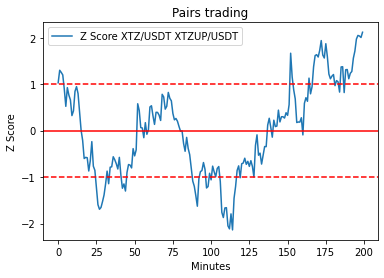

In [ ]:
graph(stored["Z_Spread_1"],key)

Function called opportunity that return if there is an opportunity to trade based on z score

In [ ]:
stored['spread_2'] = stored[symbol3] -stored[symbol4]

In [ ]:
mean_spread_2= stored['spread_2'].mean()
std_spread_2 = stored['spread_2'].std()

In [ ]:
stored["Z_Spread_2"] = (stored['spread_2']-mean_spread_2)/std_spread_2

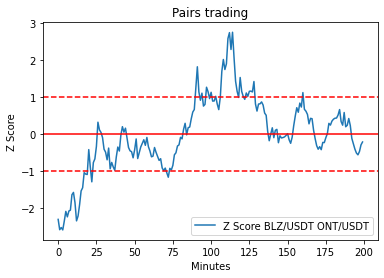

In [ ]:
graph(stored["Z_Spread_2"],key1)

In [ ]:
def opportunity(symbol1,symbol2,Z_Spread):
    if Z_Spread.tolist()[-1] > 1:
      result = str(" Sell ") +str(symbol1) + str (" and Buy ") + str(symbol2) 
      print(result)
    elif Z_Spread.tolist()[-1] <- 1:
      result = str(" Sell ") +str(symbol2) + str (" and Buy ") + str(symbol1) 
      print(result)
    else:
      result = str(" No opportunity for ") +str(symbol2) + str (" and ") + str(symbol1)
      print(result)

Show opportunity for pair trading for leverage cryptocurrency pairs and non-leverage cryptocurrency pairs

In [ ]:
opportunity(symbol1,symbol2,stored['Z_Spread_1'])
opportunity(symbol3,symbol4,stored['Z_Spread_2'])

 Sell XTZ/USDT and Buy XTZUP/USDT
 No opportunity for ONT/USDT and BLZ/USDT


# Momentum Strategy

Investopedia defines a momentum strategy as one to "capitalize on the continuance of an existing market trend."

A viable momentum strategy is long in uptrends and short in downtrends.

We write a momentum trading strategy, evaluate it, then improve on the strategy using evolutionary algorithms. This is applied on __ETH/USD__ as etherium has a deep historical data to run experiments on.

Our key finding is that momentum strategies are great but a strategy with frequent small contrarian trades is better. We finetune one such strategy with trailing stop losses.


### Pulling live prices

We gather data from the yahoo via pandas_datareader.

Looking at the plot below, we can see extreme volatility from the instrument ETH-USD, but a important feature is that there are periods of clear uptrends and downtrends which is advantageous for our momentum strategy.

,Close Price
Date,
2015-08-06,2.772120
2015-08-07,0.753325


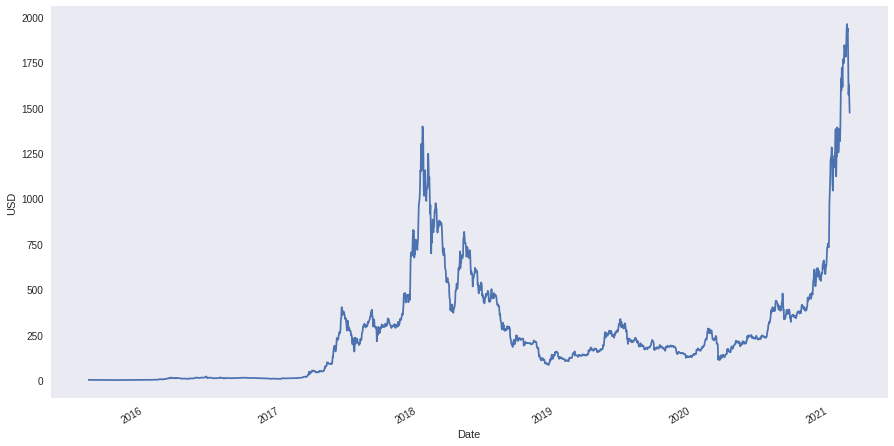

In [ ]:
def yahoo_prices(symbol = 'ETH-USD'):
  start = datetime(2014, 1, 2) 
  # extract the closing price data
  prices = web.DataReader([symbol], 'yahoo', start = start, end = datetime.now())['Close']
  prices.columns = {'Close Price'}
  return prices
  
prices = yahoo_ethusd()
display(prices.head(2))

#plot graph
plt.style.use('seaborn')
prices['Close Price'].plot(figsize = (15, 8))
plt.grid()
plt.ylabel("USD")
plt.show()

### Explore a basic MA crossover strategy 
  
A simple moving average (SMA) is a calculation that takes the arithmetic mean of a given set of prices over the specific number of days in the past; for example, over the previous 15, 30, 100, or 200 days. The reason for calculating the moving average of a stock is smooths the price data by creating a constantly updated average price. An MA with a short time frame will react much quicker to price changes than an MA with a long look back period. Since volatility and risk is high associated with cryptocurrencies, we will use a shorter time frame.

In [ ]:
def create_crossover(prices, short_n, long_n, threshold=1, maType='sma'):
    ma_crossover = prices.copy()
    # MA
    if maType == 'ema':
       ma_crossover['short_ma'] = ma_crossover['Close Price'].ewm(span=short_n, adjust=False).mean()
       ma_crossover['long_ma'] = ma_crossover['Close Price'].ewm(span=long_n, adjust=False).mean()
       ma_crossover['short_long_ratio'] = ma_crossover['short_ma'] / ma_crossover['long_ma']
       ma_crossover['signal_ma'] = np.where(ma_crossover['short_ma'] > ma_crossover['long_ma'], 1.0, 0.0)
       ma_crossover['position_ma'] = ma_crossover['signal_ma'].diff()

    if maType == 'wma':
       short_wts = np.arange(1,short_n + 1) 
       long_wts = np.arange(1, long_n + 1)
       output = ma_crossover['Close Price'].rolling(window = short_n, min_periods = 1)
       ma_crossover['short_ma'] = ma_crossover['Close Price'].rolling(short_n).apply(lambda prices: np.dot(prices, short_wts)/short_wts.sum(), raw=True)
       ma_crossover['long_ma'] = ma_crossover['Close Price'].rolling(long_n).apply(lambda prices: np.dot(prices, long_wts)/long_wts.sum(), raw=True)
       ma_crossover['short_long_ratio'] = ma_crossover['short_ma'] / ma_crossover['long_ma']
       ma_crossover['signal_ma'] = np.where(ma_crossover['short_ma'] > ma_crossover['long_ma'], 1.0, 0.0)
       ma_crossover['position_ma'] = ma_crossover['signal_ma'].diff()

    if maType == 'sma':
       ma_crossover['short_ma'] = ma_crossover['Close Price'].rolling(window = short_n, min_periods = 1).mean()
       ma_crossover['long_ma'] = ma_crossover['Close Price'].rolling(window = long_n, min_periods = 1).mean()
       ma_crossover['short_long_ratio_sma'] = ma_crossover['short_ma'] / ma_crossover['long_ma']
       ma_crossover['signal'] = 0.0
       ma_crossover['signal_ma'] = np.where(ma_crossover['short_ma'] > ma_crossover['long_ma'], 1.0, 0.0)
       ma_crossover.loc[ma_crossover.index[0],'signal_ma']=0
       ma_crossover['position_ma'] = ma_crossover['signal_ma'].diff()

    return ma_crossover

def signal_strategy(strategy_df, title='Plot Signals'):
    
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    strategy_df['Close Price'].plot(color = 'k', label= 'Close Price') 
    strategy_df['short_ma'].plot(color = 'b',label = 'short_ma') 
    strategy_df['long_ma'].plot(color = 'g', label = 'long_ma')
    
    # plot ‘buy’ signals
    plt.plot(strategy_df[strategy_df['position_ma'] == 1].index, 
             strategy_df['short_ma'][strategy_df['position_ma'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(strategy_df[strategy_df['position_ma'] < 0].index, 
             strategy_df['short_ma'][strategy_df['position_ma'] < 0], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('USD', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title(title, fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()


Evaluate returns

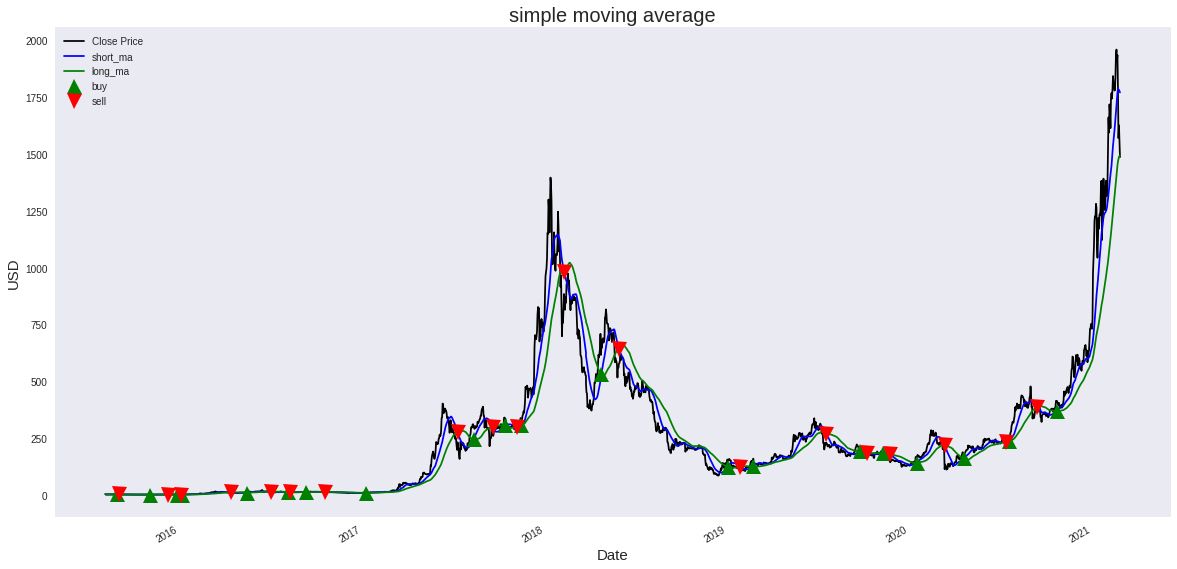

,Close Price,short_ma,long_ma,short_long_ratio,signal_ma,position_ma
Date,,,,,,
2015-08-06,2.772120,2.772120,2.772120,1.000000,0.0,NaN
2015-08-07,0.753325,2.579854,2.692952,0.958002,0.0,0.0
2015-08-08,0.701897,2.401001,2.614871,0.918210,0.0,0.0
2015-08-09,0.708448,2.239805,2.540109,0.881775,0.0,0.0
2015-08-10,1.067860,2.128191,2.482374,0.857321,0.0,0.0
...,...,...,...,...,...,...
2021-02-21,1935.601074,1753.659925,1467.682096,1.194850,1.0,0.0
2021-02-22,1781.992920,1756.358306,1480.008011,1.186722,1.0,0.0
2021-02-23,1570.203979,1738.629322,1483.545107,1.171942,1.0,0.0


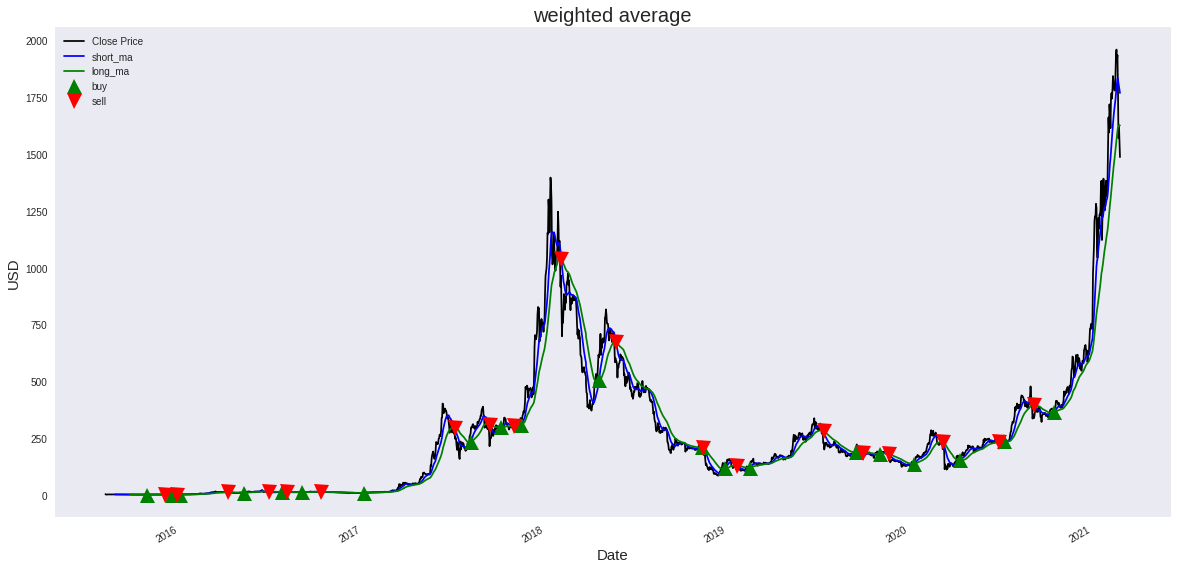

,Close Price,short_ma,long_ma,short_long_ratio,signal_ma,position_ma
Date,,,,,,
2015-08-06,2.772120,2.772120,2.772120,1.000000,0.0,NaN
2015-08-07,0.753325,2.579854,2.692952,0.958002,0.0,0.0
2015-08-08,0.701897,2.401001,2.614871,0.918210,0.0,0.0
2015-08-09,0.708448,2.239805,2.540109,0.881775,0.0,0.0
2015-08-10,1.067860,2.128191,2.482374,0.857321,0.0,0.0
...,...,...,...,...,...,...
2021-02-21,1935.601074,1753.659925,1467.682096,1.194850,1.0,0.0
2021-02-22,1781.992920,1756.358306,1480.008011,1.186722,1.0,0.0
2021-02-23,1570.203979,1738.629322,1483.545107,1.171942,1.0,0.0


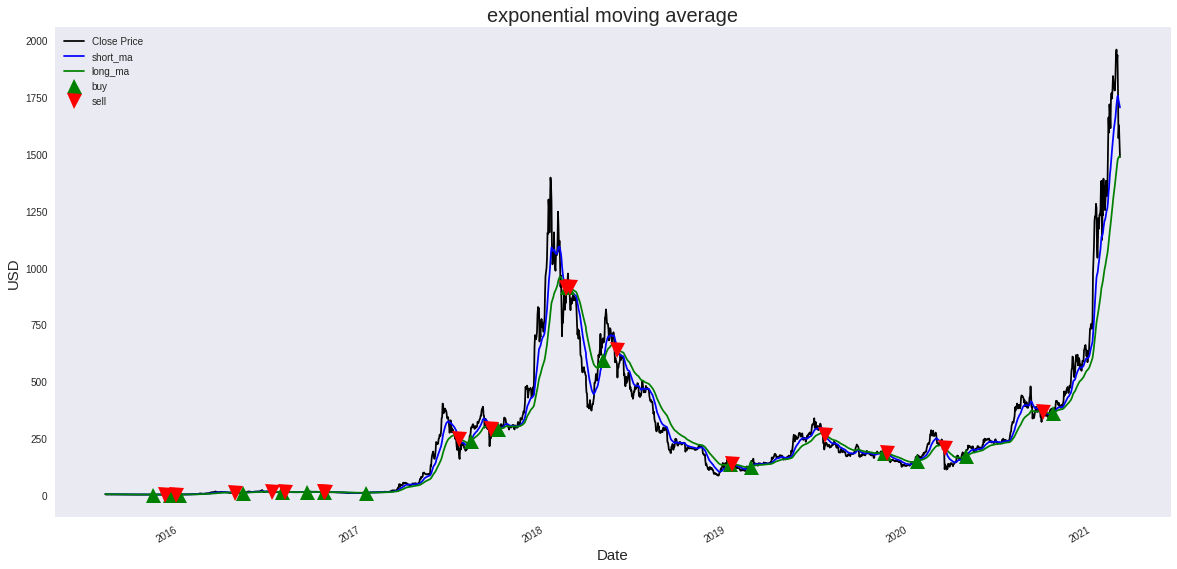

,Close Price,short_ma,long_ma,short_long_ratio,signal_ma,position_ma
Date,,,,,,
2015-08-06,2.772120,2.772120,2.772120,1.000000,0.0,NaN
2015-08-07,0.753325,2.579854,2.692952,0.958002,0.0,0.0
2015-08-08,0.701897,2.401001,2.614871,0.918210,0.0,0.0
2015-08-09,0.708448,2.239805,2.540109,0.881775,0.0,0.0
2015-08-10,1.067860,2.128191,2.482374,0.857321,0.0,0.0
...,...,...,...,...,...,...
2021-02-21,1935.601074,1753.659925,1467.682096,1.194850,1.0,0.0
2021-02-22,1781.992920,1756.358306,1480.008011,1.186722,1.0,0.0
2021-02-23,1570.203979,1738.629322,1483.545107,1.171942,1.0,0.0


In [ ]:
sma_crossover_df = create_crossover(prices, 20, 50, 1, 'sma')
signal_strategy(sma_crossover_df, 'simple moving average')
display(ma_crossover_df)

wma_crossover_df = create_crossover(prices, 20, 50, 1, 'wma')
signal_strategy(wma_crossover_df, 'weighted average')
display(ma_crossover_df)

ema_crossover_df = create_crossover(prices, 20, 50, 1, 'ema')
signal_strategy(ema_crossover_df, 'exponential moving average')
display(ma_crossover_df)

In [ ]:
def get_start2end_returns(strategy):
    # get total returns of trade
    price_col = 'Close Price'
    price_series = strategy.loc[:,price_col]
    start2end_returns = (price_series.iloc[-1] / price_series.iloc[0]) - 1
    return start2end_returns

def get_trade_date(strategy):
    # return start date of strategy
    return strategy.index[0]

def get_xover_returns(ma_crossover):
    # assign trade index
    ma_crossover= ma_crossover.assign( trade_index = (ma_crossover.signal_ma==1) & (ma_crossover.signal_ma.shift()==0) )
    ma_crossover.trade_index = ma_crossover.signal_ma * ma_crossover.trade_index.cumsum()
    
    # generate new series of trade returns
    try:
        if ma_crossover.trade_index.max()>1:
            trade_returns = ma_crossover.loc[ma_crossover.trade_index!=0].groupby('trade_index').apply(get_start2end_returns)
            trade_returns.index = ma_crossover.loc[ma_crossover.trade_index!=0].groupby('trade_index').apply(get_trade_date)
        else:
            trade_returns = pd.Series()
            ret_ = get_start2end_returns(ma_crossover)
            dat_ = get_trade_date(ma_crossover)
            trade_returns.loc[dat_] = ret_
    except:
        print(ma_crossover)
        raise
    trade_returns = trade_returns.rename('trade_returns')
    return trade_returns, ma_crossover


We backtest_strategy this strategy by first getting a series of returns for each trade.  
Some key findings for the __simple moving average__ strategy: 
1. It makes twenty trades on ETHUSD, out of which 6 are losing trades. 
2. There are many small trades and a few ridiculously profitable trades.  

We also examine the other moving average strategies to find that there is little difference.  
They all seem to enjoy a similar win-lose profile.

SMA trade results


,trade_returns
2015-08-29,-0.018556
2015-11-04,-0.085570
2015-12-28,0.129555
2016-01-06,7.460152
2016-05-16,-0.039233
2016-08-05,0.115990
2016-09-11,0.010838
2017-01-08,18.184436
2017-08-12,-0.051197
2017-10-14,-0.119824


EMA trade results


,trade_returns
2015-11-09,-0.178197
2015-12-14,-0.123521
2016-01-01,7.546377
2016-05-07,0.209647
2016-07-24,-0.141673
2016-09-12,0.002760
2016-10-17,0.000000
2017-01-08,18.403877
2017-08-07,-0.169314
2017-09-29,1.881618


WMA trade results


,trade_returns
2015-10-29,-0.319435
2015-12-17,-0.089652
2016-01-02,9.371722
2016-05-09,0.300601
2016-07-25,-0.141424
2016-09-03,0.009058
2017-01-04,22.887623
2017-08-07,-0.066237
2017-10-06,-0.016858
2017-11-14,1.855244


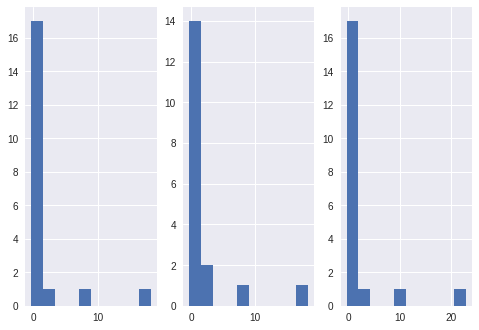

In [ ]:
sma_trade_results, sma_crossover_df = get_xover_returns(sma_crossover_df)
ema_trade_results, ema_crossover_df = get_xover_returns(ema_crossover_df)
wma_trade_results, wma_crossover_df = get_xover_returns(wma_crossover_df)

fig, (hist1, hist2, hist3) = plt.subplots(1, 3)

print('SMA trade results')
display(pd.DataFrame(sma_trade_results))
hist1.hist(sma_trade_results);

print('EMA trade results')
display(pd.DataFrame(ema_trade_results))
hist2.hist(ema_trade_results);

print('WMA trade results')
display(pd.DataFrame(wma_trade_results))
hist3.hist(wma_trade_results);

Double check the implementation.
The following trades indexed 8.0 and 11.0 are consistent with the graph.

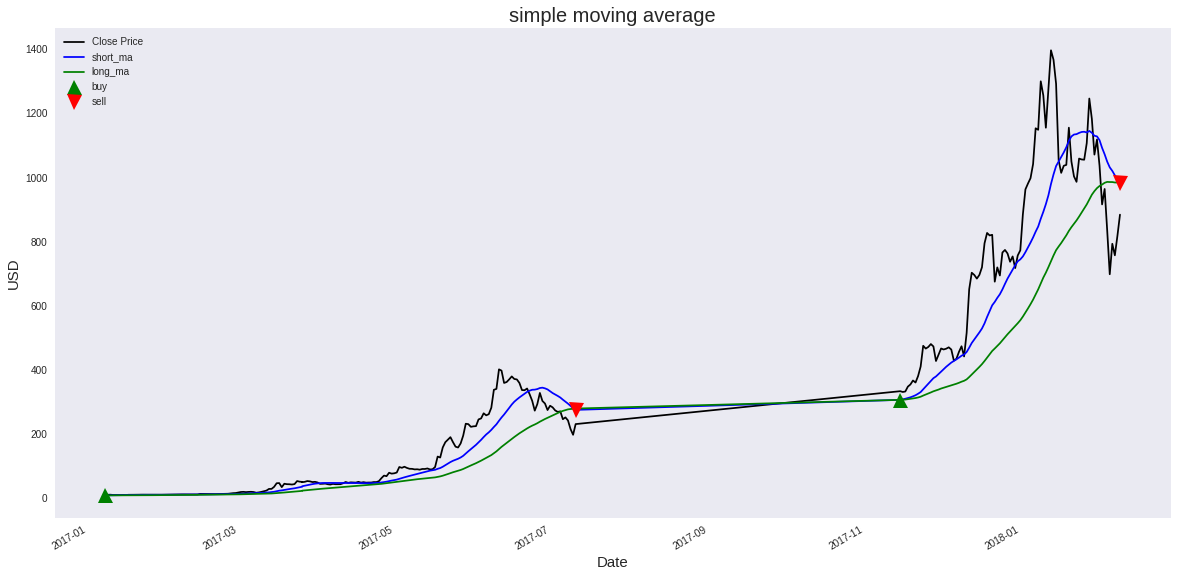

trade 8 has a return of 1,800%


,Close Price,short_ma,long_ma,short_long_ratio,signal_ma,position_ma
Date,,,,,,
2017-01-08,10.289800,8.970912,8.901581,1.007789,1.0,1.0
2017-07-10,197.404007,269.020531,255.654200,1.052283,1.0,0.0


trade 11 has a return of 140%


,Close Price,short_ma,long_ma,short_long_ratio,signal_ma,position_ma
Date,,,,,,
2017-11-15,333.356995,310.762804,304.915285,1.019178,1.0,0.0
2018-02-08,817.807007,950.460786,926.752710,1.025582,1.0,0.0


In [ ]:
to_plot = sma_crossover_df.copy()
to_plot.loc[to_plot.position_ma==-1, 'trade_index'] = to_plot.trade_index.shift(1).loc[to_plot.position_ma==-1]
signal_strategy(to_plot.loc[to_plot.trade_index.isin([8,11])], 'simple moving average')

print("trade 8 has a return of 1,800%")
display(ma_crossover_df.loc[sma_crossover_df['trade_index']==8].iloc[[0,-1]] )
print("trade 11 has a return of 140%")
display( ma_crossover_df.loc[sma_crossover_df['trade_index']==11].iloc[[0,-1]] )

We apply some metrics for more backtests:  
1. [Sharpe ratio](https://www.youtube.com/watch?v=s0bxoD_0fAU)
2. [Profit factor](https://www.investopedia.com/articles/fundamental-analysis/10/strategy-performance-reports.asp#:~:text=The%20profit%20factor%20is%20defined,one%20indicating%20a%20profitable%20system.)
3. Total returns, here which is `	39.086705`, that is a ridiculous ~3,000%  
  
  
To double check the absurd returns, we see that the prices range from as low as 70 cents to as high as $1750. Throughout the short life of Etherium, absurd returns are absolutely possible. 

In [ ]:
sma_trade_results

2015-08-29    -0.018556
2015-11-04    -0.085570
2015-12-28     0.129555
2016-01-06     7.460152
2016-05-16    -0.039233
2016-08-05     0.115990
2016-09-11     0.010838
2017-01-08    18.184436
2017-08-12    -0.051197
2017-10-14    -0.119824
2017-11-15     1.453247
2018-04-25    -0.155730
2019-01-03    -0.239580
2019-02-22     0.519635
2019-09-24     0.065122
2019-11-09    -0.170843
2020-01-16    -0.316586
2020-04-20     0.387101
2020-07-19     0.639542
2020-10-22     2.628021
Name: trade_returns, dtype: float64


SMA


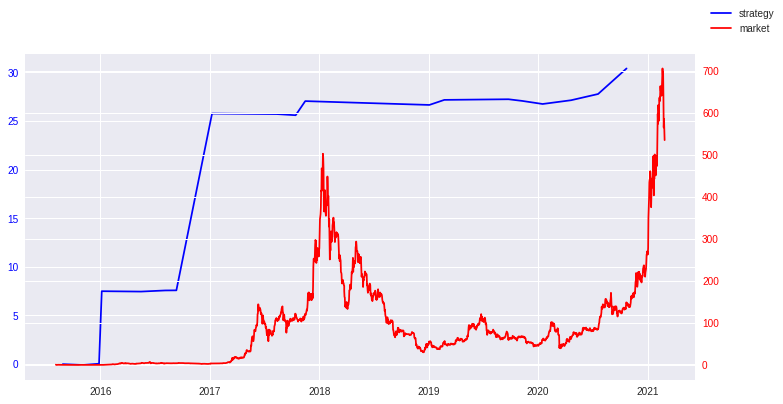

,figures
Sharpe,0.353983
Profit Factor,26.391401
total_ret,30.396521
compound_ret,1774.975313



EMA


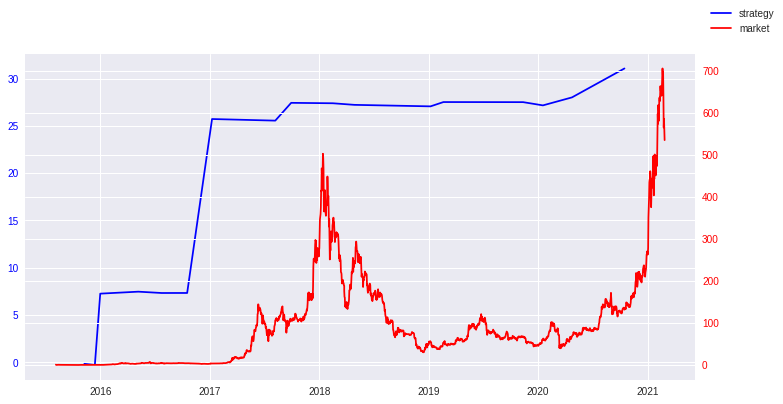

,figures
Sharpe,0.377092
Profit Factor,24.248017
total_ret,31.068391
compound_ret,1413.118214



WMA


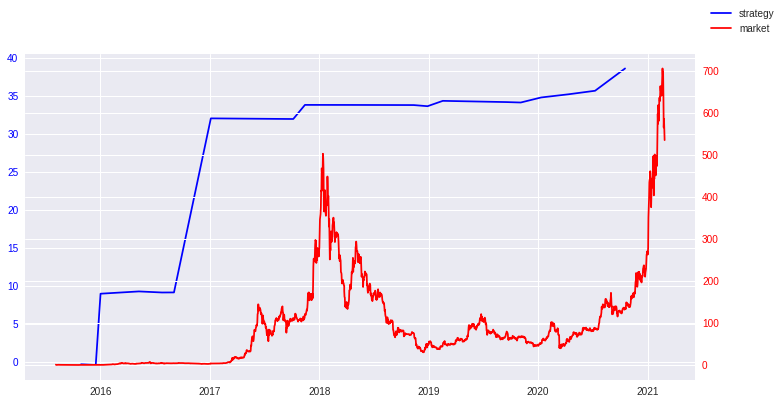

,figures
Sharpe,0.358256
Profit Factor,38.683713
total_ret,38.581159
compound_ret,6899.282455


In [ ]:
sharpe = lambda trade_returns: trade_returns.mean() / trade_returns.std()
profit_factor = lambda trade_returns: trade_returns[trade_returns>0].sum() / trade_returns[trade_returns<0].abs().sum() 

def backtest(trade_returns, strategy_df=None, verbose=False):
    
    # plot eqty curve 
    if verbose: 
        plt.style.use('seaborn')

        fig, ax1 = plt.subplots(figsize  = (12,6))

        ax1.plot(trade_returns.cumsum(), label='strategy', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        close_series = strategy_df['Close Price']
        ax2.plot( (close_series/close_series.iloc[0])-1, color='red', label='market')
        ax2.tick_params(axis='y', labelcolor='red')
        fig.legend()
        plt.show()
    
    # Get hard figures
    perf_figures = pd.DataFrame()
    perf_figures.loc['Sharpe','figures'] = sharpe(trade_returns)
    perf_figures.loc['Profit Factor','figures'] = profit_factor(trade_returns)
    perf_figures.loc['total_ret','figures'] = trade_returns.sum()
    perf_figures.loc['compound_ret','figures'] = (trade_returns + 1).cumprod().iloc[-1]
    
    return perf_figures
    
print()
print('SMA')
sma_perf_figures = backtest(sma_trade_results, strategy_df=sma_crossover_df, verbose=True)
display(sma_perf_figures)

print()
print('EMA')
ema_perf_figures = backtest(ema_trade_results, strategy_df=ema_crossover_df, verbose=True)
display(ema_perf_figures)

print()
print('WMA')
wma_perf_figures = backtest(wma_trade_results, strategy_df=wma_crossover_df, verbose=True)
display(wma_perf_figures)

### A comment on Moving Averages
It seems here that the WMA performs the best out of the three moving averages.  It could be a genuine advantage or it could be luck, it is hard to verify here.

### Risk Management

A prominent figure in the industry Ernest P. Chan writes that Momentum strategies should have no take-profits, but have tight or adjusting stop-losses. The reason why trend following strategies should not have take profits is because the strategy needs to "let profits run".
http://epchan.blogspot.com/2009/06/my-interview-stop-loss-and-principle-of.html


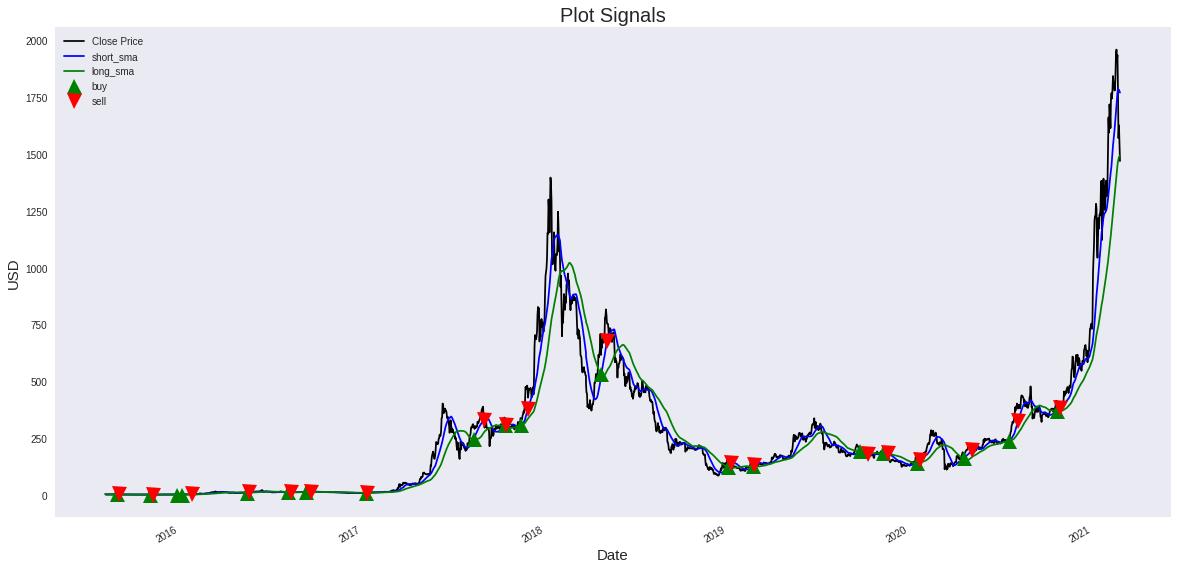

2015-08-29   -0.018556
2015-11-04    0.111482
2015-12-28    1.957699
2016-05-16    0.210750
2016-08-05    0.082473
2016-09-11    0.157630
2017-01-08    0.025248
2017-08-12    0.300865
2017-10-14   -0.009540
2017-11-15    0.418605
2018-04-25    0.195384
2019-01-03    0.011185
2019-02-22    0.065080
2019-09-24    0.121521
2019-11-09   -0.024154
2020-01-16    0.023743
2020-04-20    0.197043
2020-07-19    0.672482
2020-10-22   -0.014080
Name: trade_returns, dtype: float64

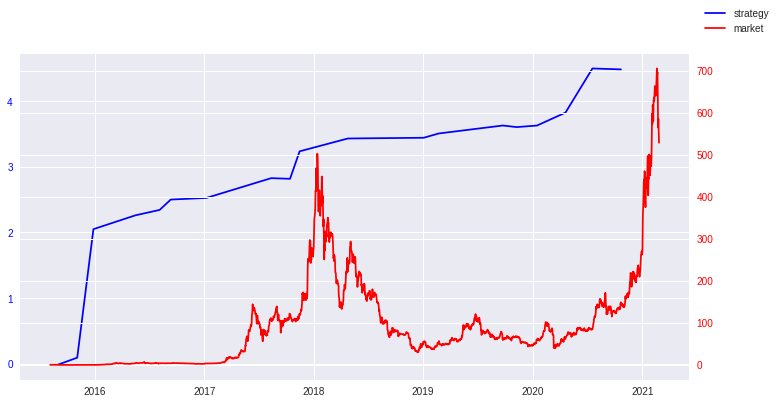

,figures
Sharpe,0.522117
Profit Factor,68.615044
total_ret,4.484860
compound_ret,26.117764


In [ ]:
def signal_eda(strategy_df):
    
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    strategy_df['Close Price'].plot(color = 'k', label= 'Close Price') 
    strategy_df['short_sma'].plot(color = 'b',label = 'short_sma') 
    strategy_df['long_sma'].plot(color = 'g', label = 'long_sma')
    # plot ‘buy’ signals
    plt.plot(strategy_df[strategy_df['Position'] == 1].index, 
             strategy_df['short_sma'][strategy_df['Position'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(strategy_df[strategy_df['Position'] < 0].index, 
             strategy_df['short_sma'][strategy_df['Position'] < 0], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('USD', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title('Plot Signals', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

def backtest(trade_returns, strategy_df=None, verbose=False):
    
    # plot eqty curve 
    if verbose: 
        plt.style.use('seaborn')

        fig, ax1 = plt.subplots(figsize  = (12,6))

        ax1.plot(trade_returns.cumsum(), label='strategy', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        close_series = strategy_df['Close Price']
        ax2.plot( (close_series/close_series.iloc[0])-1, color='red', label='market')
        ax2.tick_params(axis='y', labelcolor='red')
        fig.legend()
        plt.show()
    
    # Get hard figures
    perf_figures = pd.DataFrame()
    perf_figures.loc['Sharpe','figures'] = sharpe(trade_returns)
    perf_figures.loc['Profit Factor','figures'] = profit_factor(trade_returns)
    perf_figures.loc['total_ret','figures'] = trade_returns.sum()
    perf_figures.loc['compound_ret','figures'] = (trade_returns + 1).cumprod().iloc[-1]
    
    return perf_figures


def get_xover_returns(ma_crossover):
    # assign trade index
    # ma_crossover= ma_crossover.assign( trade_index = (ma_crossover.Signal==1) & (ma_crossover.Signal.shift()==0) )
    # ma_crossover.trade_index = ma_crossover.Signal * ma_crossover.trade_index.cumsum()

    ma_crossover= ma_crossover.assign( trade_index = 0 )
    signal_trigger = (ma_crossover.Signal==1) & (ma_crossover.Signal.shift()==0)
    ma_crossover.loc[signal_trigger,'trade_index']= 1
    ma_crossover.loc[:,'trade_index']= ma_crossover.Signal * ma_crossover.loc[:,'trade_index'].cumsum()

    # generate new series of trade returns
    try:
        if ma_crossover.trade_index.max()>1:
            trade_returns = ma_crossover.loc[ma_crossover.trade_index!=0].groupby('trade_index').apply(get_start2end_returns)
            trade_returns.index = ma_crossover.loc[ma_crossover.trade_index!=0].groupby('trade_index').apply(get_trade_date)
        else:
            trade_returns = pd.Series()
            ret_ = get_start2end_returns(ma_crossover)
            dat_ = get_trade_date(ma_crossover)
            trade_returns.loc[dat_] = ret_
    except:
        print(ma_crossover)
        raise
    trade_returns = trade_returns.rename('trade_returns')
    return trade_returns, ma_crossover


def create_xover(prices, short_n, long_n, threshold=1, trailing_sl=0.05):
    ma_crossover = prices.copy()
    # MA
    ma_crossover['short_sma'] = ma_crossover['Close Price'].rolling(window = short_n, min_periods = 1).mean()
    ma_crossover['long_sma'] = ma_crossover['Close Price'].rolling(window = long_n, min_periods = 1).mean()
    ma_crossover['short_long_ratio'] = ma_crossover['short_sma'] / ma_crossover['long_sma']

    #define signal
    ma_crossover['Signal'] = 0.0
    ma_crossover['Signal'] = np.where(ma_crossover['short_long_ratio'] > threshold, 1.0, 0.0)
    ma_crossover.loc[ma_crossover.index[0],'Signal']=0

    # define entry and exits here
    ma_crossover = ma_crossover.assign(Position = 0)
    # entry
    ma_crossover.loc[(ma_crossover.Signal==1) & (ma_crossover.Signal.shift(1)==0), 'Position'] = 1
    # exits
    for entry_date, entry_row in ma_crossover.loc[ma_crossover.Position==1].iterrows():
      # single trade dataframe to find first stoploss triggr
      single_trade = ma_crossover.loc[entry_date:].copy()
      single_trade = single_trade.assign( expanding_max = single_trade.loc[:,'Close Price'].expanding().max() )
      single_trade = single_trade.assign( trailing_stoploss = single_trade.expanding_max * (1-trailing_sl) )

      # if sl is triggered, else end of trade
      if len(single_trade.loc[single_trade.loc[:,'Close Price'] < single_trade.trailing_stoploss]) > 0:
        exit_date = single_trade.loc[single_trade.loc[:,'Close Price'] < single_trade.trailing_stoploss].index[0]
      elif len(single_trade.loc[(single_trade.Signal==0) & (single_trade.Signal.shift(1)==1)])>0:
        exit_date = single_trade.loc[(single_trade.Signal==0) & (single_trade.Signal.shift(1)==1)].index[0]
      else:
        exit_date = single_trade.index[-1]

      # print(entry_date)
      # print(exit_date)
      # print()
      ma_crossover.loc[exit_date, 'Position']=ma_crossover.loc[exit_date, 'Position']-1
    ma_crossover.Signal = ma_crossover.Position.cumsum()
    ma_crossover.Signal = ma_crossover.Signal.clip(upper=1)
    return ma_crossover
    
ma_crossover_w_trailing = create_xover(prices, 20, 50, threshold=1, trailing_sl=0.05)

signal_eda(ma_crossover_w_trailing)

trade_returns, ma_crossover_w_trailing = get_xover_returns(ma_crossover_w_trailing)
display(trade_returns)

perf_figures = backtest(trade_returns, strategy_df=ma_crossover_w_trailing, verbose=True)
display(perf_figures)

Adding the stoplosses results in shorter trades. No longer do we see 1,800% profits. As a result, the total profit is lower.

However, our losses are cut short and the winning rate is higher.

Self-initiated part: Evolutionary Algorithms Optimization

The returns are good, but can we do better?

The original parameters are arbitrary. Perhaps we can use an optimization method to find better parameters.

Here, we apply evolutionary algorithms to optimize the strategy and find a stronger configuration.

In [ ]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import warnings
warnings.filterwarnings("ignore")


def insert_rand_short( x): 
    x[0] = np.random.randint(5,31)
    return x
def insert_rand_long( x): 
    x[1] = np.random.randint(31,81)
    return x
def insert_rand_theshold( x): 
    # x[2] =np.random.uniform(0.5, 1.5)
    x[2] = 1
    return x
def insert_rand_trailing_sl( x): 
    # x[3] =np.random.choice([0.5, 0.2, 0.1, 0.05, 0.002])
    x[3] =np.random.choice([0.2, 0.1, 0.05, 0.002])
    return x

def random_init():
    ind = [None, None, None, None]
    ind=insert_rand_short(ind)
    ind=insert_rand_long(ind)
    ind=insert_rand_theshold(ind)
    ind=insert_rand_trailing_sl(ind)
    return ind 

def mutate_crossover(individual):
    mutate_func = np.random.choice([insert_rand_short, 
                                 insert_rand_long, 
                                 insert_rand_theshold,
                                 insert_rand_trailing_sl])
    return mutate_func(individual),

def eval_ind(individual):
    # fitness_measure = {'total_ret', 'Sharpe', 'Profit Factor','compound_ret'}
    fitness_measure = 'total_ret'
    short, long, threshold, sl = individual
    
    ma_crossover = create_xover(prices, short, long, threshold, sl)
    trade_returns, ma_crossover = get_xover_returns(ma_crossover)
    perf_figures = backtest(trade_returns, strategy_df=ma_crossover)
    
    return perf_figures.loc[fitness_measure].iloc[0],


def evolutionary_search():

    creator.create("Fitness", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.Fitness)

    # intiate population
    toolbox = base.Toolbox()
    toolbox.register("init_individual", random_init)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.init_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # define generational functions
    toolbox.register("evaluate", eval_ind)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutate_crossover)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # define hall of fame
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(100)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # run ea search and return winners
    final_pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                    stats=stats, halloffame=hof, verbose=True)
    hof_fitness_value = [key.values[0] for key in hof.keys]
    winners = list(zip(hof_fitness_value, hof.items))
    
    return winners

winners = evolutionary_search()

gen	nevals	avg    	std    	min     	max    
0  	300   	6.45118	6.42204	0.260844	25.1387
1  	176   	11.8826	6.91504	0.332445	25.1387
2  	172   	16.817 	5.38155	0.169836	25.1387
3  	158   	20.1972	3.92378	0.332445	25.1387
4  	179   	21.455 	4.49161	0.801716	25.1387
5  	192   	22.508 	4.07018	1.34275 	25.1387
6  	175   	22.993 	4.16508	1.26254 	25.1387
7  	179   	23.3833	4.00899	1.49764 	25.1387
8  	185   	24.0613	3.39065	1.81092 	25.1387
9  	166   	23.8788	4.12786	1.81092 	25.1387
10 	182   	23.7514	4.09758	1.81092 	25.1387


The winning configurations

How to interpret the winners below:  
Each row is an individual containing   
`<fitness>, [short_ma, long_ma, threshold, trailing stop]`  
These can be individually tested. 

In [ ]:
winners[-15:] 

[(23.88748381634629, [30, 32, 1, 0.2]),
 (23.93438911161102, [27, 39, 1, 0.2]),
 (23.94451201027954, [5, 32, 1, 0.2]),
 (23.969372351165873, [5, 34, 1, 0.2]),
 (24.053894893997864, [5, 33, 1, 0.2]),
 (24.08776343591719, [6, 33, 1, 0.2]),
 (24.140922050258297, [6, 34, 1, 0.2]),
 (24.16726425952367, [28, 39, 1, 0.2]),
 (24.577346843811917, [28, 40, 1, 0.2]),
 (25.14357270158819, [6, 36, 1, 0.2]),
 (25.281825134893406, [7, 34, 1, 0.2]),
 (25.31542615075357, [7, 35, 1, 0.2]),
 (25.365934961501406, [7, 33, 1, 0.2]),
 (25.379900598584616, [7, 36, 1, 0.2]),
 (25.382616955007496, [6, 37, 1, 0.2])]

Findings


Here are some winners that are worth exploring.  
These are picked out because they have very different combinations, for example the first and the last have drastically different moving average configurations.   
The former adopts a very fast and a very slow moving average, whilst the latter picks up relatively similar moving averages. 
```
(36.87719592835675, [7, 38, 1, 0.5]),
(39.07460531433684, [13, 47, 1, 0.5])
 (25.877851582853417, [23, 35, 1, 0.2])
```


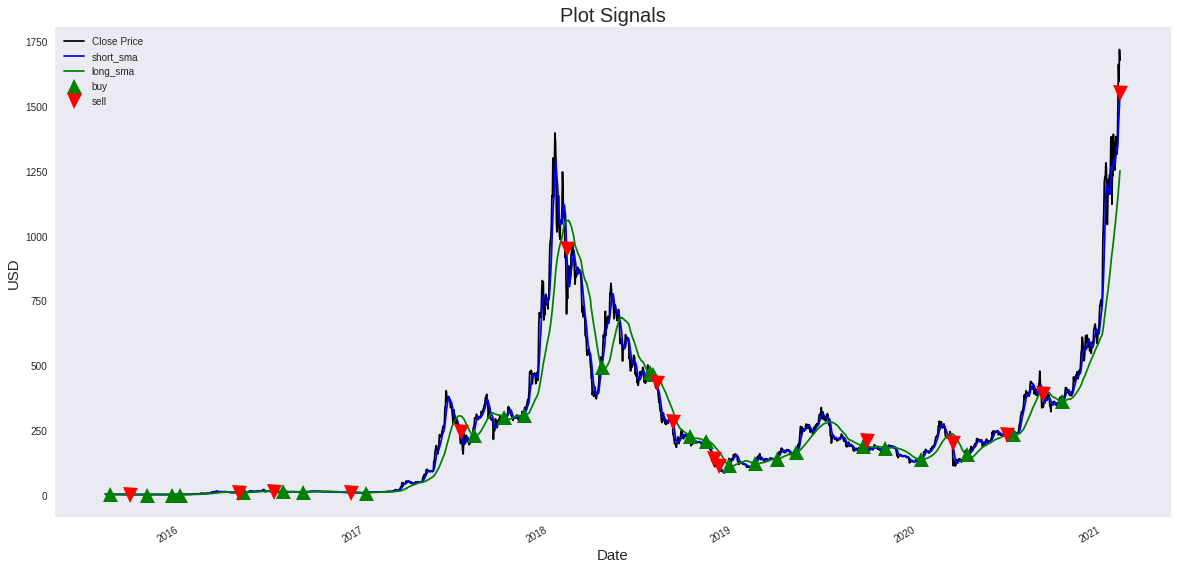

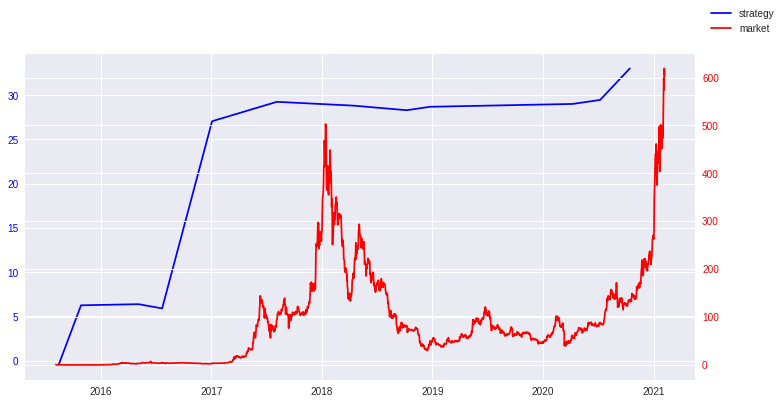

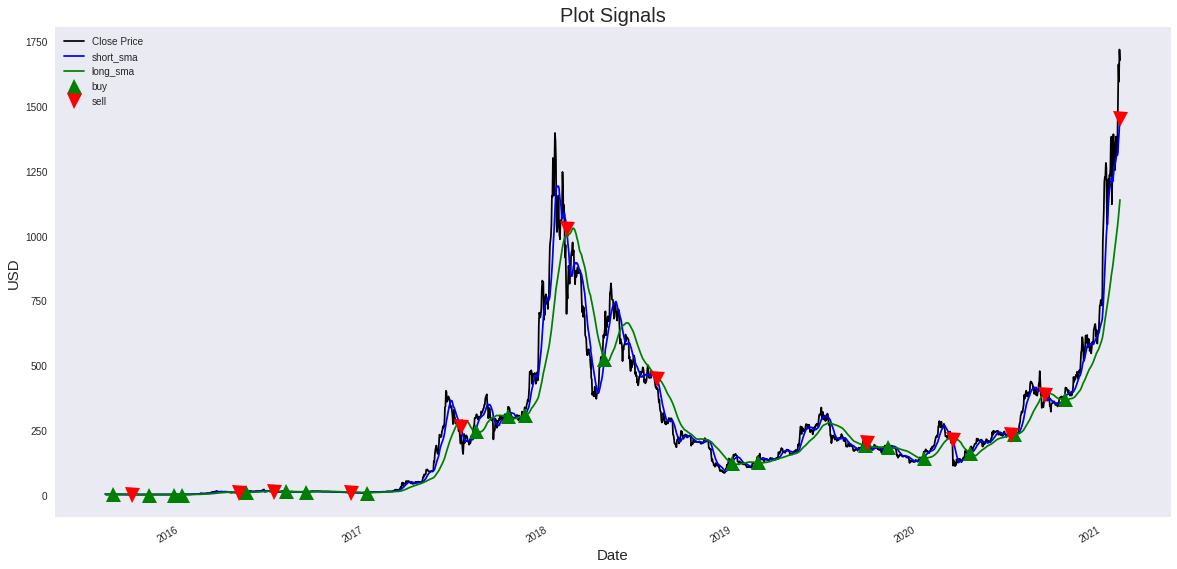

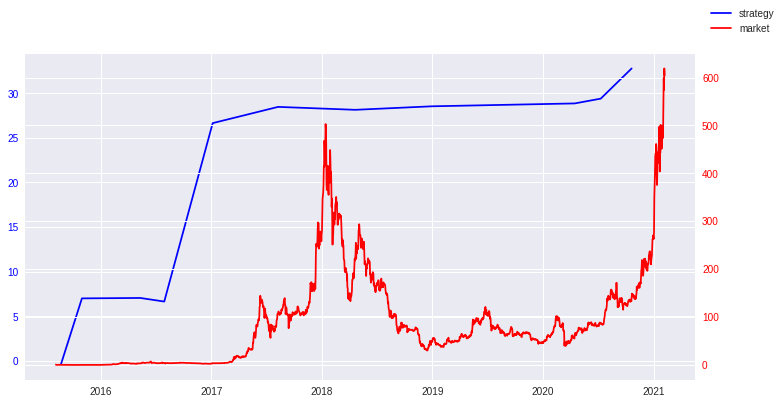

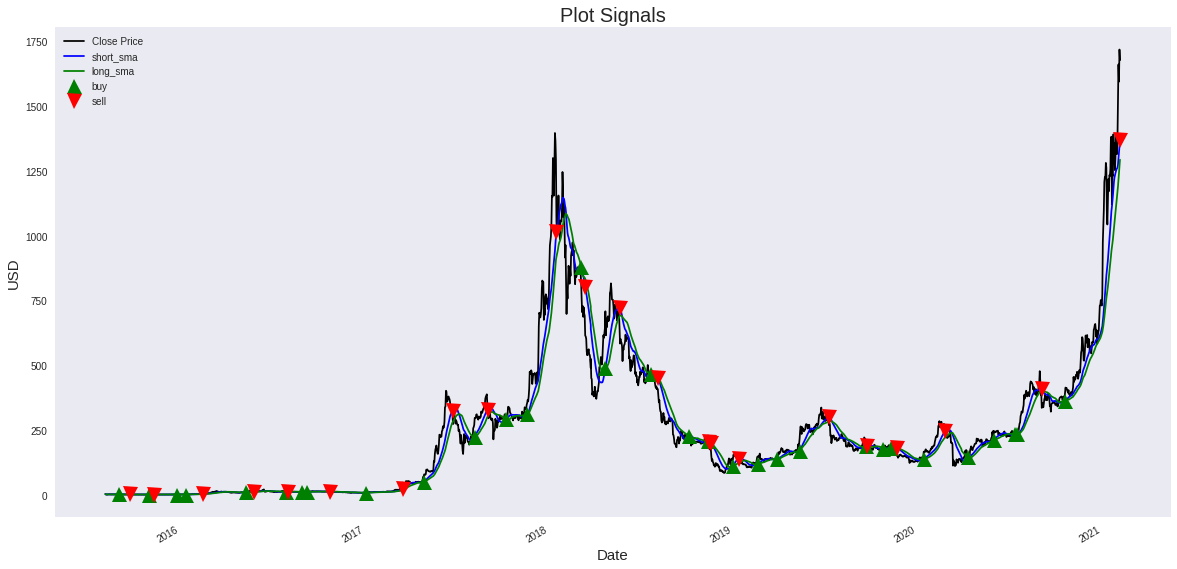

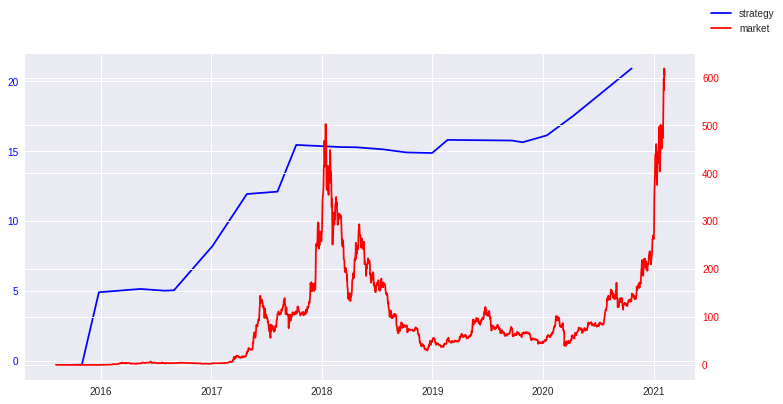

,short,long,threshold,sl,total_ret,compound_ret
0,7,38,1,0.5,33.010483,555.566262
1,13,47,1,0.5,32.772997,1395.391151
2,23,35,1,0.2,20.923227,6584.087907


In [ ]:
winners_df = pd.DataFrame([[7, 38, 1, 0.5], 
                           [13, 47, 1, 0.5], 
                           [23, 35, 1, 0.2]], 
                          columns = ['short', 'long', 'threshold', 'sl'])

for i, row in winners_df.iterrows():
  short, long, threshold, sl = row

  ma_crossover = create_xover(prices, int(short), int(long), threshold, sl)
  signal_eda(ma_crossover)

  trade_returns, ma_crossover = get_xover_returns(ma_crossover)
  # display(trade_returns)

  perf_figures = backtest(trade_returns, strategy_df=ma_crossover, verbose=True)
  # display(perf_figures)
  winners_df.loc[i, 'total_ret'] = perf_figures.loc['total_ret'].iloc[0]
  winners_df.loc[i, 'compound_ret'] = perf_figures.loc['compound_ret'].iloc[0]

display( winners_df )

### Conclusion for momentum strategy for ETH/USD

Key Finding: Holding Etherium for long periods is good, but making many small trades is better.


There is a popular term to hold cryptocurrency through the crytocurrency winters - "HODL". However, the results here prove that it is much wiser to make multiple trades to capitalize on compounding returns.  
  
In the above graph, out of the three "winner" strategies, the first strategy proposes to hold etherium for the longest and manages to __fetch the highest return... but the lowest compounding return__. However, if we intend to reinvest our profits, the third strategy makes many frequent trades and makes the highest compounding return. 

Thus we recommend frequent momentum trades with a trailing stoploss of 20%.

In [ ]:
# live pull for momentum 
# this can be used in real time
def momentum_signal():
  """
  Return decision of momentum strategy based on live prices
  1 - buy new posiiton
  -1 - sell current position
  """
  # Extract the closing price datas
  prices = yahoo_prices()

  # signal
  ma_crossover_df = create_crossover(prices, 23, 35, 1, 'basic')
  position_col_name = [col for col in ma_crossover_df.columns if 'position' in col][0]
  live_decision = ma_crossover_df.loc[:,position_col_name].iloc[-1]

  return live_decision

## ZIL USD
We reapply the same analysis on ZIL-USD.  
However, because the historical data is not long, we apply a much smaller range of the moving averages. 

In [ ]:
prices = yahoo_prices(symbol='ZIL-USD')

def insert_rand_short( x): 
    x[0] = np.random.randint(3,11)
    return x
def insert_rand_long( x): 
    x[1] = np.random.randint(11,15)
    return x
    
winners = evolutionary_search()
display(winners[-15:])

Moving average strategies are generally also quite profitable on ZIL, as seen from the EA results. From the first generation, where the individuals are randomly generated, we have a mean positive compound return of 300%.   
We now examine the best strategy. 

In [ ]:
eval_ind([10,12,1,0.05])

(1.1873355194602853,)

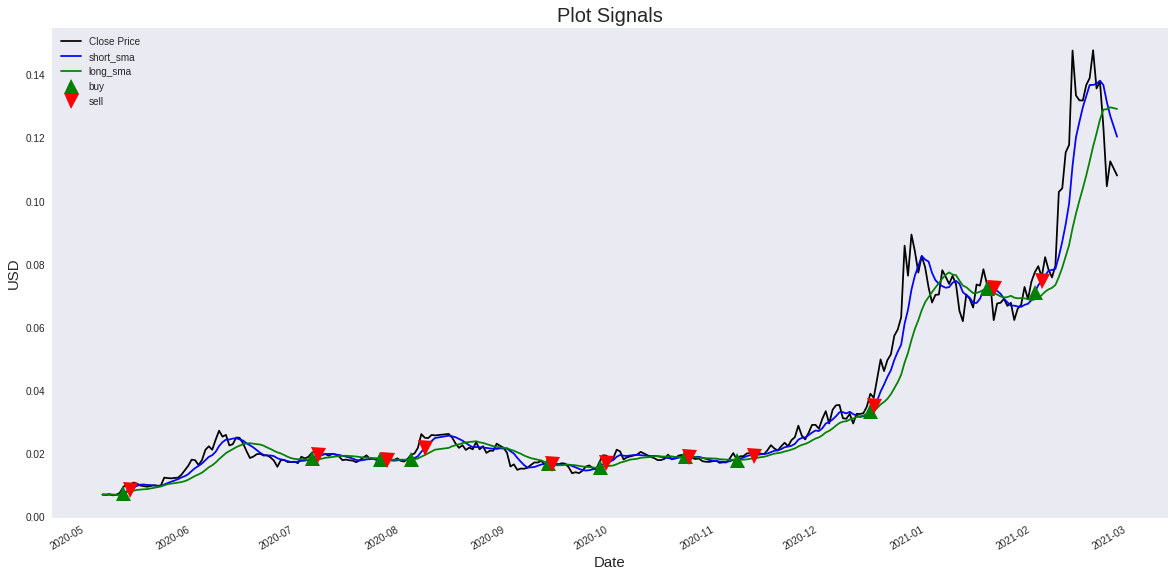

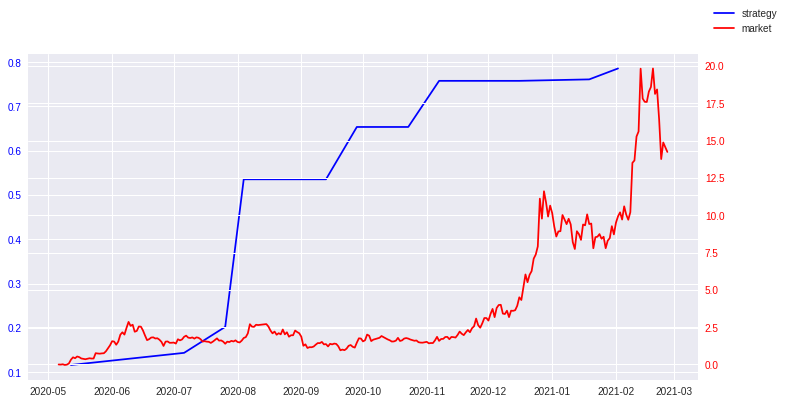

,short,long,threshold,sl,total_ret,compound_ret
0,6,14,1,0.002,0.785734,2.054404


In [ ]:
winners_df = pd.DataFrame([[6, 14, 1, 0.002]], 
                          columns = ['short', 'long', 'threshold', 'sl'])

for i, row in winners_df.iterrows():
  short, long, threshold, sl = row

  ma_crossover = create_xover(prices, int(short), int(long), threshold, sl)
  signal_eda(ma_crossover)

  trade_returns, ma_crossover = get_xover_returns(ma_crossover)
  # display(trade_returns)

  perf_figures = backtest(trade_returns.sort_index(), strategy_df=ma_crossover, verbose=True)
  # display(perf_figures)
  winners_df.loc[i, 'total_ret'] = perf_figures.loc['total_ret'].iloc[0]
  winners_df.loc[i, 'compound_ret'] = perf_figures.loc['compound_ret'].iloc[0]

display( winners_df )

We similarly find a profitable strategy with ZIL despite the small amount historical data. It is worth noting that ZIL did not have the same magnitude of volatility that ETH has experienced, but the holding returns are still very phenomenal as compared to non-crypto assets. 

# Overall Returns

## Risk Management

We should aim for a risk:reward ratio of 1:3 and not have more than 1% of capital risked per trade. 
* Meaning we aim to earn 3 dollars for every 1 dollar risked and aim to take profit at this amount
* If we start with 100 dollars, every trade should lose only 1 dollar maximum before we trigger the stop loss

### Stop Loss

### Take Profit

## Overall Calculation after Risk Management

In [ ]:
# After deciding on strategy we come up with overall calculations for historical returns